# DELTA ANALYISIS - Gridded Data EMDA
## Ensemble of Meterological Dataset for North America 
### using probabilistc methods to estimate the uncertainty in spatial fields
https://essd.copernicus.org/articles/13/3337/2021/

*Each scenario represents a predicted socio-economic status and the radiative energy that the globe will reach by the end of the century (4 socio-economic scenarios paired with radiative force we are producing (KJ/m2)).  **SSP1-2.6** = assumes reduced emissions, **SSP2-4.5** = assumes the same trend of emissions as historical, **SSP3-7.0** = medium to high emissions scenario, **SSP5-8.5**=optimal for economic development but with high emissions.*

**q_total** = the runoff into both the upper and lower reservoirs

# Install Libraries

In [33]:
import numpy as np
import pandas as pd
from dateutil import parser
from pandas.errors import OutOfBoundsDatetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import linregress
from itertools import combinations
import math
from matplotlib.dates import MonthLocator, DateFormatter
import requests
from io import StringIO
import os

# Hard Coded Variables

## Observed

In [34]:
observed_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Observed/penman'
observed_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Observed/flow'

## S1

In [35]:
s1_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S1/penman'
s1_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S1/flow'

## S2

In [36]:
s2_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S2/penman'
s2_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S2/flow'

## S3

In [37]:
s3_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S3/penman'
s3_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S3/flow'

## S4

In [38]:
s4_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S4/penman'
s4_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S4/flow'

# Utility Functions

In [39]:
def read_csv_files_in_folder(folder_path):
    dataframes = []
    
    files = sorted(os.listdir(folder_path))  # Sort files alphabetically
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            dataframes.append(df)
    
    return dataframes


In [40]:
def standardize_date(date_str):
    """
    Convert a date string to the standardized ISO format (YYYY-MM-DD).

    This function is standardize date representations  when dealing with datasets that have dates in 
    inconsistent formats like the output from HEC HMS.

    Parameters:
    - date_str (str): The date string to standardize.

    Returns:
    - str: A date string in the ISO format (YYYY-MM-DD) if successful, or pd.NaT if parsing fails.
    """
    try:
        # Attempt to parse the date using the more flexible dateutil parser
        return parser.parse(date_str).strftime('%Y-%m-%d')
    except (parser.ParserError, TypeError, ValueError):
        # If there's an error during parsing, return NaT
        return pd.NaT

def standardize_dates_in_dataframes(dfs, date_column_name='Date'):
    """
    Apply date standardization to a specific column across a list of pandas DataFrames.

    Each DataFrame in the list is processed to standardize the date format of the specified 
    column to the ISO format (YYYY-MM-DD) using the `standardize_date` function.

    Parameters:
    - dfs (list of pd.DataFrame): The list of DataFrames to process.
    - date_column_name (str): The name of the column containing date strings to standardize.

    Returns:
    - list of pd.DataFrame: A list of DataFrames with the date column standardized.
    """
    standardized_dfs = []
    for df in dfs:
        df[date_column_name] = df[date_column_name].apply(lambda x: standardize_date(str(x)))
        standardized_dfs.append(df)
    return standardized_dfs

In [41]:
def merge_dataframes(df_t_p_list, df_f_list):
    """
    Merge two lists of DataFrames based on the 'Date' column, standardize 'date' column names to 'Date',
    and drop specified columns. Assumes that the date columns have already been standardized.
    Ensures lists are the same length. The resulting DataFrames are sorted by 'Date'.

    Parameters:
    - df_t_p_list: List of temperature and precipitation DataFrames with a standardized 'Date' column.
    - df_f_list: List of flow DataFrames with a standardized 'Date' column.

    Returns:
    - merged_dfs: List of merged DataFrames with specified columns dropped and entries sorted by 'Date'.
    
    Raises:
    - ValueError: If the input lists are not of the same length.
    """
    # Check if the lists of DataFrames are the same size
    if len(df_t_p_list) != len(df_f_list):
        raise ValueError("The lists of DataFrames must be the same length.")

    merged_dfs = []
    columns_to_drop = [
        'time', 'q_in_upper', 'stor_upper', 'elev_upper', 'q_out_upper',
        'q_in_lower', 'stor_lower', 'elev_lower', 'q_out_lower'
    ]
    
    for df_t_p, df_f in zip(df_t_p_list, df_f_list):
        df_f.columns = df_f.columns.str.replace(' ', '')
        df_f.rename(columns={'date': 'Date'}, inplace=True)

        merged_df = pd.merge(df_t_p, df_f, on='Date', how='inner')

        # Drop specified columns
        merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns], errors='ignore', inplace=True)
        
        # Sort by 'Date'
        merged_df.sort_values(by='Date', inplace=True)

        merged_dfs.append(merged_df)

    return merged_dfs


In [42]:
def calculate_missing_values(dataframes):
    """
    Calculates the number of NaN or NaT values in each DataFrame in a list.

    Parameters:
    - dataframes (list of pd.DataFrame): The list of DataFrames to process.

    Returns:
    - missing_values_info (list of dict): A list where each element is a dictionary containing the total count of
      missing values in the DataFrame and a breakdown of missing values by column.
    """
    missing_values_info = []
    
    for df in dataframes:
        # Calculate total missing values
        total_missing = df.isna().sum().sum()
        # Calculate missing values per column
        missing_per_column = df.isna().sum()
        # Compile info
        info = {
            'total_missing': total_missing,
            'missing_per_column': missing_per_column
        }
        missing_values_info.append(info)
    
    return missing_values_info

In [43]:
def plot_mean_monthly_trends(df_list, column_name, title_prefix=""):
    """
    Create an interactive plot for mean monthly data over time with a slider for zooming.

    Parameters:
    - df_list: List of DataFrames with 'Date' and specified column
    - column_name: Name of the column for plotting ('tmean' or 'precip')
    - title_suffix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    plt.figure(figsize=(15, 8))

    for i,df in enumerate(df_list):
        # Convert 'Date' column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract month and year information
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # Group by month and year, calculate mean data for each group
        mean_monthly_data = df.groupby(['Year', 'Month'])[column_name].mean().reset_index()

        # Filter for the first month of each year
        first_month_of_each_year = mean_monthly_data[mean_monthly_data['Month'] == 1]

        # Plot the mean monthly temperature or precip over time
        plt.plot(
            mean_monthly_data['Year'].astype(str) + '-' + mean_monthly_data['Month'].astype(str),
            mean_monthly_data[column_name],
            label=f"{title_prefix} - {i+1}"  
        )

    unit = '(°C)' if column_name == 'tmean' else '(mm)' if column_name == 'precip' else '(m³/s)'
    plt.xlabel('Year-Month')
    plt.ylabel(f'Mean Monthly {column_name.capitalize()} {unit}')
    plt.title(f'{title_prefix} Mean Monthly {column_name.capitalize()} Over Time')
    plt.legend()
    plt.xticks(first_month_of_each_year['Year'].astype(str) + '-' + first_month_of_each_year['Month'].astype(str), rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [44]:
def plot_daily_trends(df_list, column_name, title_prefix=""):
    """
    Create an interactive plot for daily data over time.

    Parameters:
    - df_list: List of DataFrames with 'Date' and specified column
    - column_name: Name of the column for plotting ('tmean' or 'precip')
    - title_suffix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    plt.figure(figsize=(15, 8))

    for i,df in enumerate(df_list):
        # Convert 'Date' column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract month and year information
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # Filter for the first month of each year
        first_month_of_each_year = df[df['Month'] == 1]

        # Plot the daily temperature or precip over time
        plt.plot(
            df['Year'].astype(str) + '-' + df['Month'].astype(str),
            df[column_name],
            label=f"{title_prefix} - {i+1}"  # ??
        )

    unit = '(°C)' if column_name == 'tmean' else '(mm)' if column_name == 'precip' else '(m³/s)'
    plt.xlabel('Year-Month')
    plt.ylabel(f'Daily {column_name.capitalize()} {unit}')
    plt.title(f'{title_prefix} Daily {column_name.capitalize()} Over Time')
    plt.legend()
    plt.xticks(first_month_of_each_year['Year'].astype(str) + '-' + first_month_of_each_year['Month'].astype(str), rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [45]:
def plot_monthly_average_with_range(df_list, column_name, title_prefix=""):
    """
    Create a plot for the monthly average with range of a specified column across all DataFrames.

    Parameters:
    - df_list: List of DataFrames with 'Date' and specified column
    - column_name: Name of the column for plotting
    - title_prefix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)

    # Convert 'Date' column to datetime
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Extract month and year information
    combined_df['Month'] = combined_df['Date'].dt.month

    # Group by month and calculate the average, minimum, and maximum of the specified column
    monthly_agg_data = combined_df.groupby('Month')[column_name].agg(['mean', 'min', 'max'])

    # Plot the monthly average, minimum, and maximum over all dataframes
    plt.figure(figsize=(15, 8))
    plt.plot(monthly_agg_data.index, monthly_agg_data['mean'], marker='o', linestyle='-', color='b', label='Average')
    plt.fill_between(
        monthly_agg_data.index,
        monthly_agg_data['min'],
        monthly_agg_data['max'],
        color='b',
        alpha=0.2,
        label='Range'
    )

    unit = '(°C)' if column_name == 'tmean' else '(mm)' if column_name == 'precip' else '(m³/s)'
    plt.xlabel('Month')
    plt.ylabel(f'{column_name.capitalize()} {unit}')
    plt.title(f'{title_prefix} Monthly Average with Range ({column_name.capitalize()}) Over All Realizations')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    #plt.yticks(range(int(min(monthly_agg_data['min'])), int(max(monthly_agg_data['max'])) + 1, 5))
    # Set the number of y-axis ticks
    plt.locator_params(axis='y', nbins=20)  # You can adjust the number of ticks as needed

    plt.grid(True, linestyle='--', alpha=0.7, which='both', axis='y')  # 'both' to show both major and minor grid lines

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [46]:
def analyze_q_total_by_month(dataframes, month):
    """
    Analyzes `q_total` values for a specified month across a list of DataFrames, combining the data.
    It calculates the overall mean of `q_total` for the specified month and identifies the rows
    with the maximum `q_total` values across all DataFrames.
    """
    combined_month_rows = pd.DataFrame()
    
    for df in dataframes:
        # Convert 'Date' column to datetime format if not already
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Filter rows for the specified month
        month_rows = df[df['Date'].dt.month == month]
        
        # Append the filtered rows to the combined DataFrame
        combined_month_rows = pd.concat([combined_month_rows, month_rows], ignore_index=True)
    
    if combined_month_rows.empty:
        print("No data for the specified month.")
        return None

    # Calculate the overall mean of 'q_total' for the specified month
    month_mean = combined_month_rows['q_total'].mean()

    # Identify the row with the maximum 'q_total' value
    max_q_total = combined_month_rows['q_total'].max()
    max_q_total_rows = combined_month_rows[combined_month_rows['q_total'] == max_q_total]

    # Find the top 5 highest 'q_total' values
    top_5_q_total = combined_month_rows.nlargest(5, 'q_total')

    # Compile the analysis results
    results = {
        'month_mean': month_mean,
        'max_q_total_rows': max_q_total_rows,
        'top_5_q_total': top_5_q_total
    }
    
    return results

In [47]:
def print_combined_analysis_results(results):
    """
    Prints the combined analysis results in a readable format.

    Parameters:
    - results (dict): The analysis results as returned by analyze_q_total_by_month.
    """
    print("Combined DataFrame Analysis:")
    print(f"Mean 'q_total' for the month: {results['month_mean']}\n")

    print("Row with Maximum 'q_total':")
    if not results['max_q_total_rows'].empty:
        print(results['max_q_total_rows'].to_string(index=False))
    else:
        print("No data for the specified month.")
    print("\nTop 5 highest 'q_total' values:")
    
    if not results['top_5_q_total'].empty:
        print(results['top_5_q_total'].to_string(index=False))
    else:
        print("No data for the specified month.")

    print("\n" + "-"*50 + "\n")

In [48]:
def plot_monthly_boxplot(df_list, column_name, title_prefix=""):
    """
    Create a box plot for the specified column across all DataFrames.

    Parameters:
    - df_list: List of DataFrames with 'Date' and specified column
    - column_name: Name of the column for plotting
    - title_prefix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)

    # Convert 'Date' column to datetime
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Extract month and year information
    combined_df['Month'] = combined_df['Date'].dt.month

    # Prepare data for the box plot
    data = [group[column_name].dropna().values.tolist() for name, group in combined_df.groupby('Month')]

    # Create a box plot
    plt.figure(figsize=(15, 8))
    box = plt.boxplot(data, patch_artist=True, showfliers=False)

    for box_patch in box['boxes']:
        box_patch.set_facecolor('skyblue')

    unit = '(°C)' if column_name == 'tmean' else '(mm)' if column_name == 'precip' else '(m³/s)'
    plt.xlabel('Month')
    plt.ylabel(f'{column_name.capitalize()} {unit}')
    plt.title(f'{title_prefix} Monthly Box Plot ({column_name.capitalize()})')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [49]:
def plot_monthly_volume_boxplot(df_list, title_prefix=""):
    """
    Create a box plot for the q_total column (converted to volume) across all DataFrames.

    Parameters:
    - df_list: List of DataFrames with 'Date' and 'q_total' column
    - title_prefix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)

    # Convert 'Date' column to datetime
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Extract month information
    combined_df['Month'] = combined_df['Date'].dt.month

    # Convert q_total from cubic meters per second to volume per day (m³/day)
    # 86400 seconds in a day
    combined_df['Volume'] = combined_df['q_total'] * 86400

    # Prepare data for the box plot
    data = [group['Volume'].dropna().values.tolist() for name, group in combined_df.groupby('Month')]

    # Create a box plot
    plt.figure(figsize=(15, 8))
    box = plt.boxplot(data, patch_artist=True, showfliers=False)

    for box_patch in box['boxes']:
        box_patch.set_facecolor('skyblue')

    plt.xlabel('Month')
    plt.ylabel('Volume (m³)')
    plt.title(f'{title_prefix} Monthly Box Plot (Q_total)') 
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [50]:
def plot_monthly_grouped_boxplots(list_of_df_lists, column_name, title_prefix=""):
    """
    Create grouped box plots for the specified column across different sets of DataFrames.

    Parameters:
    - list_of_df_lists: List of lists of DataFrames with 'Date' and specified column
    - column_name: Name of the column for plotting
    - title_prefix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    # Create a subplot with 5 boxes per month
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create color map for each list
    # cmap = plt.cm.get_cmap('Accent')
    cmap= plt.colormaps['Accent']
    colors = [cmap(i) for i in np.linspace(0, 1, len(list_of_df_lists))]

    # Iterate over each list of dataframes
    for idx, (df_list, color) in enumerate(zip(list_of_df_lists, colors)):
        # Combine dataframes in the same list into a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)

        # Convert 'Date' column to datetime
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])

        # Extract month and year information
        combined_df['Month'] = combined_df['Date'].dt.month

        # Prepare data for the box plot
        data = [group[column_name].dropna().values.tolist() for name, group in combined_df.groupby('Month')]

        # Plot the grouped box plot with color
        positions = [i + idx * 0.2 for i in range(1, 13)]  # Adjust the position for each box
        boxes = ax.boxplot(data, positions=positions, widths=0.15, showfliers=False, patch_artist=True,
                           boxprops=dict(facecolor=color, color='black'))

    # Create legend
    legend_labels = ['Observed', 'S1', 'S2', 'S3', 'S4']
    legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black') for i in range(len(list_of_df_lists))]
    ax.legend(legend_handles, legend_labels, loc='upper left')

    unit = '(°C)' if column_name == 'tmean' else '(mm)' if column_name == 'precip' else '(m³/s)'
    ax.set_xlabel('Month')
    ax.set_ylabel(f'{column_name.capitalize()} {unit}')
    ax.set_title(f'{title_prefix} Grouped Monthly Box Plots ({column_name.capitalize()}) Over All Realizations')
    ax.set_xticks([i + 0.65 for i in range(1, 13)])  # Adjust position of month labels
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [51]:
def plot_monthly_volume_grouped_boxplots(list_of_df_lists, title_prefix=""):
    """
    Create grouped box plots for the q_total column converted to volume (m³/day) across different sets of DataFrames.

    Parameters:
    - list_of_df_lists: List of lists of DataFrames with 'Date' and 'q_total' column
    - title_prefix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    # Create a subplot with 5 boxes per month
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create color map for each list
    cmap = plt.get_cmap('Accent')
    colors = [cmap(i) for i in np.linspace(0, 1, len(list_of_df_lists))]

    # Iterate over each list of dataframes
    for idx, (df_list, color) in enumerate(zip(list_of_df_lists, colors)):
        # Combine dataframes in the same list into a single dataframe and convert q_total to volume
        combined_df = pd.concat(df_list, ignore_index=True)
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])
        combined_df['Month'] = combined_df['Date'].dt.month
        combined_df['Volume'] = combined_df['q_total'] * 86400  # Convert from m³/s to m³/day

        # Prepare data for the box plot
        data = [group['Volume'].dropna().values.tolist() for name, group in combined_df.groupby('Month')]

        # Plot the grouped box plot with color
        positions = [i + idx * 0.2 for i in range(1, 13)]  # Adjust the position for each box
        boxes = ax.boxplot(data, positions=positions, widths=0.15, showfliers=False, patch_artist=True,
                           boxprops=dict(facecolor=color, color='black'))

    # Create legend
    legend_labels = ['Observed', 'S1', 'S2', 'S3', 'S4']
    legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black') for i in range(len(list_of_df_lists))]
    ax.legend(legend_handles, legend_labels, loc='upper left')

    ax.set_xlabel('Month')
    ax.set_ylabel('Volume (m³)')
    ax.set_title(f'{title_prefix} Grouped Monthly Box Plots (Q_total) Over All Realizations')
    ax.set_xticks([i + 0.65 for i in range(1, 13)])  # Adjust position of month labels
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [52]:
def plot_monthly_boxplots_by_periods(list_of_df_lists, column_name, title_prefix="", start_year=2010, end_year=2100, years_per_period=30):
    """
    Create a series of plots for each 30-year period starting from 2010 to 2100, showing monthly box plots for each scenario.
    
    Parameters:
    - list_of_df_lists: Nested list of DataFrames, each sublist represents a scenario with DataFrames containing 'Date' and the specified column.
    - column_name: The column for which the box plots are generated.
    - title_prefix: An optional prefix for the plot title.
    - start_year: The year to start the periods from (default is 2010).
    - end_year: The year to end the periods at (default is 2100).
    - years_per_period: Number of years to define each period (default is 30 years).
    """
    # Create periods within the specified range
    periods = range(start_year, end_year + 1, years_per_period)
    
    for start_period in periods:
        fig, ax = plt.subplots(figsize=(15, 8))
        end_period = min(start_period + years_per_period - 1, end_year)  # Ensure the last period does not exceed end_year
        cmap = plt.get_cmap('Accent')
        colors = cmap(np.linspace(0, 1, len(list_of_df_lists)))

        for idx, (df_list, color) in enumerate(zip(list_of_df_lists, colors)):
            # Combine and filter dataframes within the current period
            combined_df = pd.concat([df[(df['Date'].dt.year >= start_period) & (df['Date'].dt.year <= end_period)] for df in df_list], ignore_index=True)
            combined_df['Month'] = combined_df['Date'].dt.month

            # Initialize lists to hold the data and positions for plotting
            data = []
            plot_positions = []
            
            # Iterate through each month and prepare data and positions only if data is available
            for month in range(1, 13):
                monthly_data = combined_df[combined_df['Month'] == month][column_name].dropna()
                if not monthly_data.empty:
                    data.append(monthly_data.values.tolist())
                    # Calculate the position for this set of data
                    plot_positions.append(month + idx * 0.2)  # Adjust based on the number of scenarios

            # Plot the boxplot for this scenario if there's data
            if data:
                ax.boxplot(data, positions=plot_positions, widths=0.15, showfliers=False, patch_artist=True,
                           boxprops=dict(facecolor=color, color='black'))

        # Customize the plot
        unit = '(°C)' if column_name == 'tmean' else '(mm)' if column_name == 'precip' else '(m³/s)'
        ax.set_title(f"{title_prefix} {column_name.capitalize()} ({start_period}-{end_period})")
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        ax.set_xlabel('Month')
        ax.set_ylabel(f'{column_name.capitalize()} {unit}')
        legend_labels = ['Observed', 'S1', 'S2', 'S3', 'S4']
        ax.legend([plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in colors], legend_labels, title="Scenarios", loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# Data Engineering

## Observed

In [53]:
observed_t_p = read_csv_files_in_folder(observed_folder_t_p)
observed_f = read_csv_files_in_folder(observed_folder_f)

In [54]:
observed_standardized_flow = standardize_dates_in_dataframes(observed_f, date_column_name='date')

In [55]:
observed_dfs = merge_dataframes(observed_t_p, observed_standardized_flow)

In [56]:
observed_standardized_flow[0].head(2)

Date  time  q_in_upper  stor_upper  elev_upper  q_out_upper  \
0  1979-01-01  0:00         0.0    4474.261      1781.0       0.0014   
1  1979-01-02  0:00         0.0    4474.140      1781.0       0.0014   

   q_in_lower  stor_lower  elev_lower  q_out_lower  q_total  
0         0.0         0.0      1468.0          0.0      0.0  
1         0.0         0.0      1468.0          0.0      0.0

In [57]:
observed_t_p[0].head(2)

Date    tmean   precip  trange  evaporation
0  1979-01-01 -24.9175  2.77110  12.577          0.0
1  1979-01-02 -21.8485  0.70797   9.769          0.0

In [58]:
observed_dfs[0].describe()

tmean        precip        trange   evaporation       q_total
count  13149.000000  13149.000000  13149.000000  13149.000000  13149.000000
mean       2.163725      3.147572     11.107674      2.358747      0.067136
std        9.328360      5.130141      4.519473      2.451678      0.279062
min      -33.621000      0.000000      2.673632      0.000000      0.000000
25%       -3.800295      0.191700      7.413040      0.000000      0.000000
50%        2.401555      1.114700     10.313200      1.814718      0.001800
75%        9.627550      4.027700     14.496450      4.304465      0.019700
max       22.321000     74.461000     24.106980      9.732694      4.232500

In [59]:
observed_dfs[0].head()

Date    tmean    precip  trange  evaporation  q_total
0  1979-01-01 -24.9175  2.771100  12.577          0.0      0.0
1  1979-01-02 -21.8485  0.707970   9.769          0.0      0.0
2  1979-01-03 -22.2550  0.117580   9.818          0.0      0.0
3  1979-01-04 -23.5575  0.000000  12.729          0.0      0.0
4  1979-01-05 -21.4305  0.000486  13.063          0.0      0.0

In [60]:
observed_dfs[0].tail()

Date    tmean    precip   trange  evaporation  q_total
13144  2014-12-27  -9.2891  9.731100   5.9598          0.0      0.0
13145  2014-12-28 -10.6455  4.773300   6.0170          0.0      0.0
13146  2014-12-29 -18.1620  1.647100   9.3200          0.0      0.0
13147  2014-12-30 -22.8535  0.251370  14.7270          0.0      0.0
13148  2014-12-31 -16.1645  0.068975   8.3890          0.0      0.0

## S1

In [61]:
s1_t_p = read_csv_files_in_folder(s1_folder_t_p)
s1_f = read_csv_files_in_folder(s1_folder_f)

In [62]:
s1_standardized_flow = standardize_dates_in_dataframes(s1_f, date_column_name='date')

In [63]:
s1_dfs = merge_dataframes(s1_t_p, s1_standardized_flow)

In [64]:
s1_dfs[25].describe()

precip         tmean        trange   evaporation       q_total
count  30513.000000  30513.000000  30513.000000  30513.000000  30513.000000
mean       3.305821      2.740953     11.091220      2.480607      0.074107
std        5.185086      9.315069      5.345421      2.536518      0.290214
min        0.000000    -35.357876      0.027246      0.000000      0.001400
25%        0.000000     -3.608427      6.767471      0.000000      0.001430
50%        1.355981      2.947772     10.490713      1.941192      0.003770
75%        4.318845     10.415005     15.050418      4.496161      0.019100
max       67.779381     24.080290     29.739262     10.463985      3.605550

In [65]:
s1_t_p[25].head()

Date    precip      tmean    trange  evaporation
0  2015-01-01  0.892899 -11.639040  7.655373          0.0
1  2015-01-02  8.301086  -8.679813  2.960636          0.0
2  2015-01-03  9.267031 -12.071882  8.468414          0.0
3  2015-01-04  5.373940 -12.452756  9.491297          0.0
4  2015-01-05  6.733041 -14.390755  9.780711          0.0

In [66]:
s1_dfs[25].head()

Date    precip      tmean    trange  evaporation  q_total
0  2015-01-01  0.892899 -11.639040  7.655373          0.0   0.0014
1  2015-01-02  8.301086  -8.679813  2.960636          0.0   0.0014
2  2015-01-03  9.267031 -12.071882  8.468414          0.0   0.0014
3  2015-01-04  5.373940 -12.452756  9.491297          0.0   0.0014
4  2015-01-05  6.733041 -14.390755  9.780711          0.0   0.0014

In [67]:
s1_dfs[25].tail()

Date    precip      tmean    trange  evaporation  q_total
30508  2100-10-27  8.128050  -8.072478  4.971594          0.0   0.0014
30509  2100-10-28  5.876023  -6.460388  3.084898          0.0   0.0014
30510  2100-10-29  3.218900 -10.400278  7.010088          0.0   0.0014
30511  2100-10-30  1.368984 -17.945038  9.532923          0.0   0.0014
30512  2100-10-31  0.000000  -9.957269  8.224545          0.0   0.0014

## S2

In [68]:
s2_t_p = read_csv_files_in_folder(s2_folder_t_p)
s2_f = read_csv_files_in_folder(s2_folder_f)

In [69]:
s2_standardized_flow = standardize_dates_in_dataframes(s2_f, date_column_name='date')

In [70]:
s2_dfs = merge_dataframes(s2_t_p, s2_standardized_flow)

In [71]:
s2_dfs[28].describe()

precip         tmean        trange   evaporation       q_total
count  30513.000000  30513.000000  30513.000000  30513.000000  30513.000000
mean       3.376764      4.276916     10.932079      2.805670      0.056053
std        5.437523      9.061287      4.756421      2.635280      0.230682
min        0.000000    -36.455471      0.021902      0.000000      0.000000
25%        0.000000     -1.577357      7.202159      0.000000      0.000000
50%        1.341853      4.374415     10.676251      2.310415      0.003930
75%        4.345408     11.360944     14.584826      4.794295      0.023250
max       84.625717     25.133087     28.130524     10.929739      3.938570

In [72]:
s2_t_p[28].head()

Date    precip      tmean     trange  evaporation
0  2015-01-01  4.915787 -10.242347  11.304783     0.000000
1  2015-01-02  7.188690  -2.933698  11.063358     0.000000
2  2015-01-03  8.925276   1.671619   5.415270     1.232701
3  2015-01-04  4.589365  -0.598695   6.918614     0.000000
4  2015-01-05  0.000000  -4.744349   3.028307     0.000000

In [73]:
s2_dfs[28].head()

Date    precip      tmean     trange  evaporation  q_total
0  2015-01-01  4.915787 -10.242347  11.304783     0.000000  0.00000
1  2015-01-02  7.188690  -2.933698  11.063358     0.000000  0.00000
2  2015-01-03  8.925276   1.671619   5.415270     1.232701  0.00000
3  2015-01-04  4.589365  -0.598695   6.918614     0.000000  0.02380
4  2015-01-05  0.000000  -4.744349   3.028307     0.000000  0.00667

In [74]:
s2_dfs[28].tail()

Date     precip     tmean    trange  evaporation  q_total
30508  2100-10-27   3.155315 -2.608338  4.190933          0.0      0.0
30509  2100-10-28   8.579683 -6.374141  4.548055          0.0      0.0
30510  2100-10-29  26.626328 -4.846524  5.584009          0.0      0.0
30511  2100-10-30   0.890321 -3.605303  6.047173          0.0      0.0
30512  2100-10-31   0.000000 -6.603973  8.394682          0.0      0.0

## S3

In [75]:
s3_t_p = read_csv_files_in_folder(s3_folder_t_p)
s3_f = read_csv_files_in_folder(s3_folder_f)

In [76]:
s3_standardized_flow = standardize_dates_in_dataframes(s3_f, date_column_name='date')

In [77]:
s3_dfs = merge_dataframes(s3_t_p, s3_standardized_flow)

In [78]:
s3_dfs[24].describe()

precip         tmean        trange   evaporation       q_total
count  30513.000000  30513.000000  30513.000000  30513.000000  30513.000000
mean       3.382177      4.326060     10.735260      2.817668      0.058715
std        4.969143      9.180315      4.473004      2.706693      0.239365
min        0.000000    -35.837845      0.006641      0.000000      0.001400
25%        0.000000     -1.732444      7.265642      0.000000      0.001600
50%        1.548837      4.405445     10.430800      2.249220      0.005900
75%        4.483226     11.384221     14.088272      4.799827      0.021600
max       59.354485     26.094347     26.631756     11.859683      3.378900

In [79]:
s3_t_p[24].head()

Date     precip     tmean    trange  evaporation
0  2015-01-01  17.352819  2.025624  5.855502     1.337033
1  2015-01-02   5.980427  1.229441  7.229673     1.301076
2  2015-01-03   5.997912  1.205222  6.833791     1.255833
3  2015-01-04  10.402011  0.657087  4.184744     0.871596
4  2015-01-05   2.888154  2.245244  5.808281     1.381009

In [80]:
s3_dfs[24].head()

Date     precip     tmean    trange  evaporation  q_total
0  2015-01-01  17.352819  2.025624  5.855502     1.337033   0.0014
1  2015-01-02   5.980427  1.229441  7.229673     1.301076   0.0014
2  2015-01-03   5.997912  1.205222  6.833791     1.255833   0.0014
3  2015-01-04  10.402011  0.657087  4.184744     0.871596   0.0014
4  2015-01-05   2.888154  2.245244  5.808281     1.381009   0.0014

In [81]:
s3_dfs[24].tail()

Date    precip     tmean    trange  evaporation  q_total
30508  2100-10-27  2.387935  5.285695  5.883631     1.864215   0.0324
30509  2100-10-28  0.000000  3.017817  9.504402     1.713577   0.0142
30510  2100-10-29  0.000000  1.047287  9.975030     1.320320   0.0055
30511  2100-10-30  0.000000 -1.292604  5.339643     0.000000   0.0029
30512  2100-10-31  0.000000 -0.842196  6.240458     0.000000   0.0021

## S4

In [82]:
s4_t_p = read_csv_files_in_folder(s4_folder_t_p)
s4_f = read_csv_files_in_folder(s4_folder_f)

In [83]:
s4_standardized_flow = standardize_dates_in_dataframes(s4_f, date_column_name='date')

In [84]:
s4_dfs = merge_dataframes(s4_t_p, s4_standardized_flow)

In [85]:
s4_dfs[29].describe()

precip         tmean        trange   evaporation       q_total
count  30513.000000  30513.000000  30513.000000  30513.000000  30513.000000
mean       3.342402      5.547544     11.125189      3.210714      0.048631
std        5.392057      9.535998      5.248212      2.935410      0.196414
min        0.000000    -37.115677      0.003022      0.000000      0.001400
25%        0.000000     -0.789246      6.955097      0.000000      0.001830
50%        1.305124      5.656851     10.901056      2.717572      0.007050
75%        4.340116     12.961649     15.177764      5.401813      0.022650
max       77.840141     29.893757     31.069403     13.994280      3.586220

In [86]:
s4_t_p[29].head()

Date     precip      tmean     trange  evaporation
0  2015-01-01   5.540306  -2.793287   6.842462          0.0
1  2015-01-02  10.124457  -5.469854   9.405789          0.0
2  2015-01-03  11.451271  -8.351494  12.570629          0.0
3  2015-01-04   6.295861 -11.119844  13.126854          0.0
4  2015-01-05   0.000000  -7.381062   5.302367          0.0

In [87]:
s4_dfs[29].head()

Date     precip      tmean     trange  evaporation  q_total
0  2015-01-01   5.540306  -2.793287   6.842462          0.0   0.0014
1  2015-01-02  10.124457  -5.469854   9.405789          0.0   0.0014
2  2015-01-03  11.451271  -8.351494  12.570629          0.0   0.0014
3  2015-01-04   6.295861 -11.119844  13.126854          0.0   0.0014
4  2015-01-05   0.000000  -7.381062   5.302367          0.0   0.0014

In [88]:
s4_dfs[29].tail()

Date    precip     tmean     trange  evaporation  q_total
30508  2100-10-27  0.835288 -5.762596   4.972494          0.0  0.00188
30509  2100-10-28  0.000000 -1.828998   1.081519          0.0  0.00169
30510  2100-10-29  2.452729 -6.541659  10.275179          0.0  0.00159
30511  2100-10-30  5.531486 -3.178468   2.825203          0.0  0.00153
30512  2100-10-31  3.112250 -1.041582   0.519608          0.0  0.00149

## NaN Check

In [89]:
missing_info_obs = calculate_missing_values(observed_dfs)
missing_info_obs

[{'total_missing': 0,
  'missing_per_column': Date           0
  tmean          0
  precip         0
  trange         0
  evaporation    0
  q_total        0
  dtype: int64}]

In [90]:
missing_info_s1 = calculate_missing_values(s1_dfs)
print(missing_info_s1)

[{'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_colum

In [91]:
missing_info_s2 = calculate_missing_values(s2_dfs)
print(missing_info_s2)

[{'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_colum

In [92]:
missing_info_s3 = calculate_missing_values(s3_dfs)
print(missing_info_s3)

[{'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_colum

In [93]:
missing_info_s4 = calculate_missing_values(s4_dfs)
print(missing_info_s4)

[{'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_column': Date           0
precip         0
tmean          0
trange         0
evaporation    0
q_total        0
dtype: int64}, {'total_missing': 0, 'missing_per_colum

# Analysis

## Observed

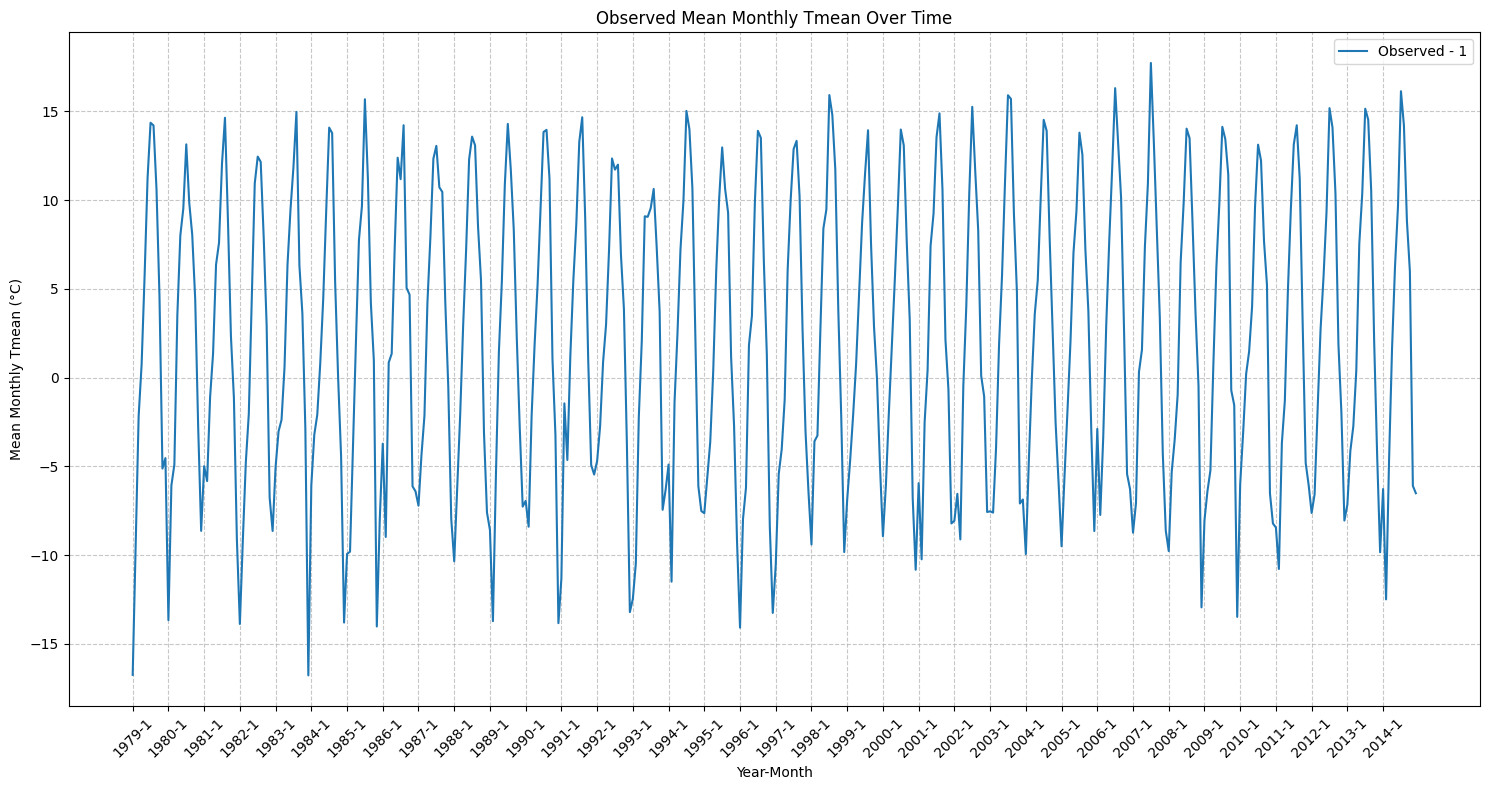

In [94]:
plot_mean_monthly_trends(observed_dfs, 'tmean', title_prefix='Observed')

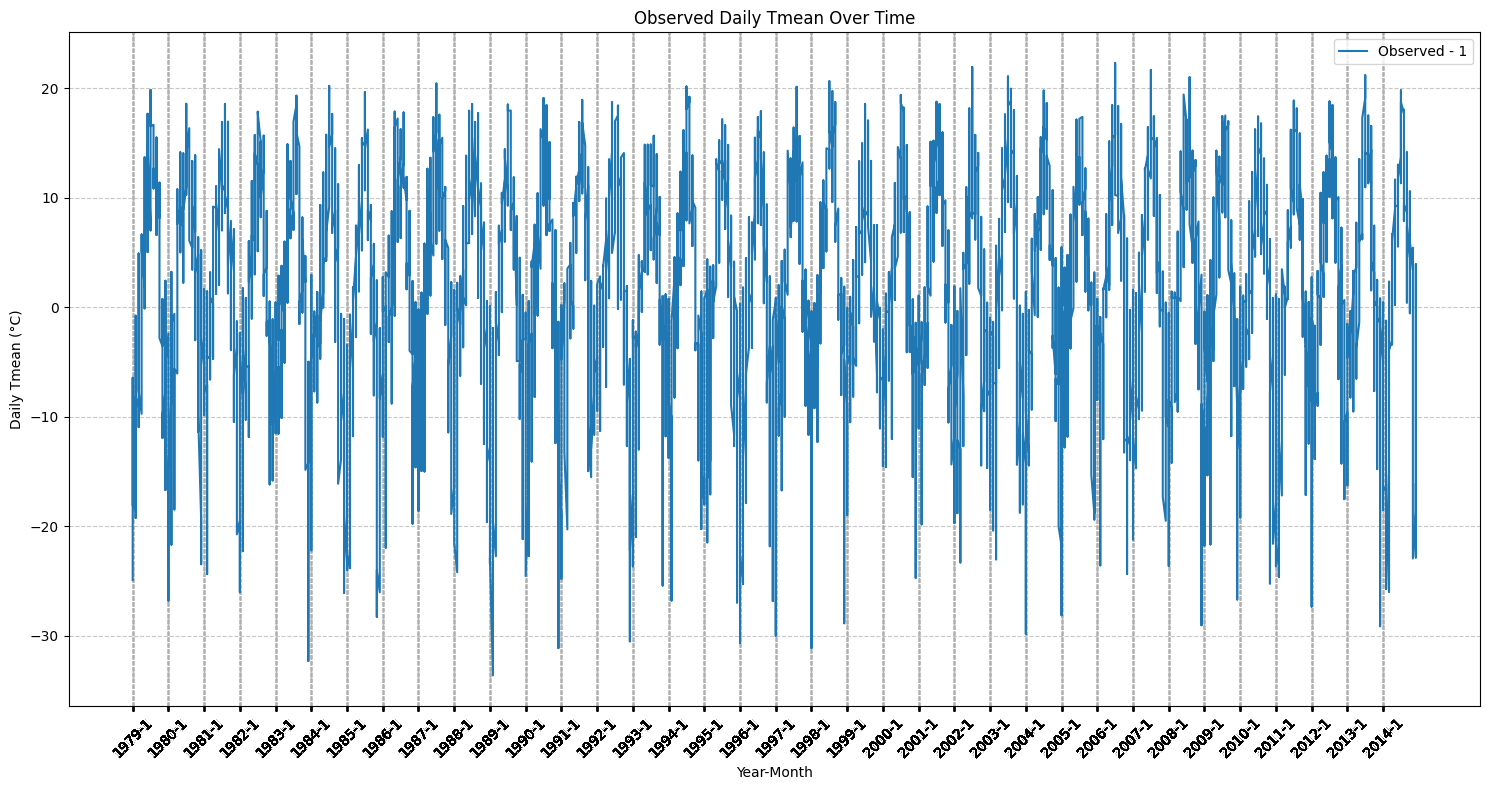

In [95]:
plot_daily_trends(observed_dfs, 'tmean', title_prefix='Observed')

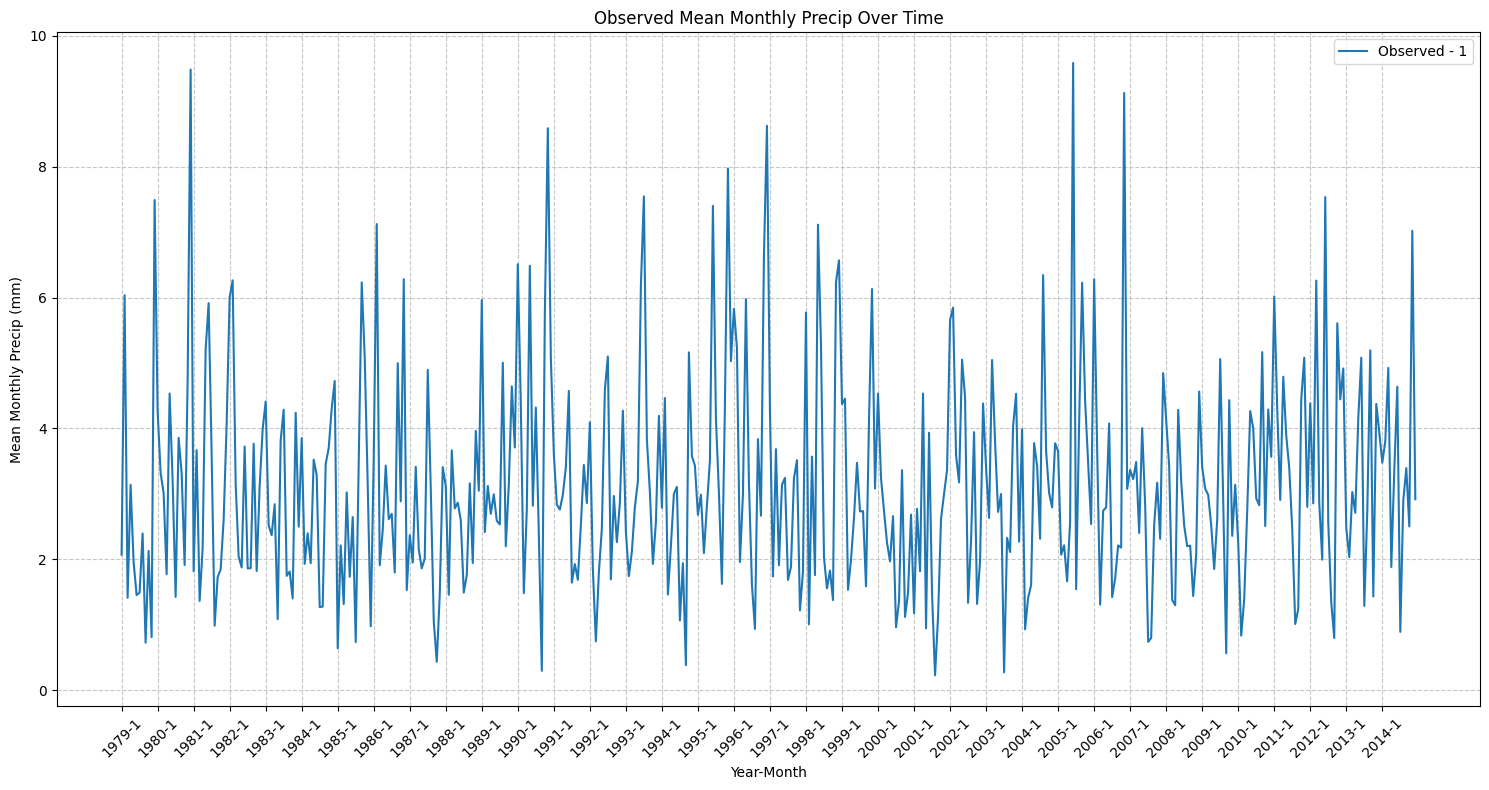

In [96]:
plot_mean_monthly_trends(observed_dfs, 'precip', title_prefix='Observed')

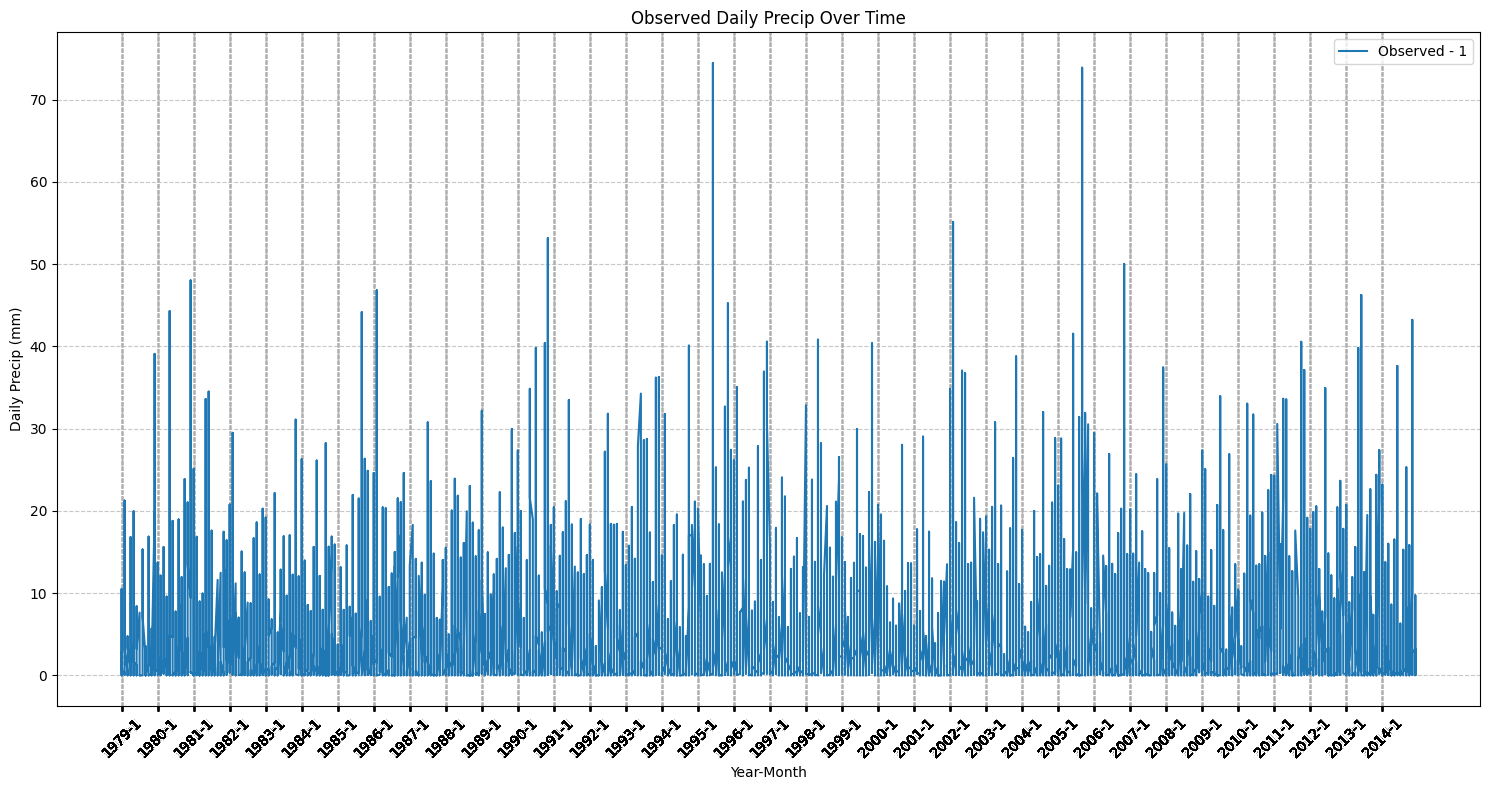

In [97]:
plot_daily_trends(observed_dfs, 'precip', title_prefix='Observed')

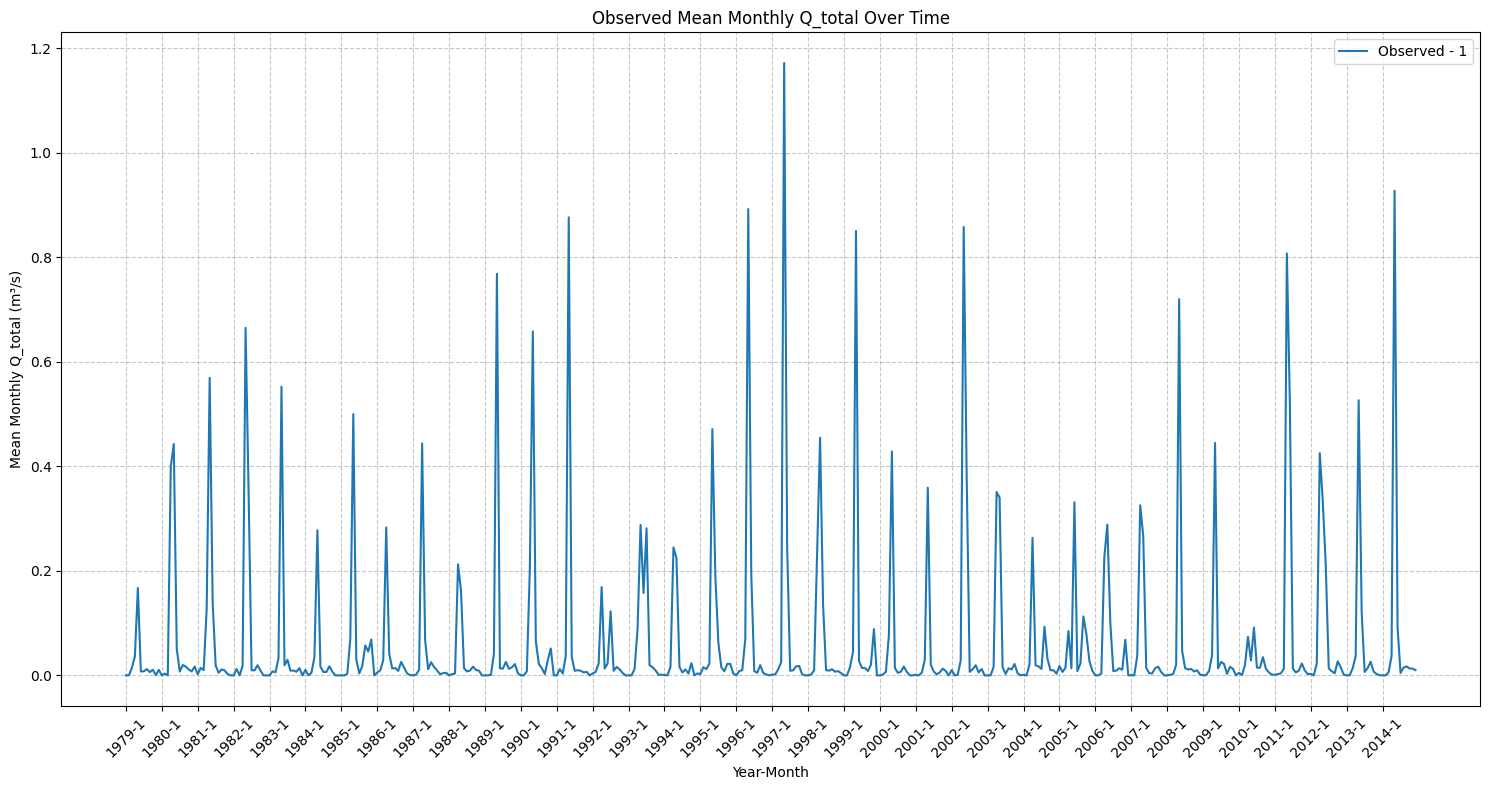

In [98]:
plot_mean_monthly_trends(observed_dfs, 'q_total', title_prefix='Observed') 

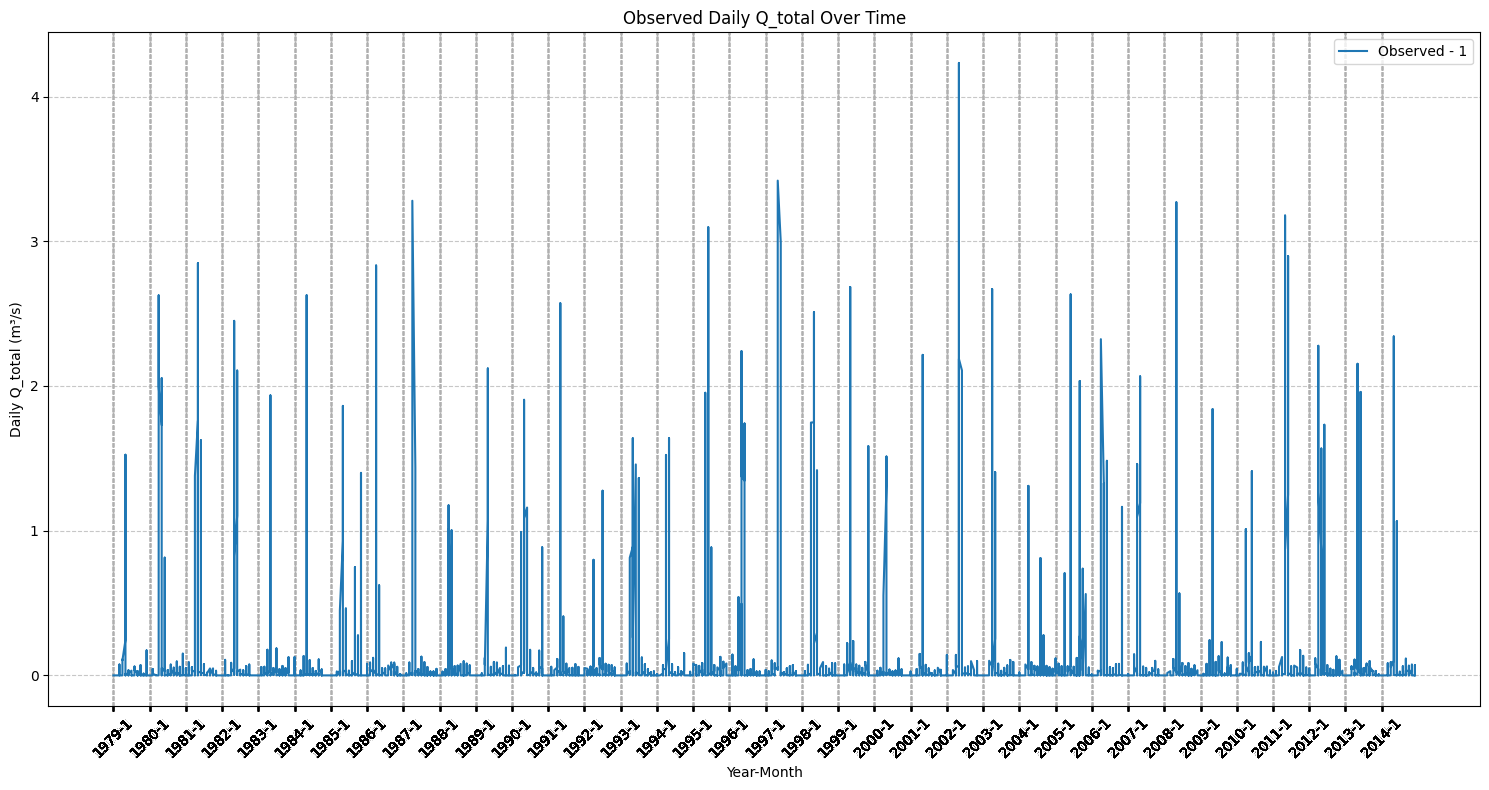

In [99]:
plot_daily_trends(observed_dfs, 'q_total', title_prefix='Observed')

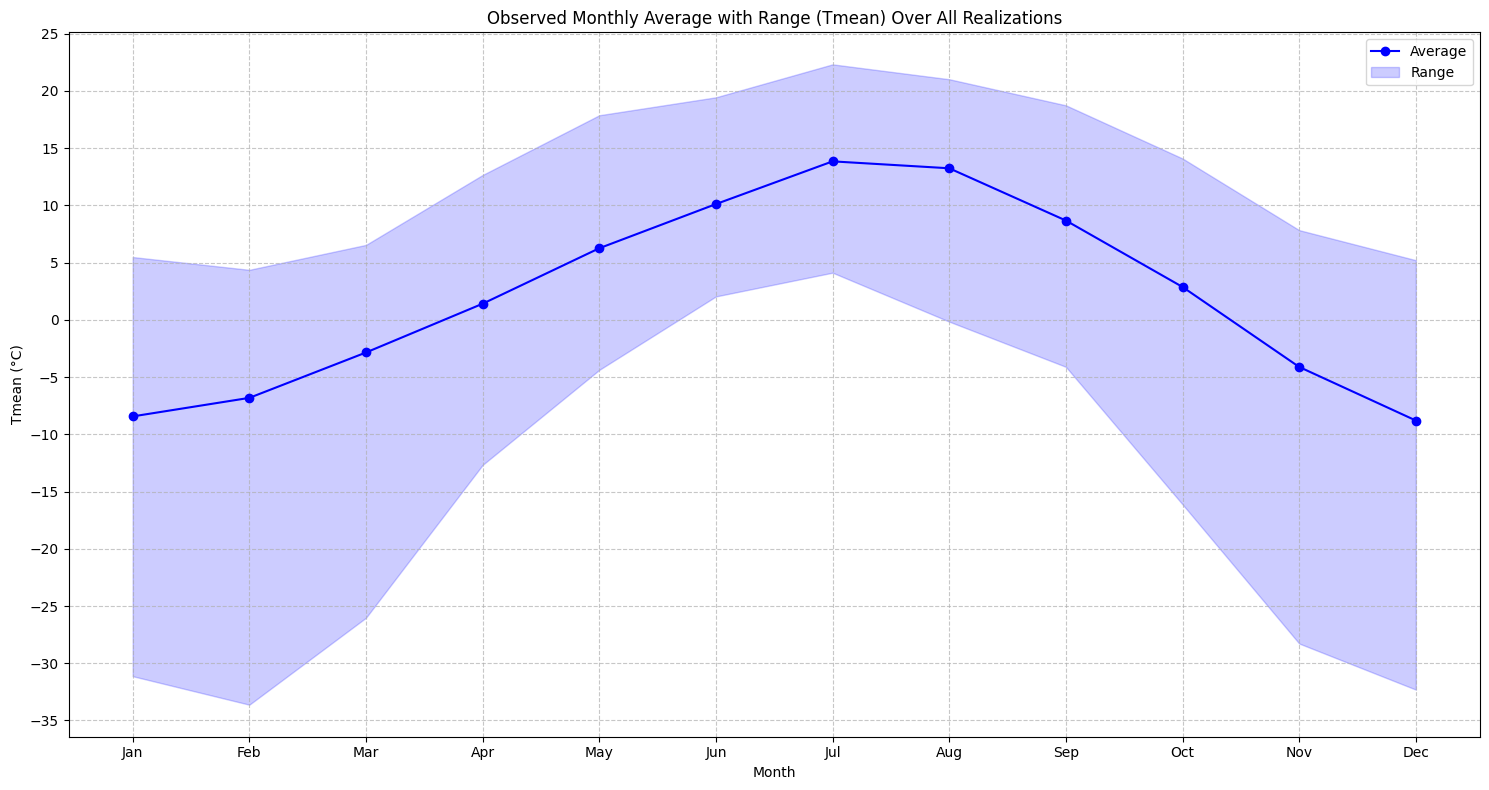

In [100]:
plot_monthly_average_with_range(observed_dfs, 'tmean', title_prefix="Observed")

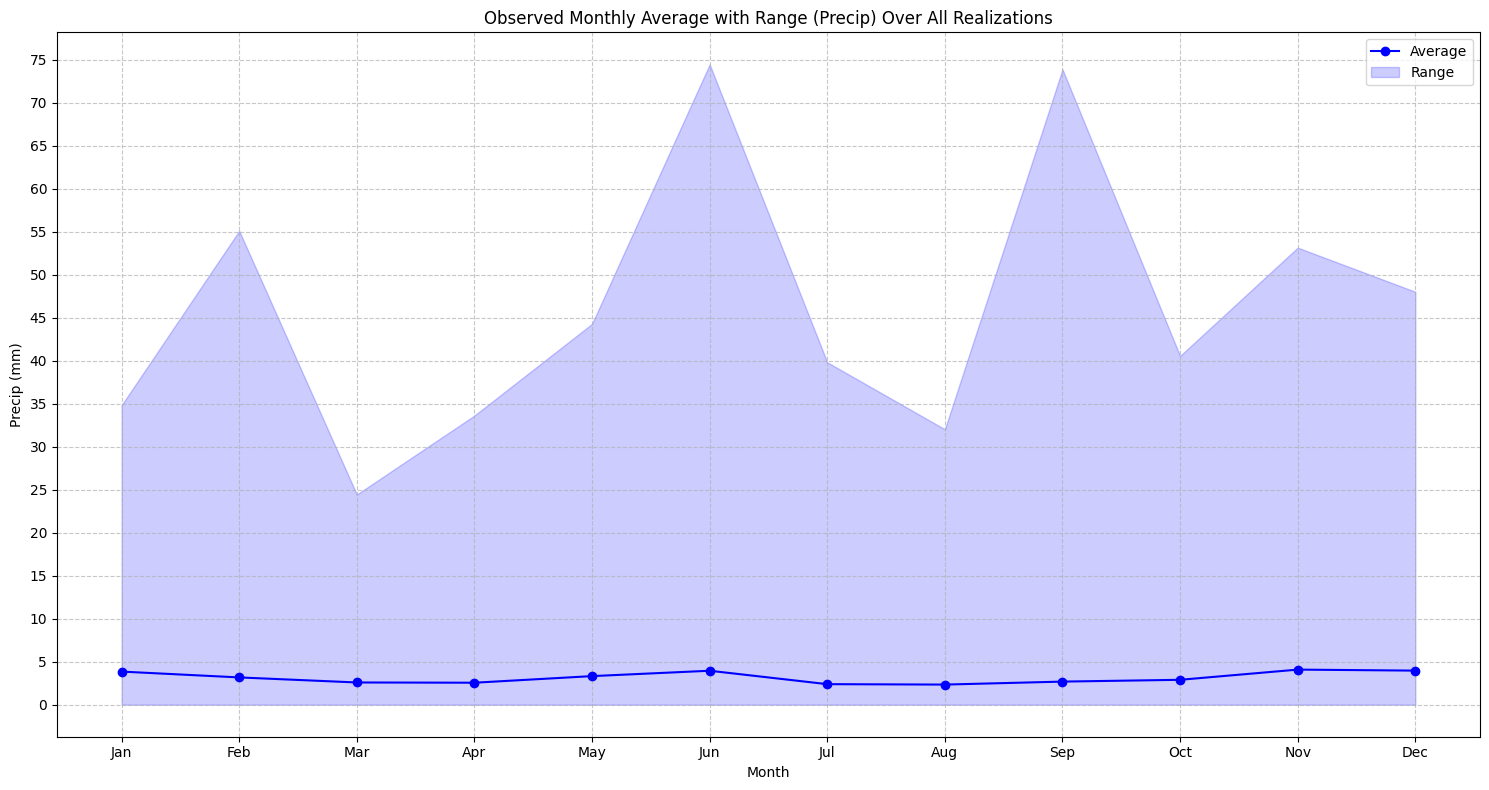

In [101]:
plot_monthly_average_with_range(observed_dfs, 'precip', title_prefix="Observed")

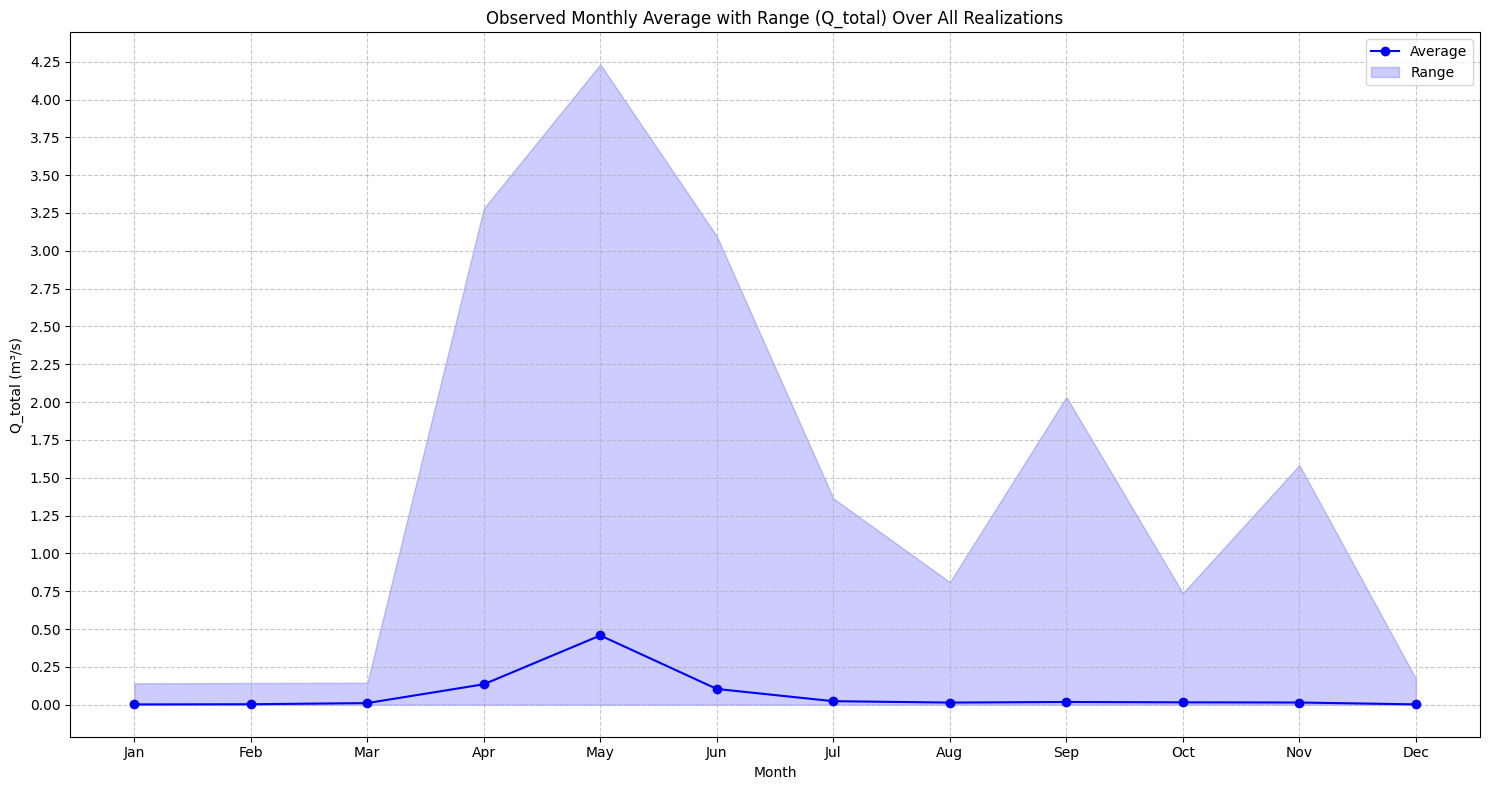

In [102]:
plot_monthly_average_with_range(observed_dfs, 'q_total', title_prefix="Observed")

In [103]:
results_obs = analyze_q_total_by_month(observed_dfs, 5) # may
print_combined_analysis_results(results_obs)

Combined DataFrame Analysis:
Mean 'q_total' for the month: 0.4575982974910394

Row with Maximum 'q_total':
      Date  tmean  precip  trange  evaporation  q_total  Month  Year
2002-05-21 5.6931  37.048  5.0142     2.279442   4.2325      5  2002

Top 5 highest 'q_total' values:
      Date    tmean  precip   trange  evaporation  q_total  Month  Year
2002-05-21  5.69310  37.048  5.01420     2.279442   4.2325      5  2002
2002-05-22 -0.84050  36.263  4.36960     0.000000   3.5128      5  2002
1997-05-31 14.31315  12.106 10.51570     5.336429   3.4192      5  1997
2008-05-20 11.36530  10.898 12.30940     4.630303   3.2694      5  2008
2011-05-26  3.40558  33.549  5.78664     1.815436   3.1780      5  2011

--------------------------------------------------



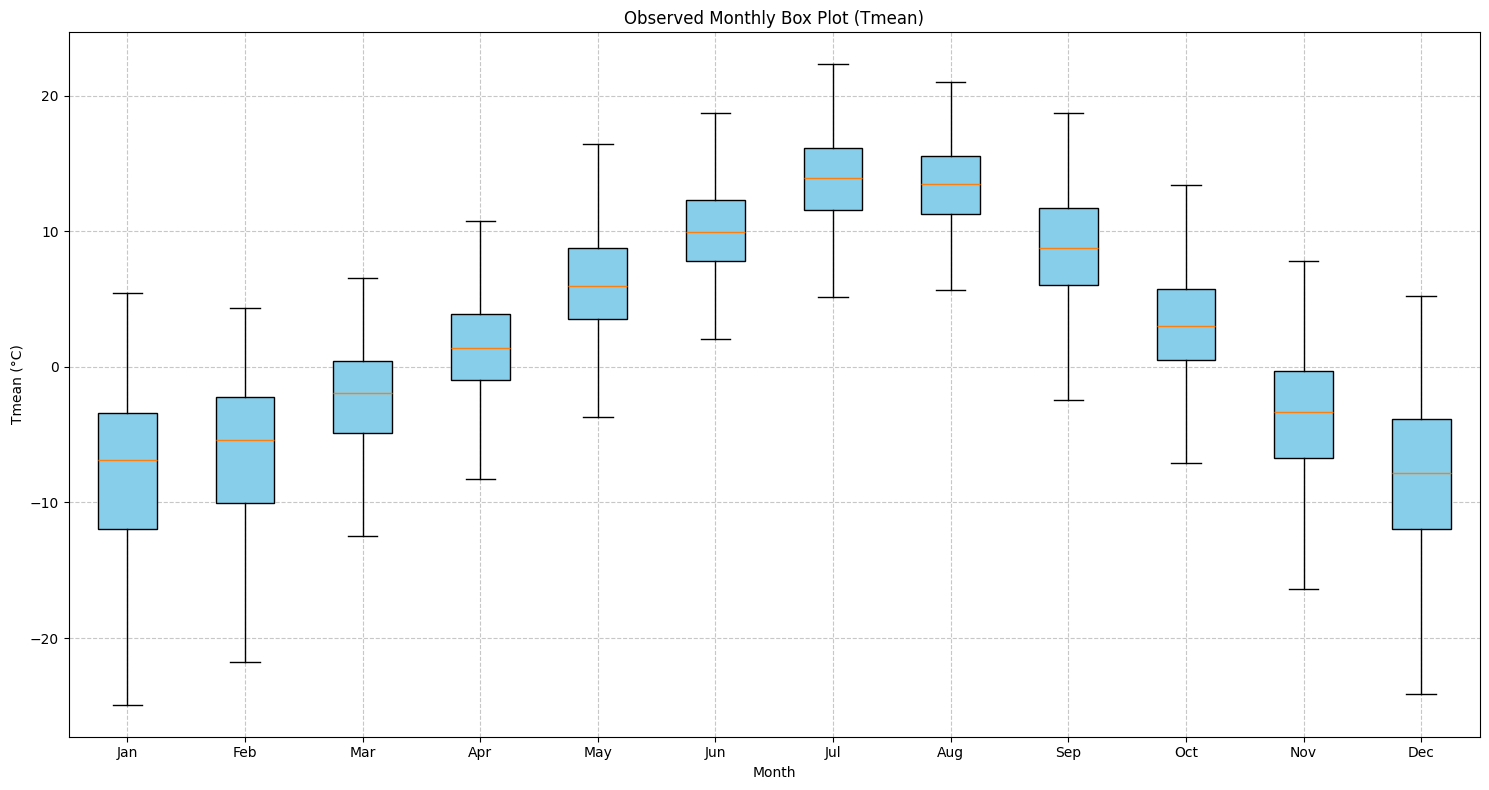

In [104]:
plot_monthly_boxplot(observed_dfs, 'tmean', title_prefix='Observed')


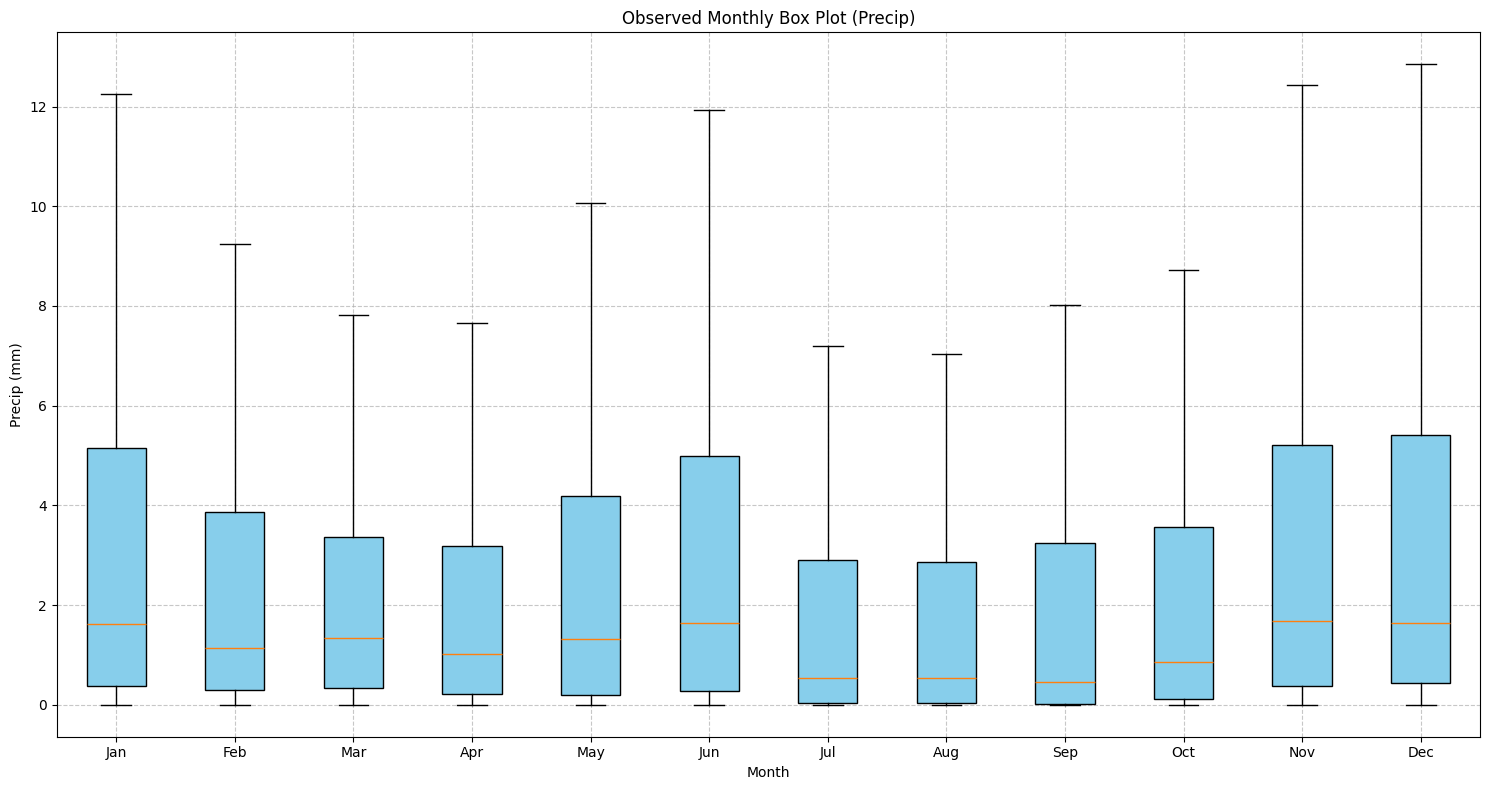

In [105]:
plot_monthly_boxplot(observed_dfs, 'precip', title_prefix='Observed')


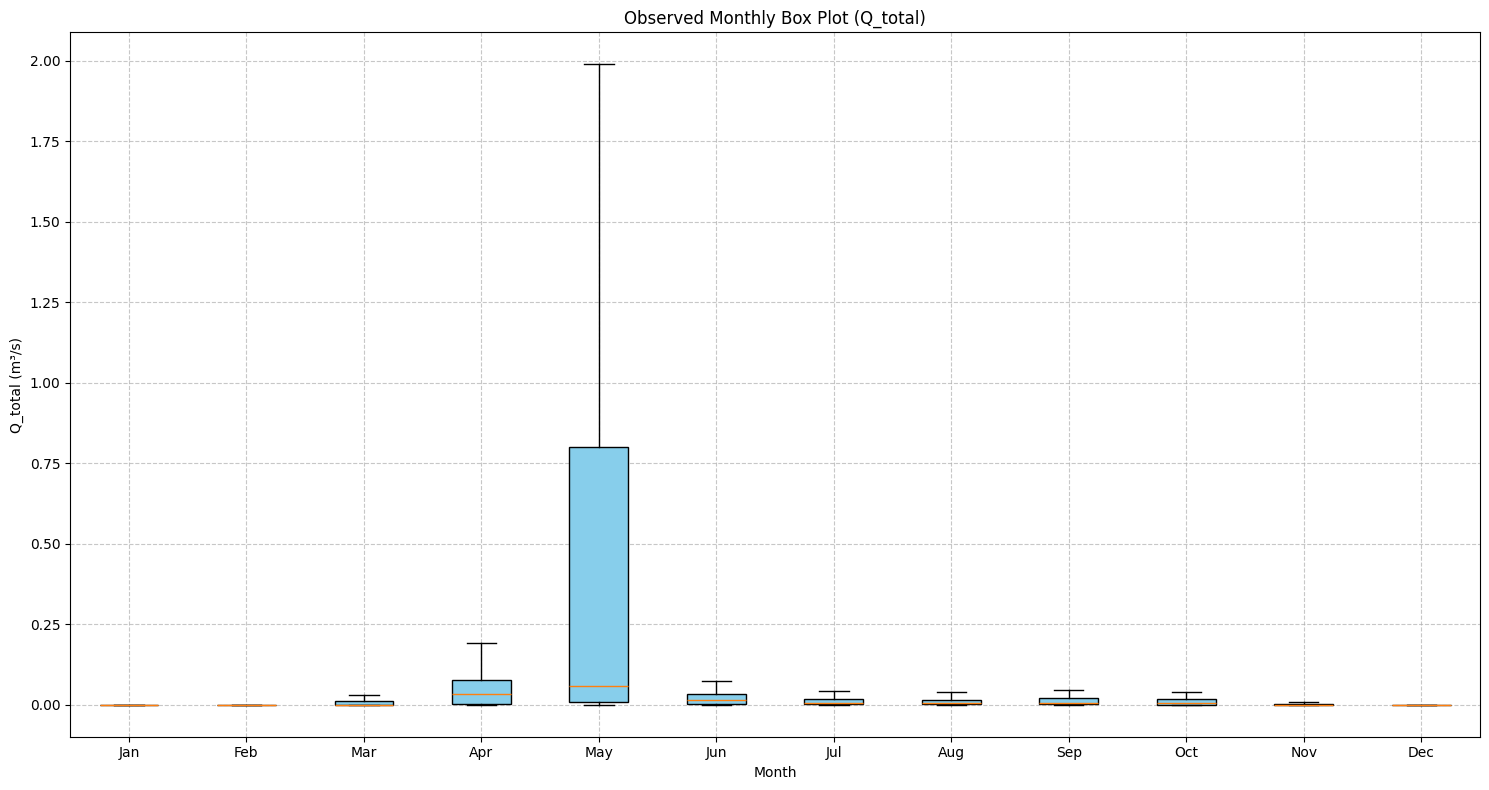

In [106]:
plot_monthly_boxplot(observed_dfs, 'q_total', title_prefix='Observed')


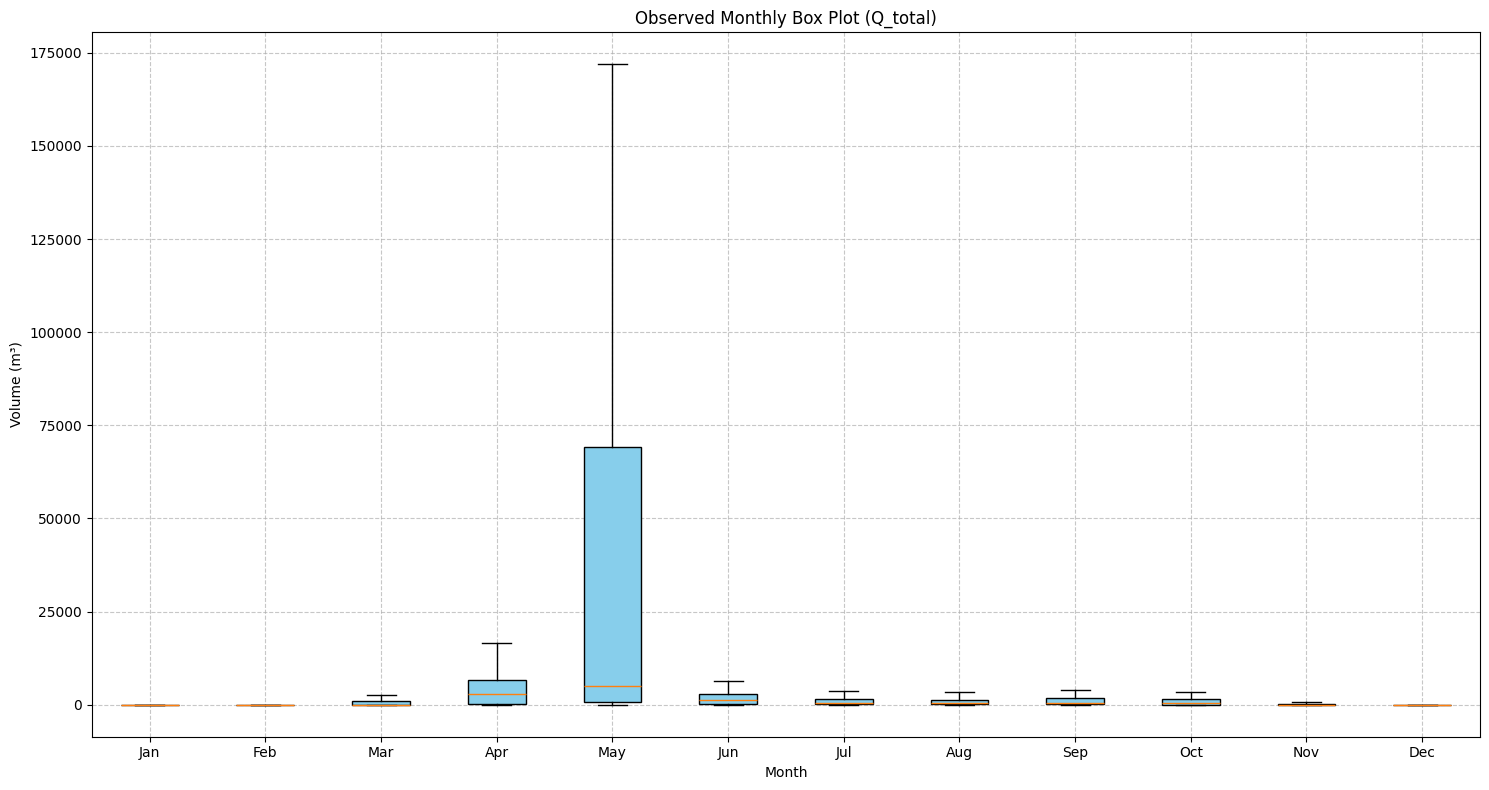

In [107]:
plot_monthly_volume_boxplot(observed_dfs, 'Observed')

## **Scenario 1:** SSP1-2.6 = *assumes reduced emissions*

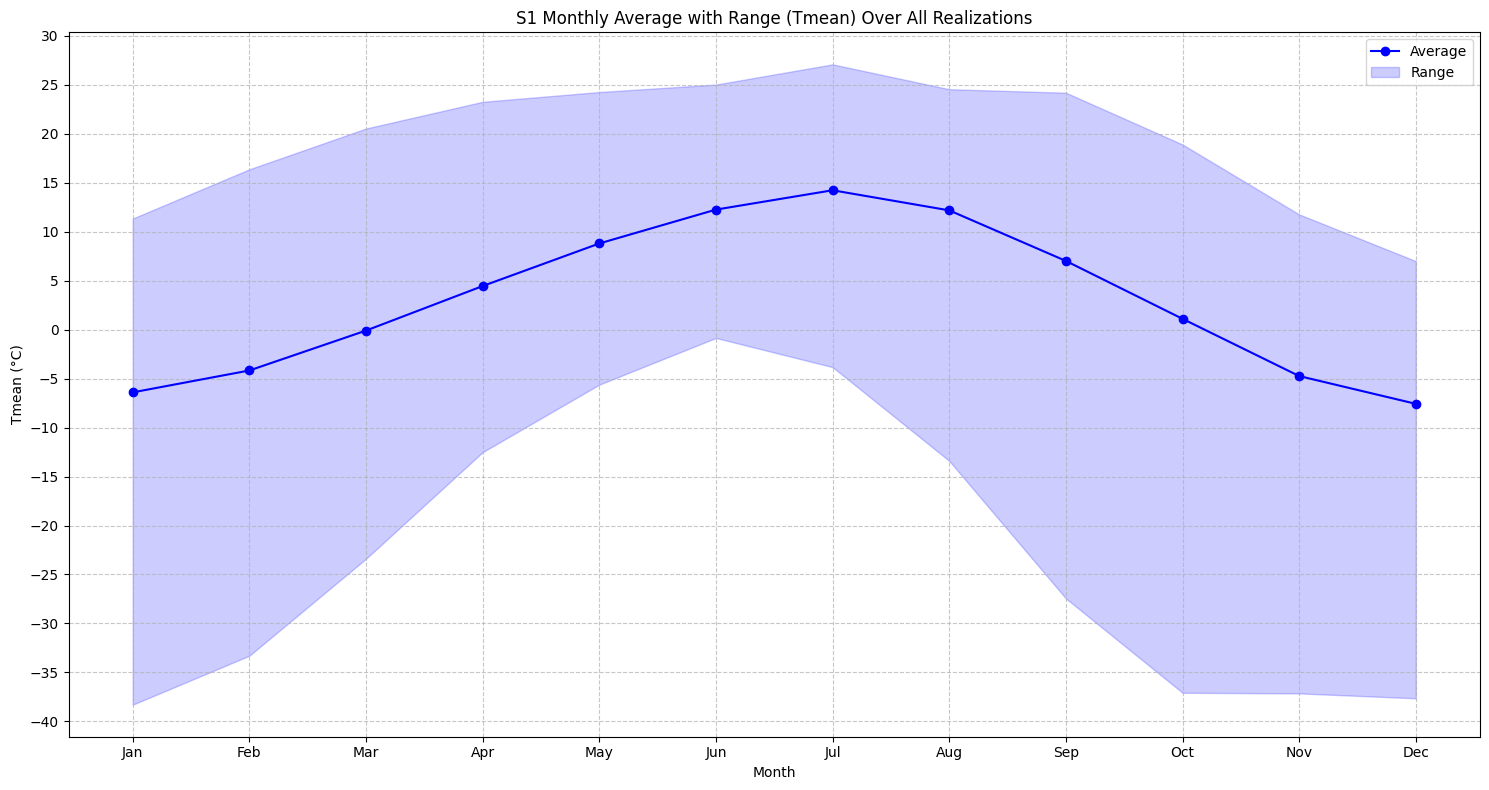

In [108]:
plot_monthly_average_with_range(s1_dfs, 'tmean', title_prefix="S1")

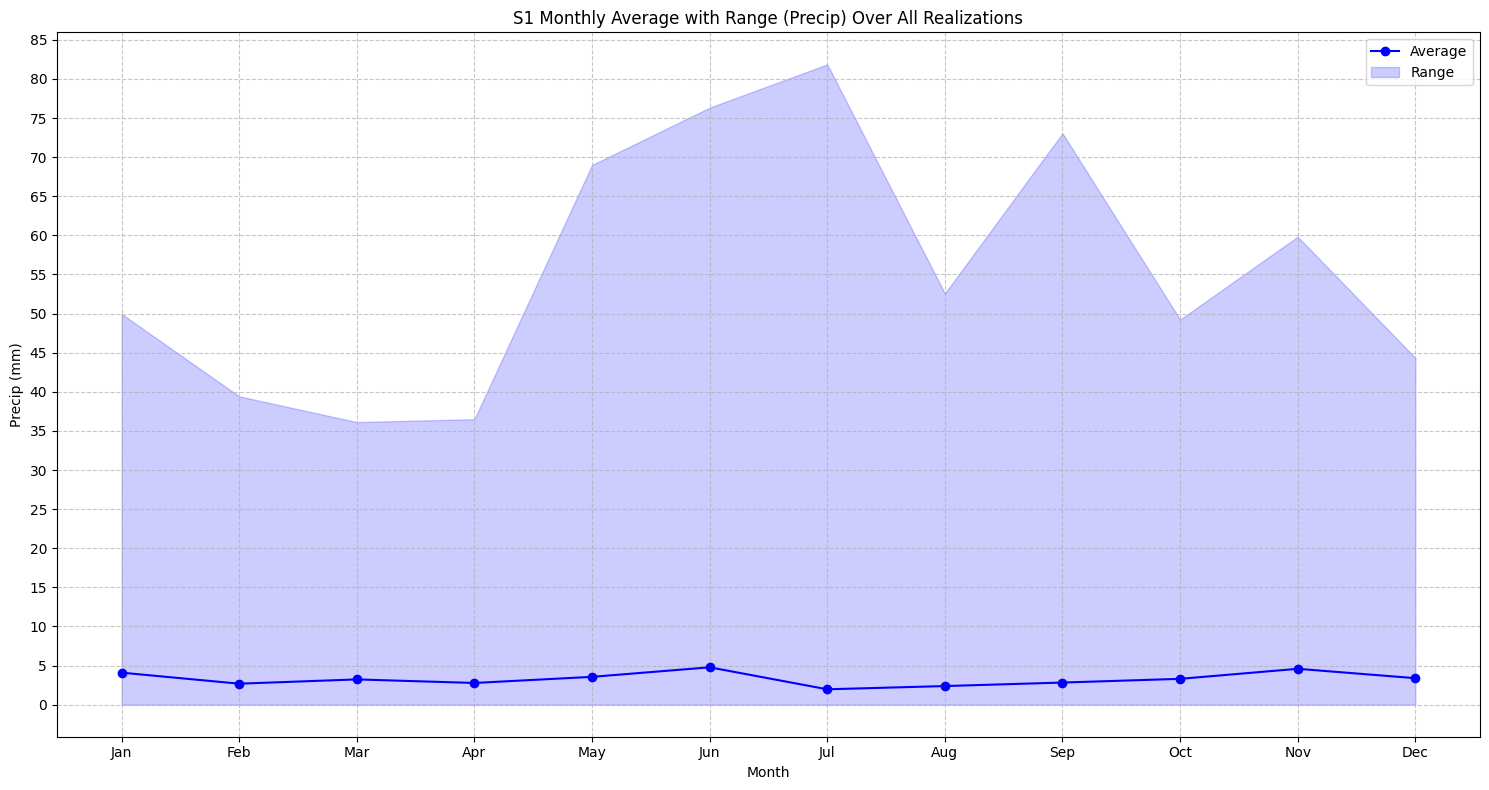

In [109]:
plot_monthly_average_with_range(s1_dfs, 'precip', title_prefix="S1") 

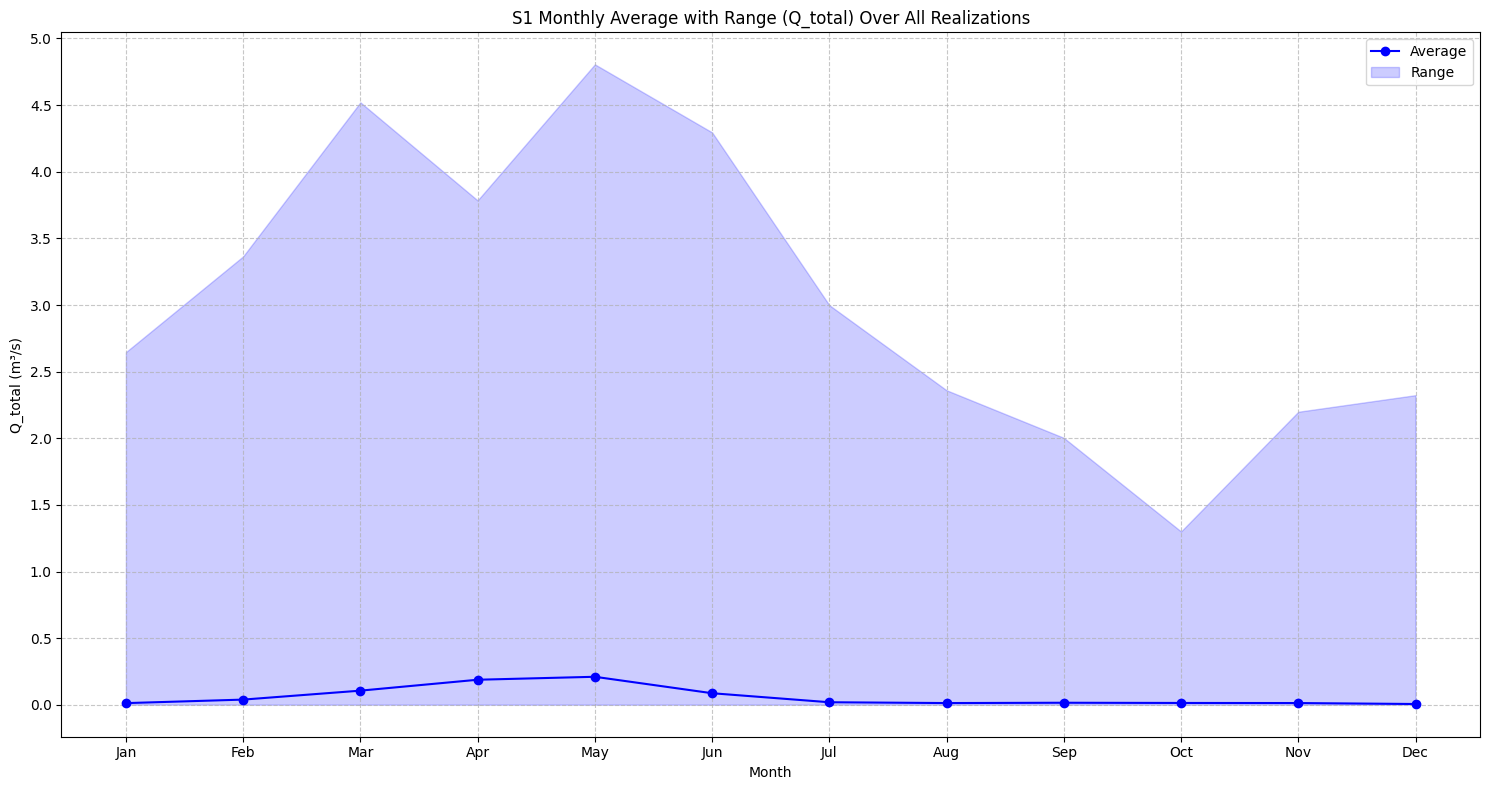

In [110]:
plot_monthly_average_with_range(s1_dfs, 'q_total', title_prefix="S1")

In [111]:
results_s1 = analyze_q_total_by_month(s1_dfs, 5) # may
print_combined_analysis_results(results_s1)

Combined DataFrame Analysis:
Mean 'q_total' for the month: 0.21091578395087693

Row with Maximum 'q_total':
      Date    precip    tmean   trange  evaporation  q_total
2033-05-27 32.013252 8.717978 3.997386     2.945149   4.8055

Top 5 highest 'q_total' values:
      Date    precip    tmean   trange  evaporation  q_total
2033-05-27 32.013252 8.717978 3.997386     2.945149  4.80550
2037-05-14 37.209579 9.036348 9.033734     3.601307  4.62517
2037-05-15  6.753602 5.312681 5.851460     2.288225  4.02929
2033-05-28  9.660860 8.199526 6.756087     3.114226  4.02150
2068-05-31 44.340202 6.045963 7.469788     2.617997  3.95980

--------------------------------------------------



In [112]:
results_s1 = analyze_q_total_by_month(s1_dfs, 3) # march
print_combined_analysis_results(results_s1)

Combined DataFrame Analysis:
Mean 'q_total' for the month: 0.10684807995268049

Row with Maximum 'q_total':
      Date    precip     tmean    trange  evaporation  q_total
2077-03-24 22.908075 13.133562 15.282703     5.478438  4.52038

Top 5 highest 'q_total' values:
      Date    precip     tmean    trange  evaporation  q_total
2077-03-24 22.908075 13.133562 15.282703     5.478438  4.52038
2057-03-16  0.874912 10.516474  9.083334     3.984928  3.60555
2077-03-23 12.008595 14.370892 16.741959     6.059047  3.59740
2069-03-21 19.021931 11.663498 10.287159     4.459443  3.56581
2099-03-08 22.741179  6.901175  9.302860     3.009248  3.52537

--------------------------------------------------



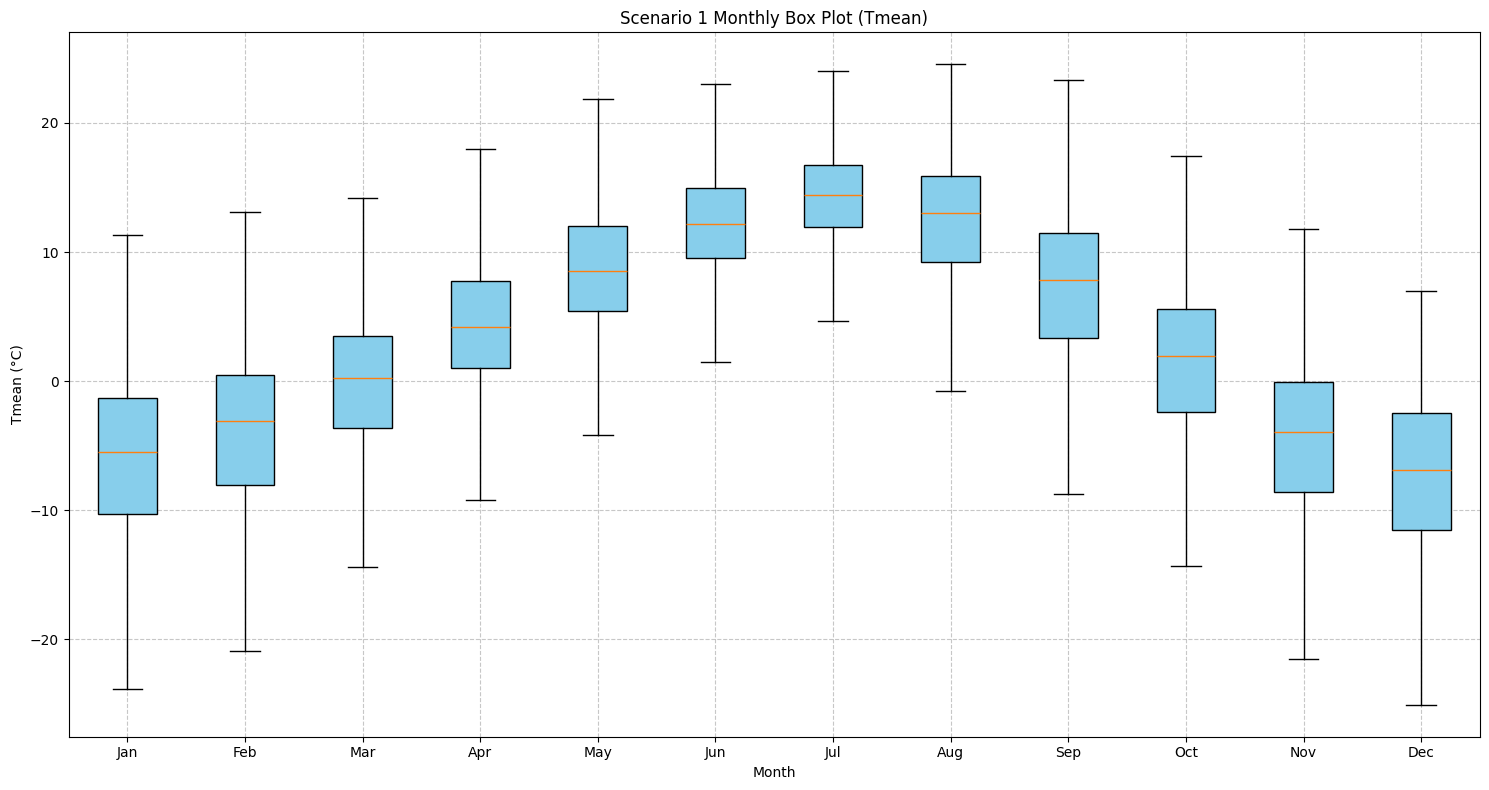

In [113]:
plot_monthly_boxplot(s1_dfs, 'tmean', title_prefix='Scenario 1')


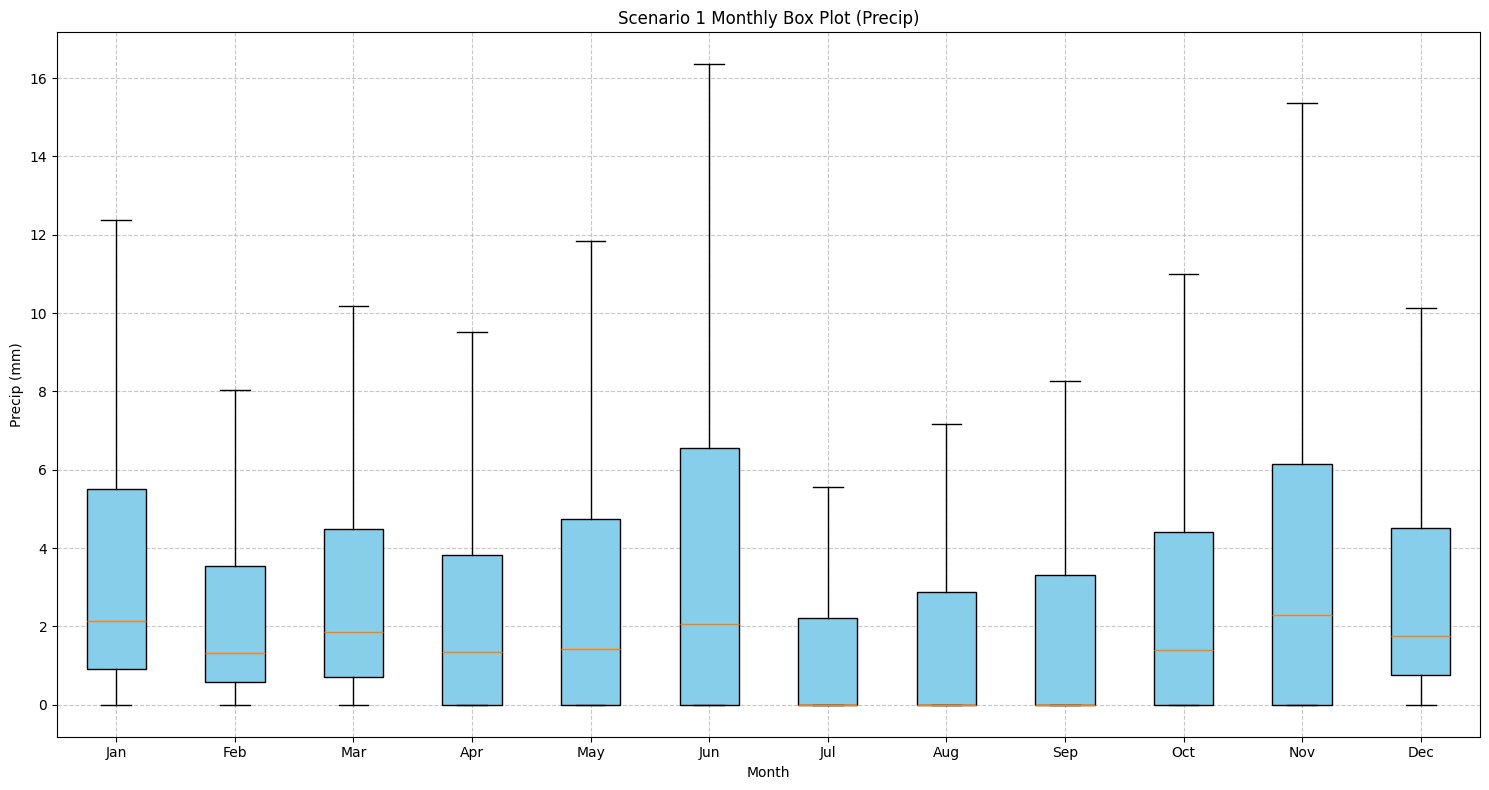

In [114]:
plot_monthly_boxplot(s1_dfs, 'precip', title_prefix='Scenario 1')


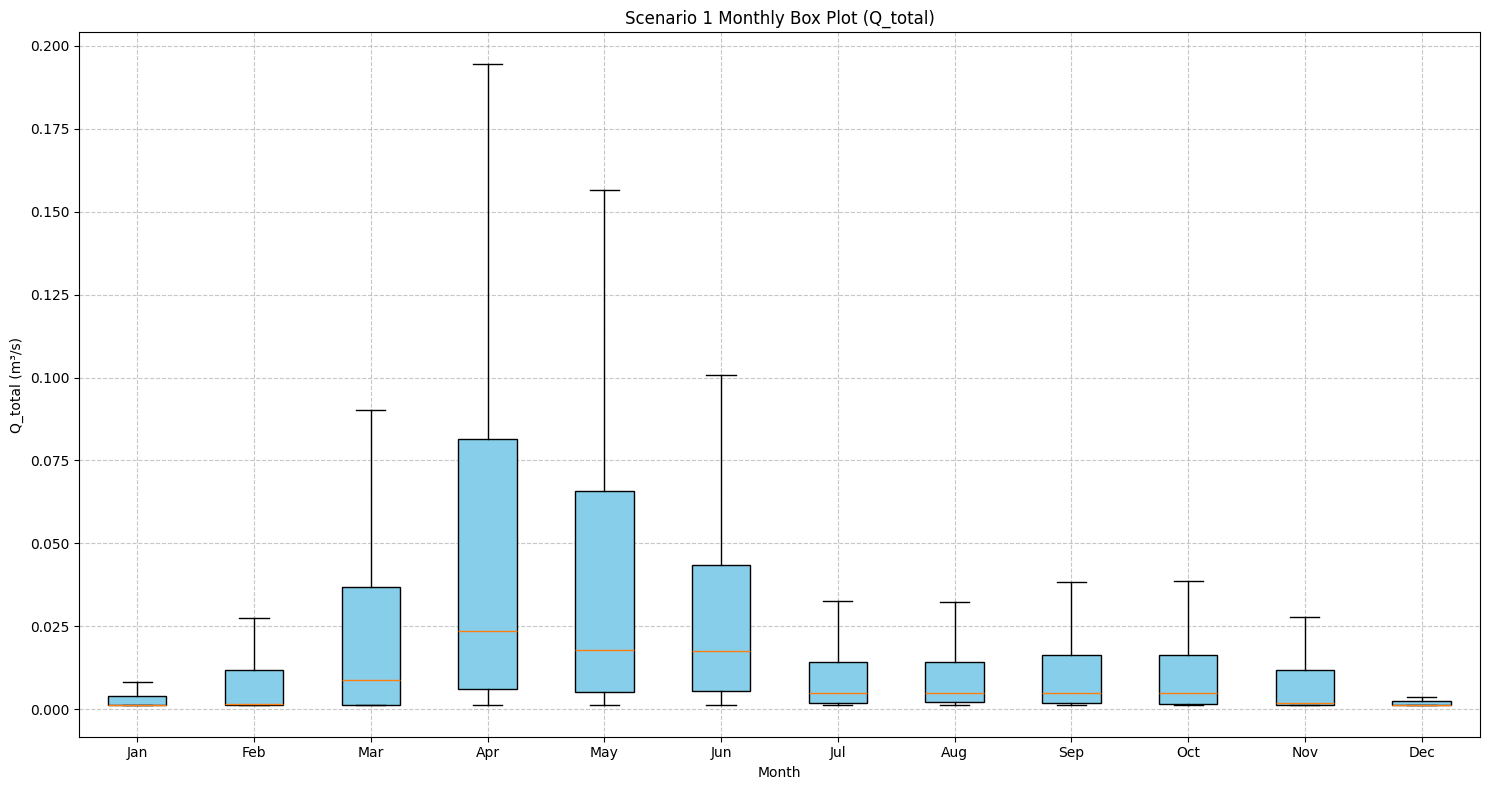

In [115]:
plot_monthly_boxplot(s1_dfs, 'q_total', title_prefix='Scenario 1')

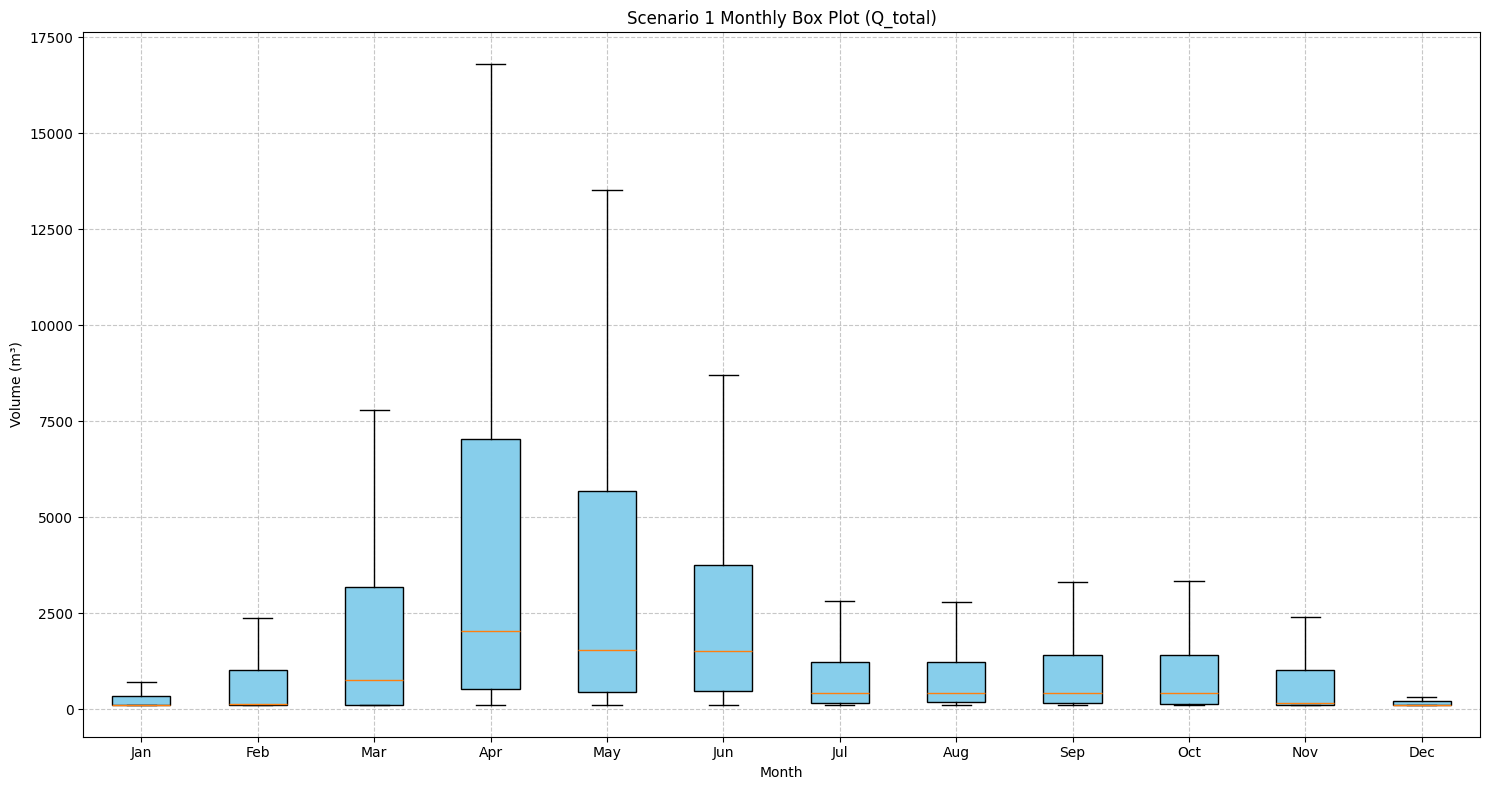

In [116]:
plot_monthly_volume_boxplot(s1_dfs, 'Scenario 1')

## **Scenario 2:** SSP2-4.5 = *assumes the same trend of emissions as historical*

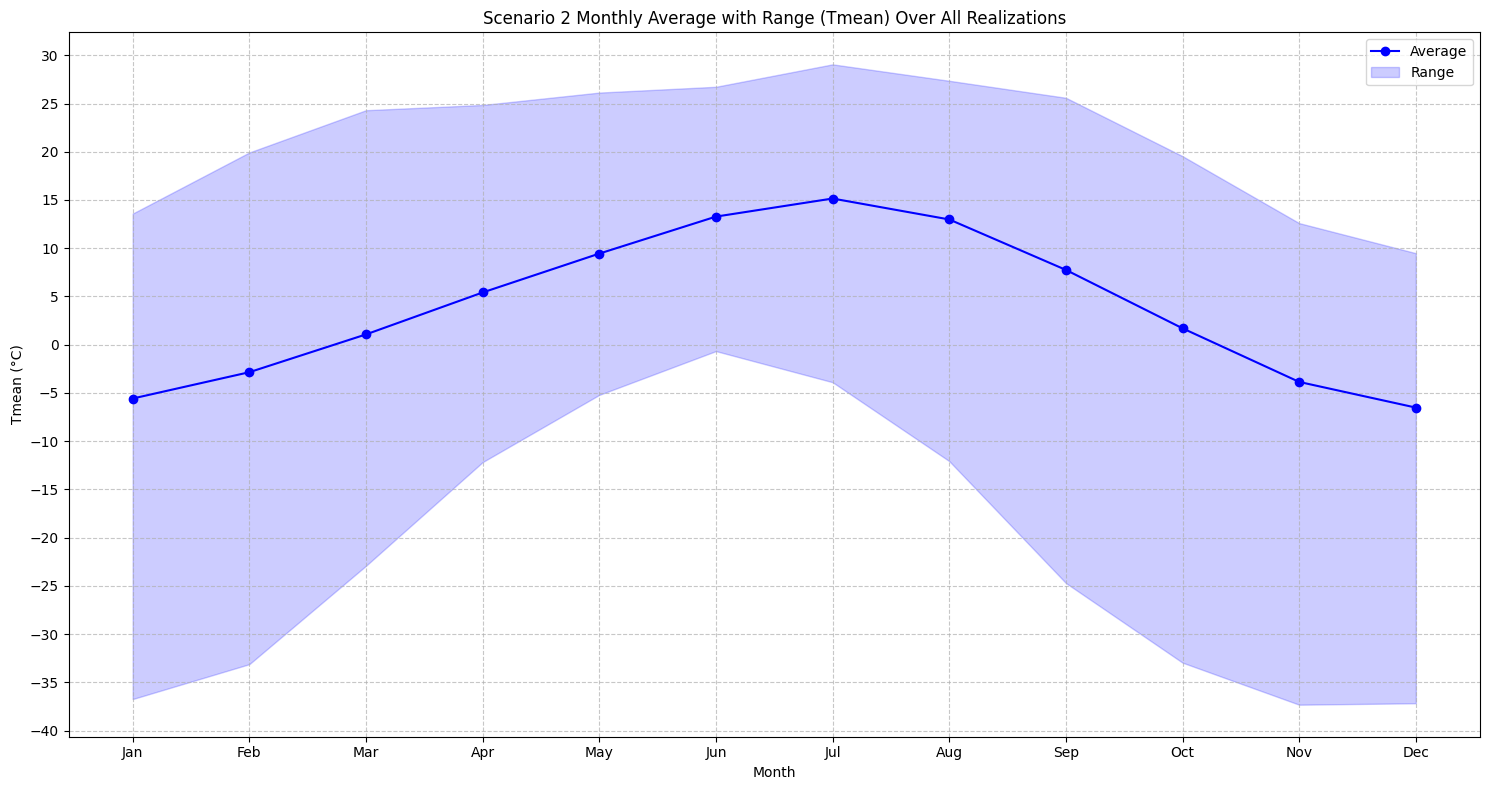

In [117]:
plot_monthly_average_with_range(s2_dfs, 'tmean', title_prefix="Scenario 2")


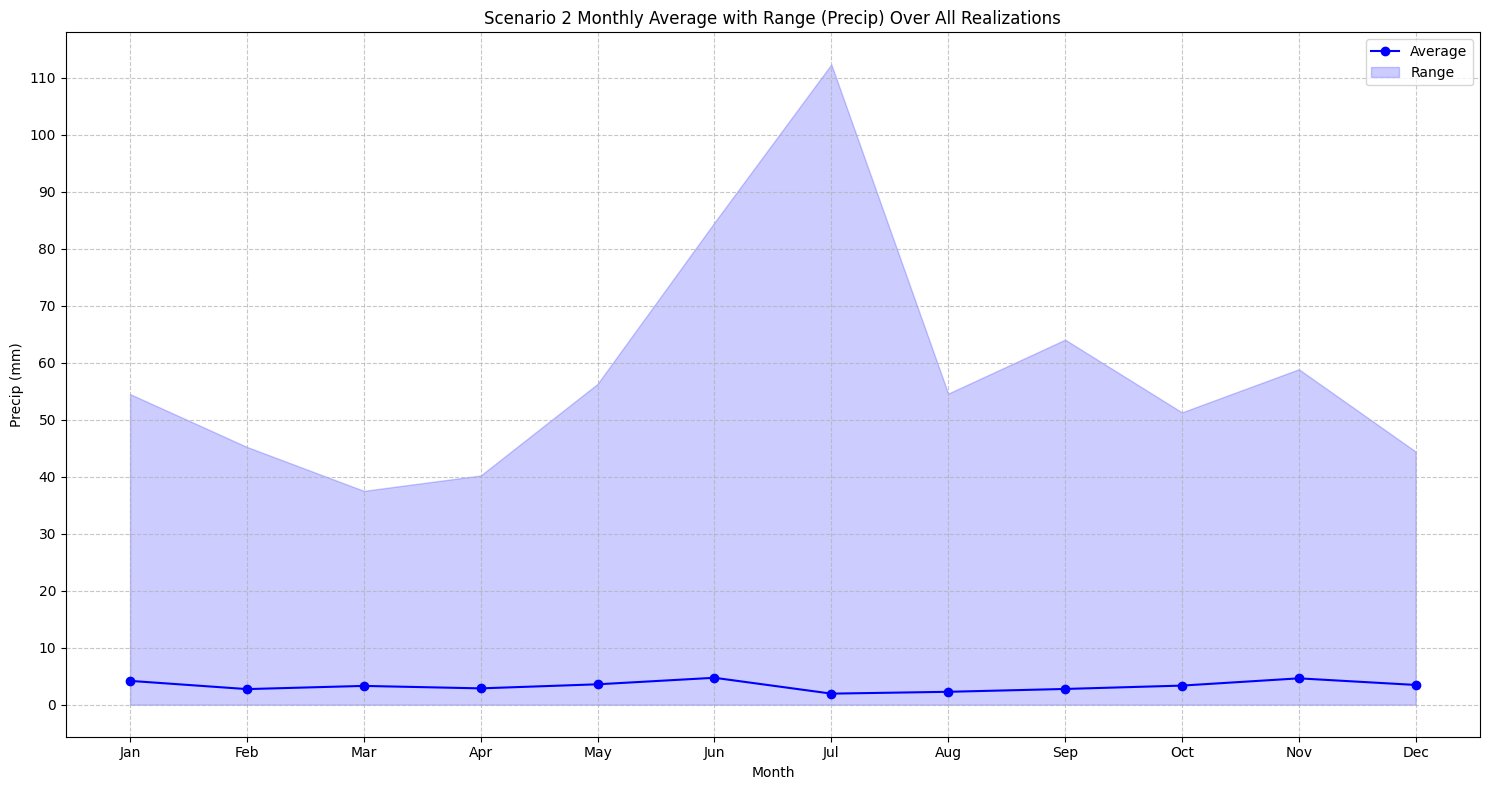

In [118]:
plot_monthly_average_with_range(s2_dfs, 'precip', title_prefix="Scenario 2")


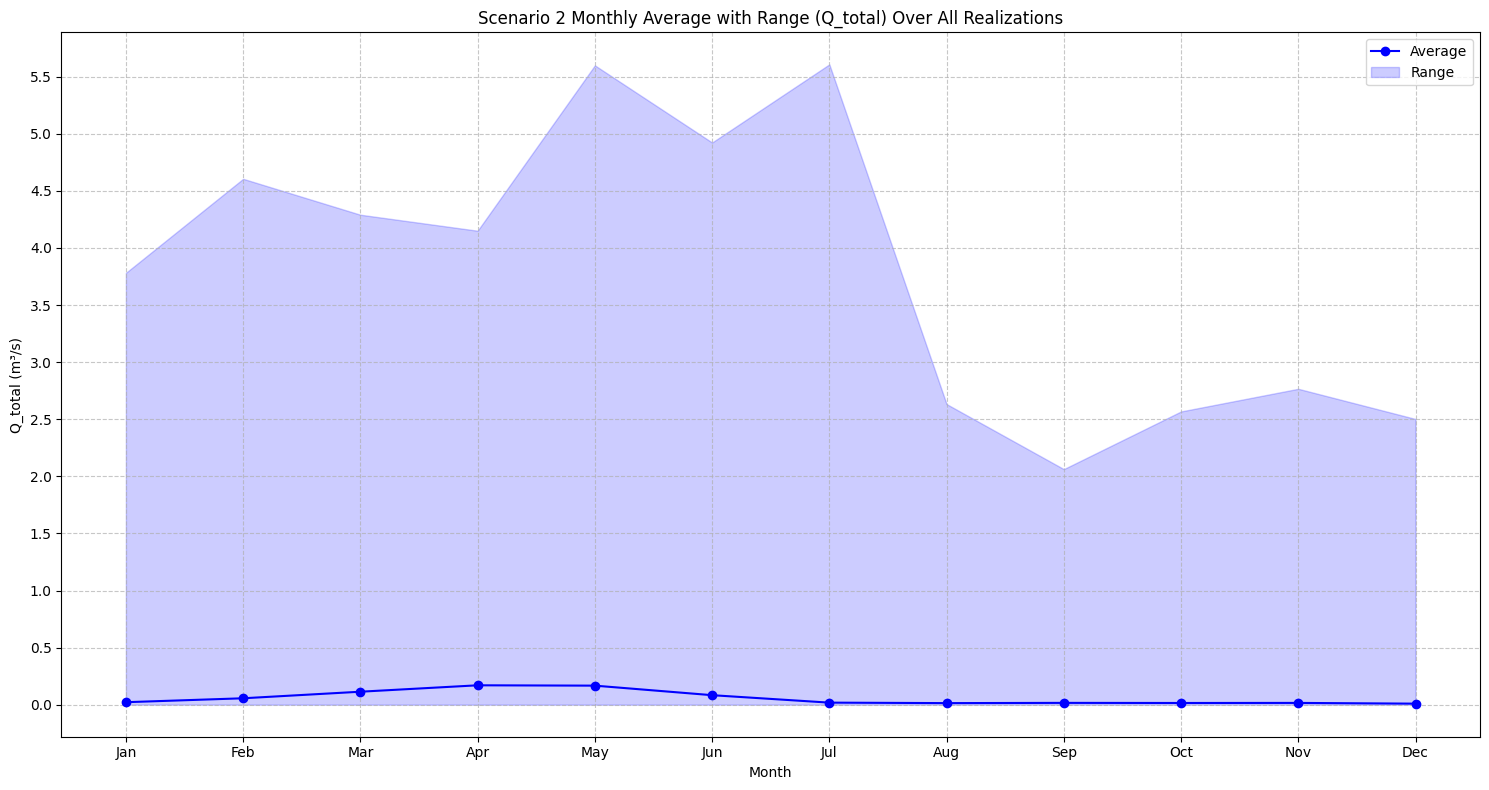

In [119]:
plot_monthly_average_with_range(s2_dfs, 'q_total', title_prefix="Scenario 2")


In [120]:
results_s2 = analyze_q_total_by_month(s2_dfs, 5) # may
print_combined_analysis_results(results_s2)

Combined DataFrame Analysis:
Mean 'q_total' for the month: 0.16694688410851982

Row with Maximum 'q_total':
      Date   precip     tmean    trange  evaporation  q_total
2068-05-26 7.469568 24.128645 22.579739    10.819784  5.59885

Top 5 highest 'q_total' values:
      Date    precip     tmean    trange  evaporation  q_total
2068-05-26  7.469568 24.128645 22.579739    10.819784  5.59885
2068-05-27 14.238656 19.375004 16.041103     7.863966  4.96340
2020-05-27 30.426470 12.208611 14.691141     5.153187  4.90477
2068-05-25  0.000000 21.846802 24.607824    10.046961  4.69874
2068-05-24  0.000000 21.068993 24.617746     9.705285  4.45919

--------------------------------------------------



In [121]:
results_s2 = analyze_q_total_by_month(s2_dfs, 7) # july
print_combined_analysis_results(results_s2)

Combined DataFrame Analysis:
Mean 'q_total' for the month: 0.018127545075924154

Row with Maximum 'q_total':
      Date     precip     tmean    trange  evaporation  q_total
2073-07-08 112.385132 16.523256 10.289205      6.29454  5.60758

Top 5 highest 'q_total' values:
      Date     precip     tmean    trange  evaporation  q_total
2073-07-08 112.385132 16.523256 10.289205     6.294540  5.60758
2022-07-01  93.932297  9.473228  4.412216     3.409281  5.57795
2065-07-12  80.290825 15.413870  7.535095     5.573585  5.48398
2044-07-03  86.306465  3.478518  7.127378     2.175408  4.20577
2065-07-11  58.355896 17.871338  9.653616     6.695696  3.85905

--------------------------------------------------



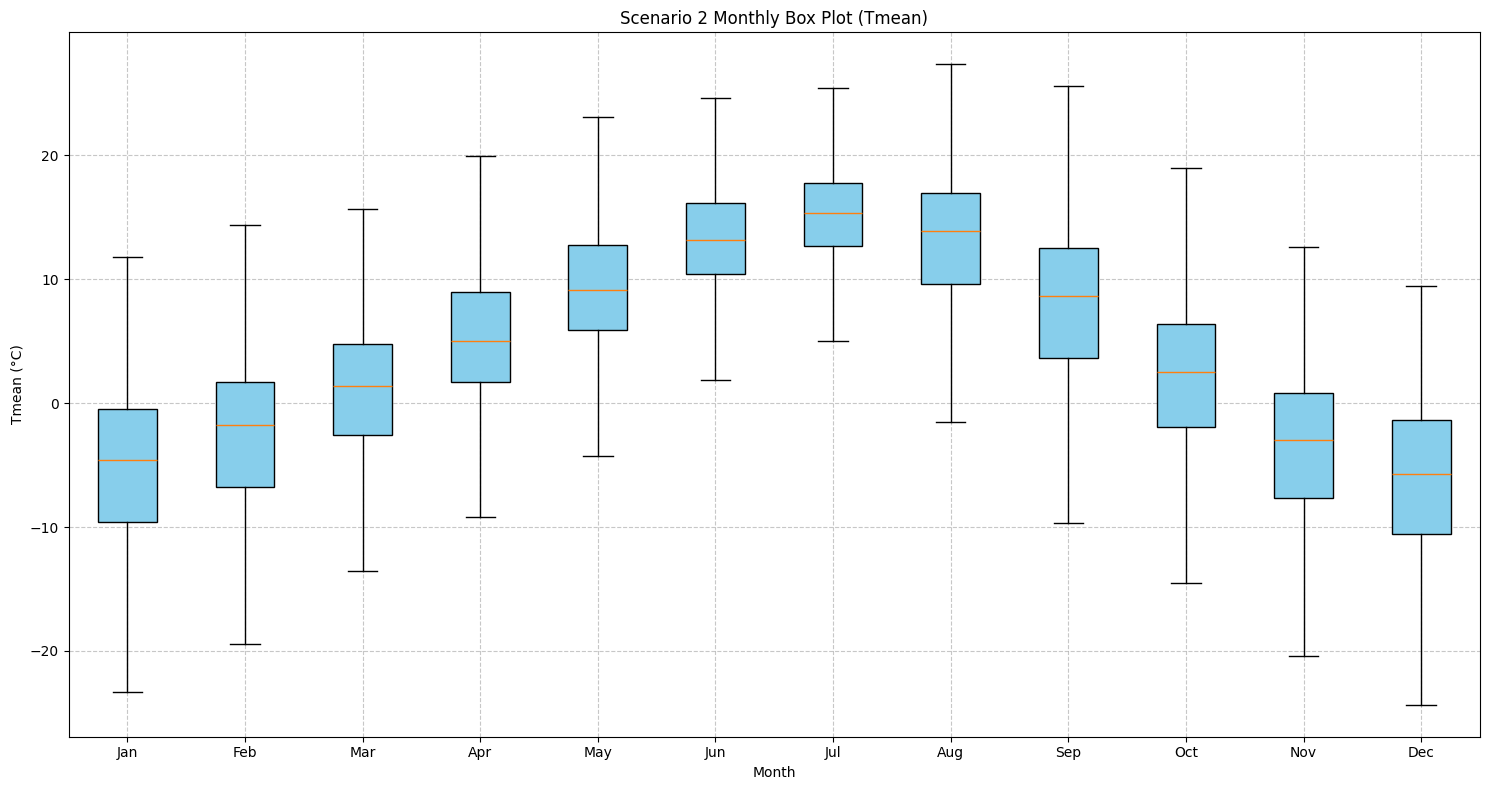

In [122]:
plot_monthly_boxplot(s2_dfs, 'tmean', title_prefix='Scenario 2')


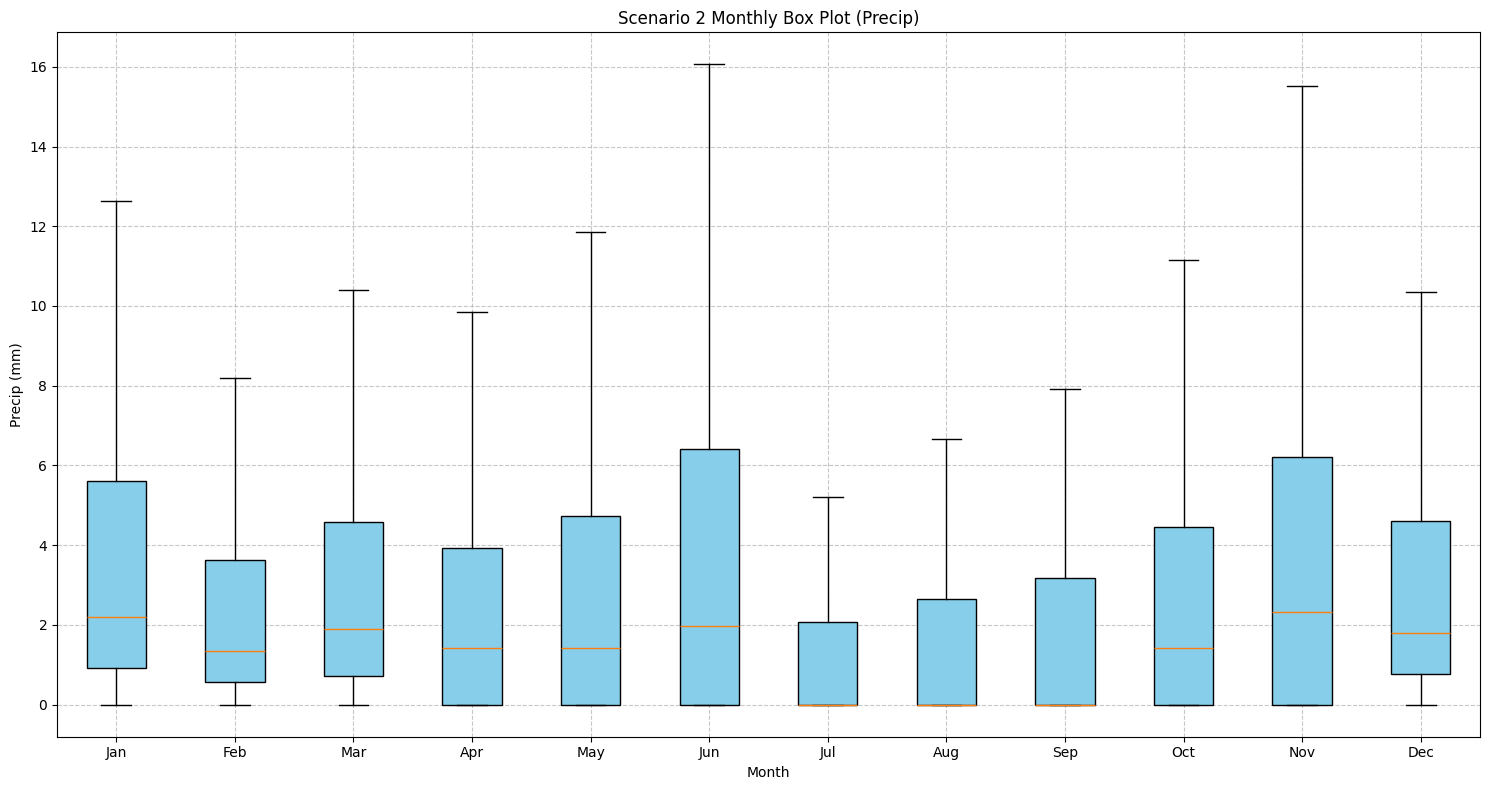

In [123]:
plot_monthly_boxplot(s2_dfs, 'precip', title_prefix='Scenario 2')


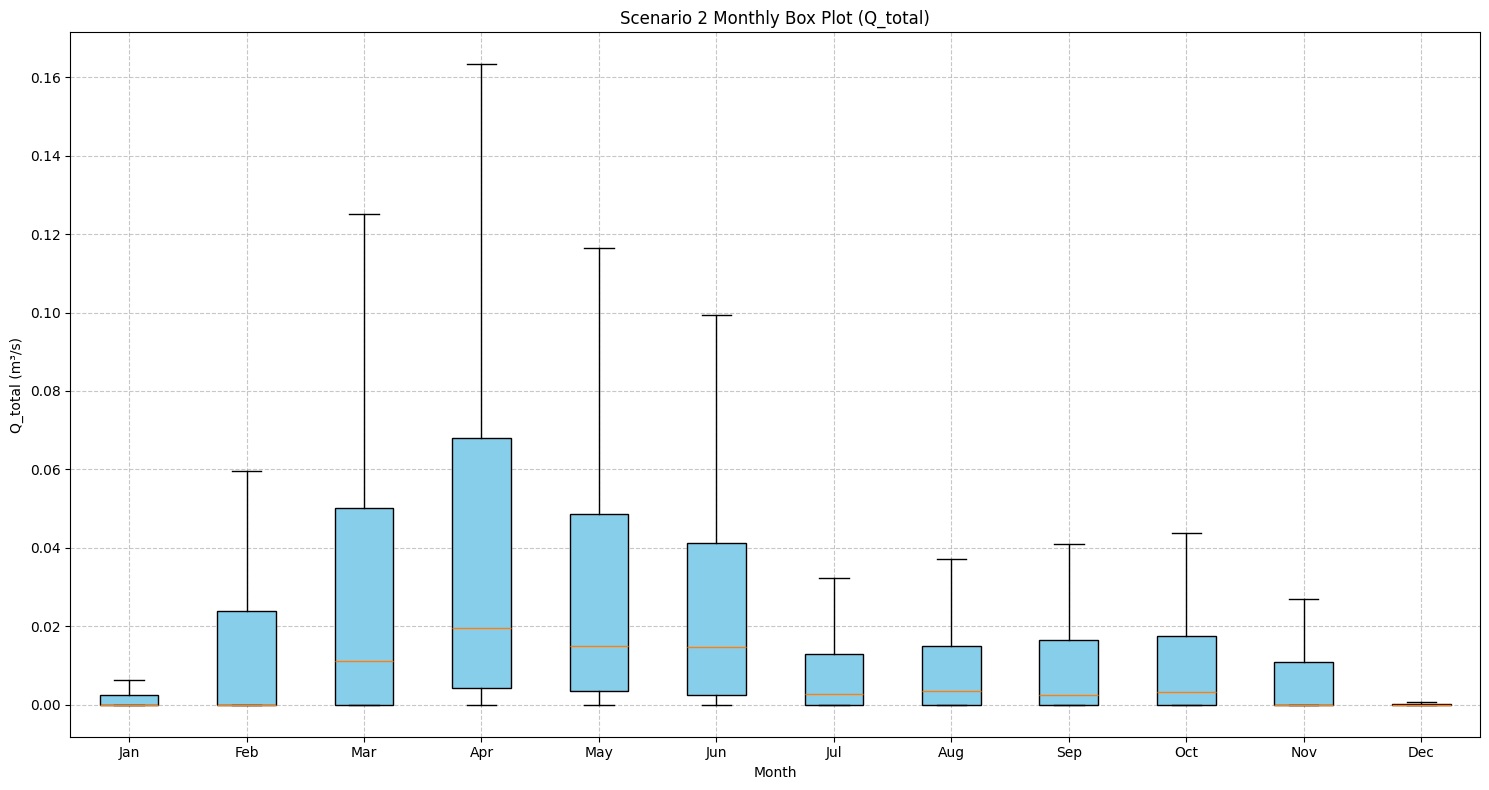

In [124]:
plot_monthly_boxplot(s2_dfs, 'q_total', title_prefix='Scenario 2')


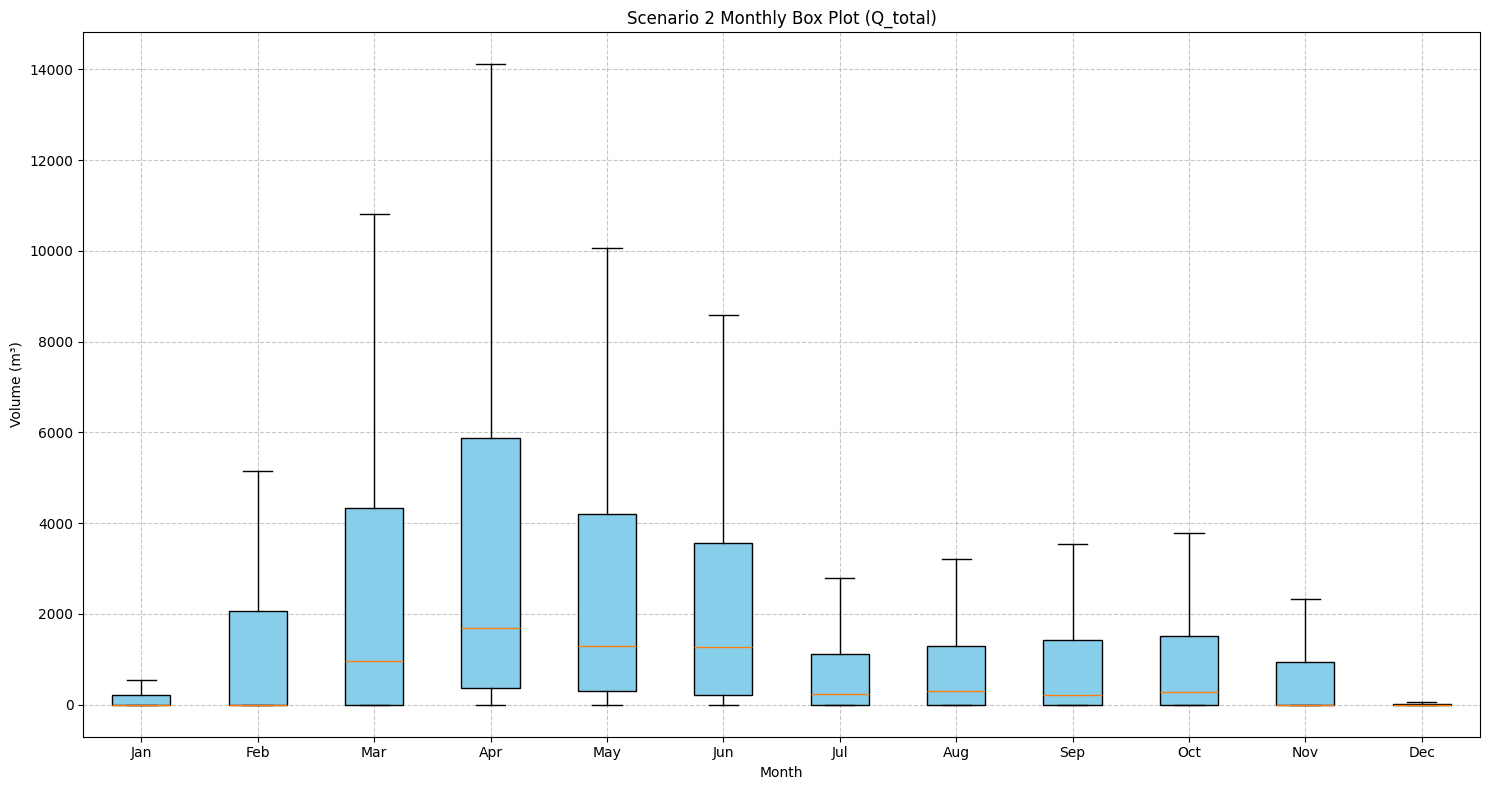

In [125]:
plot_monthly_volume_boxplot(s2_dfs, 'Scenario 2')

## **Scenario 3:** SSP3-7.0 = *medium to high emissions scenario*

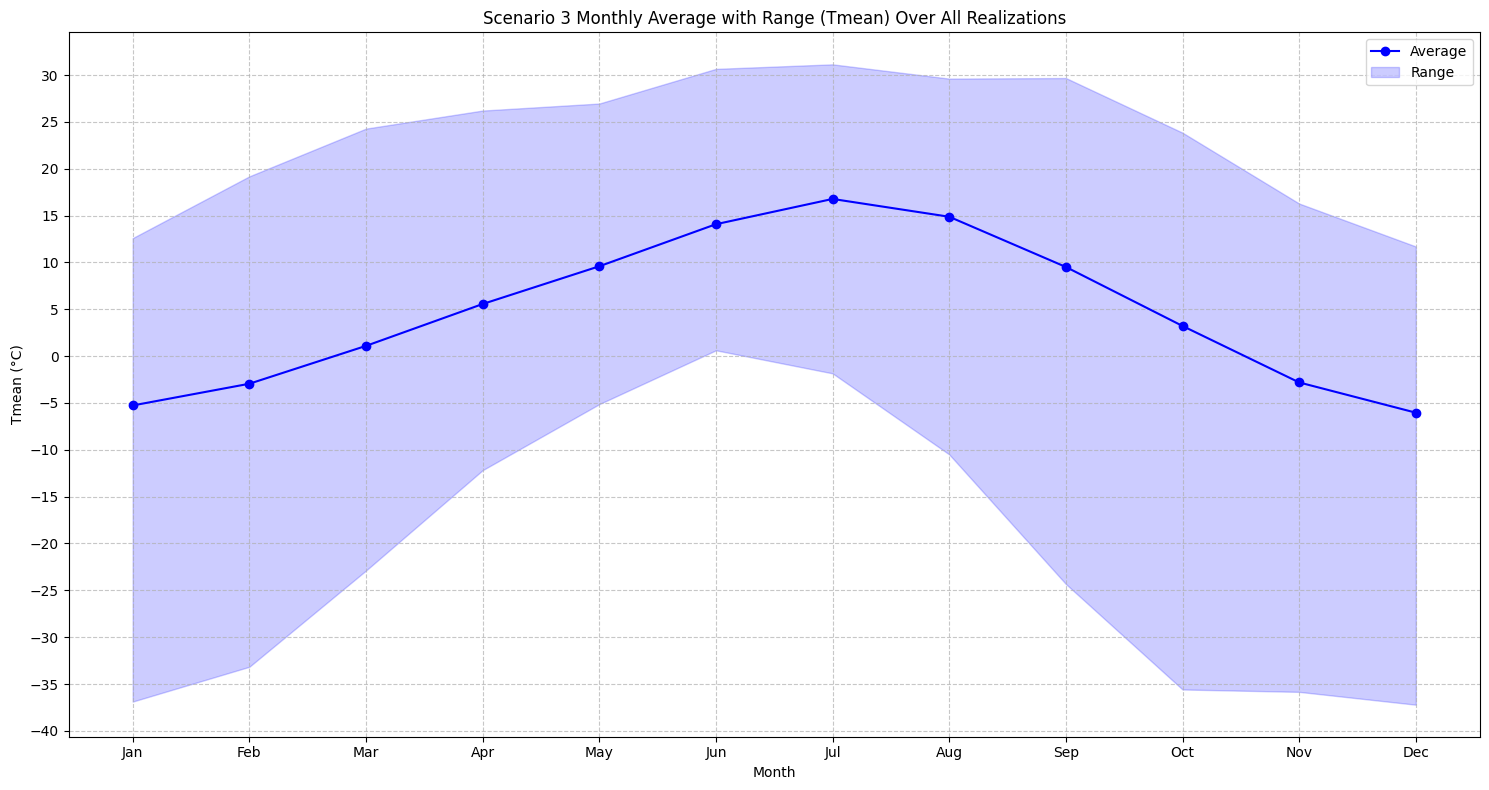

In [126]:
plot_monthly_average_with_range(s3_dfs, 'tmean', title_prefix="Scenario 3")


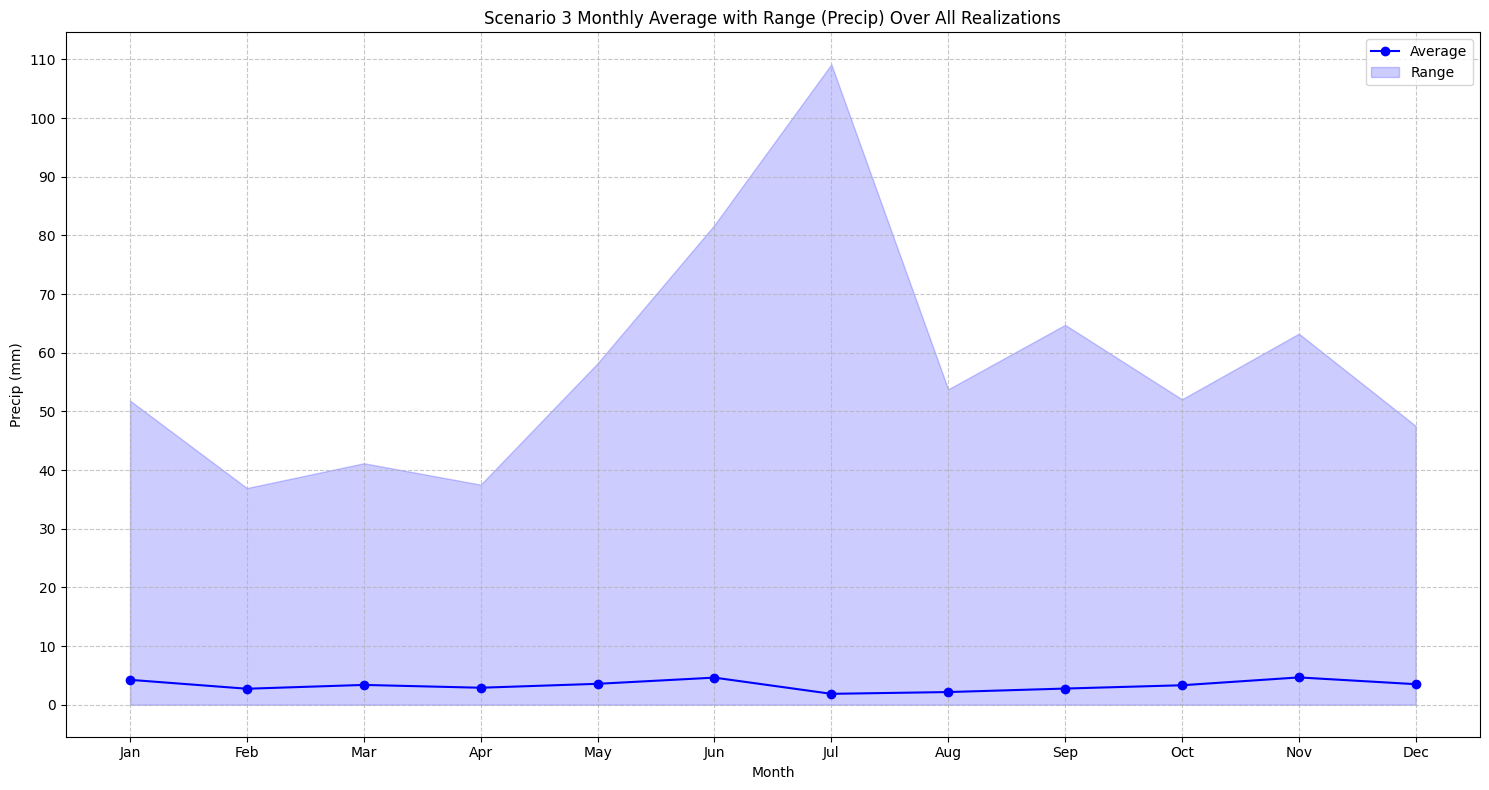

In [127]:
plot_monthly_average_with_range(s3_dfs, 'precip', title_prefix="Scenario 3")


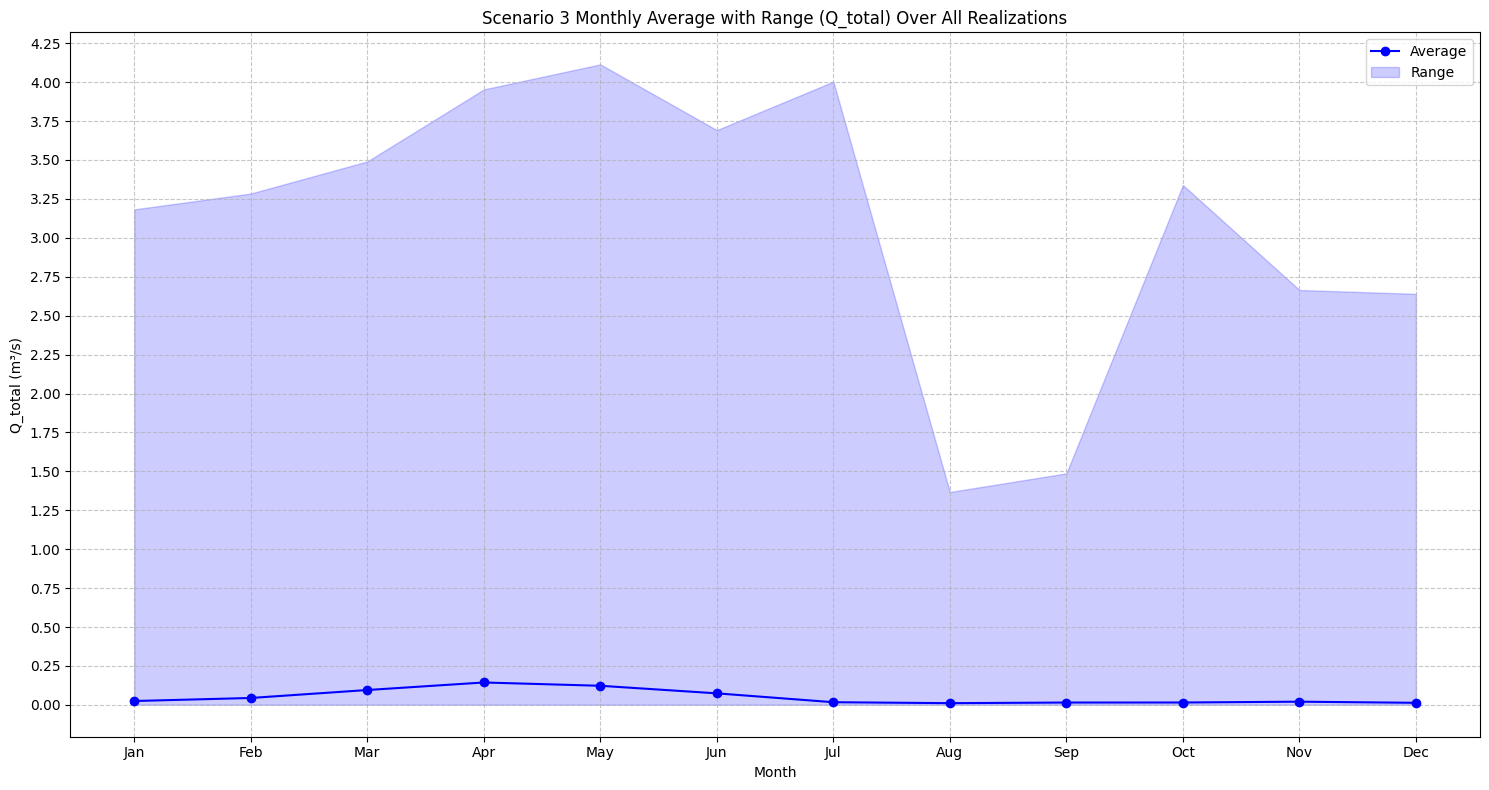

In [128]:
plot_monthly_average_with_range(s3_dfs, 'q_total', title_prefix="Scenario 3")


In [129]:
results_s3 = analyze_q_total_by_month(s3_dfs, 5) # july
print_combined_analysis_results(results_s3)

Combined DataFrame Analysis:
Mean 'q_total' for the month: 0.1229220098414434

Row with Maximum 'q_total':
      Date    precip    tmean   trange  evaporation  q_total
2064-05-07 32.420109 5.050827 5.344853     2.151794   4.1139

Top 5 highest 'q_total' values:
      Date    precip     tmean    trange  evaporation  q_total
2064-05-07 32.420109  5.050827  5.344853     2.151794   4.1139
2032-05-25 10.383552  4.723809  6.843517     2.237543   4.0653
2032-05-24 32.473576  9.613301 16.205885     4.557838   4.0200
2058-05-31 13.249215 18.140881 19.740305     7.826416   3.7019
2049-05-06 13.994493 10.455328 10.331192     4.122820   3.5670

--------------------------------------------------



In [130]:
results_s3 = analyze_q_total_by_month(s3_dfs, 7) # july
print_combined_analysis_results(results_s3)

Combined DataFrame Analysis:
Mean 'q_total' for the month: 0.017368301575393853

Row with Maximum 'q_total':
      Date    precip     tmean   trange  evaporation  q_total
2038-07-22 67.727966 10.373542 5.342939     3.770218    4.003

Top 5 highest 'q_total' values:
      Date    precip     tmean    trange  evaporation  q_total
2038-07-22 67.727966 10.373542  5.342939     3.770218   4.0030
2038-07-21 51.094376 10.989653  6.466439     4.075629   3.4992
2100-07-06  9.741354 14.116182  4.215175     4.753901   3.2522
2081-07-04 29.981810 13.934232  6.874071     5.016861   2.9647
2038-07-23  0.000000 12.831535 13.928477     5.507741   2.8670

--------------------------------------------------



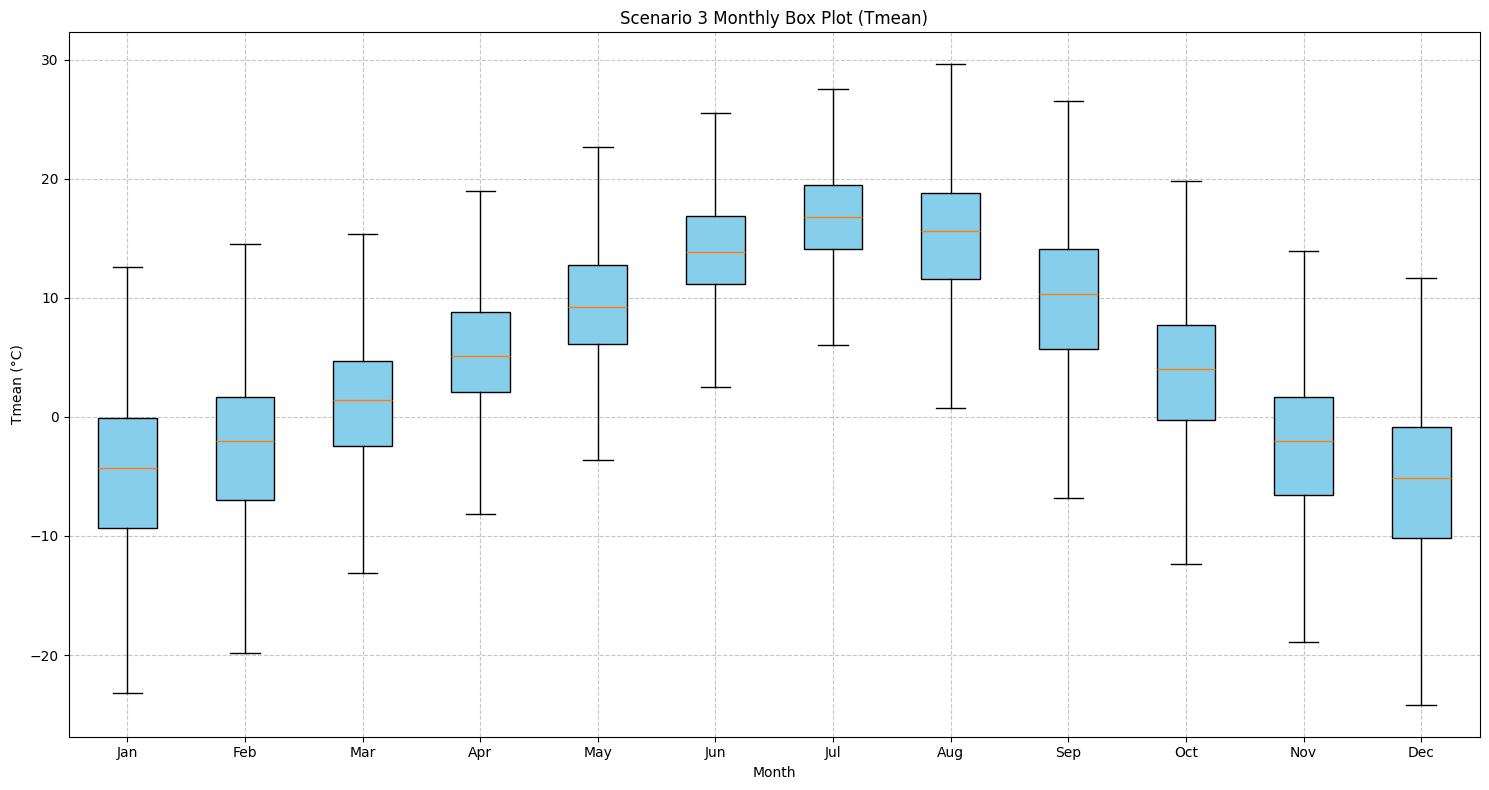

In [131]:
plot_monthly_boxplot(s3_dfs, 'tmean', title_prefix='Scenario 3')


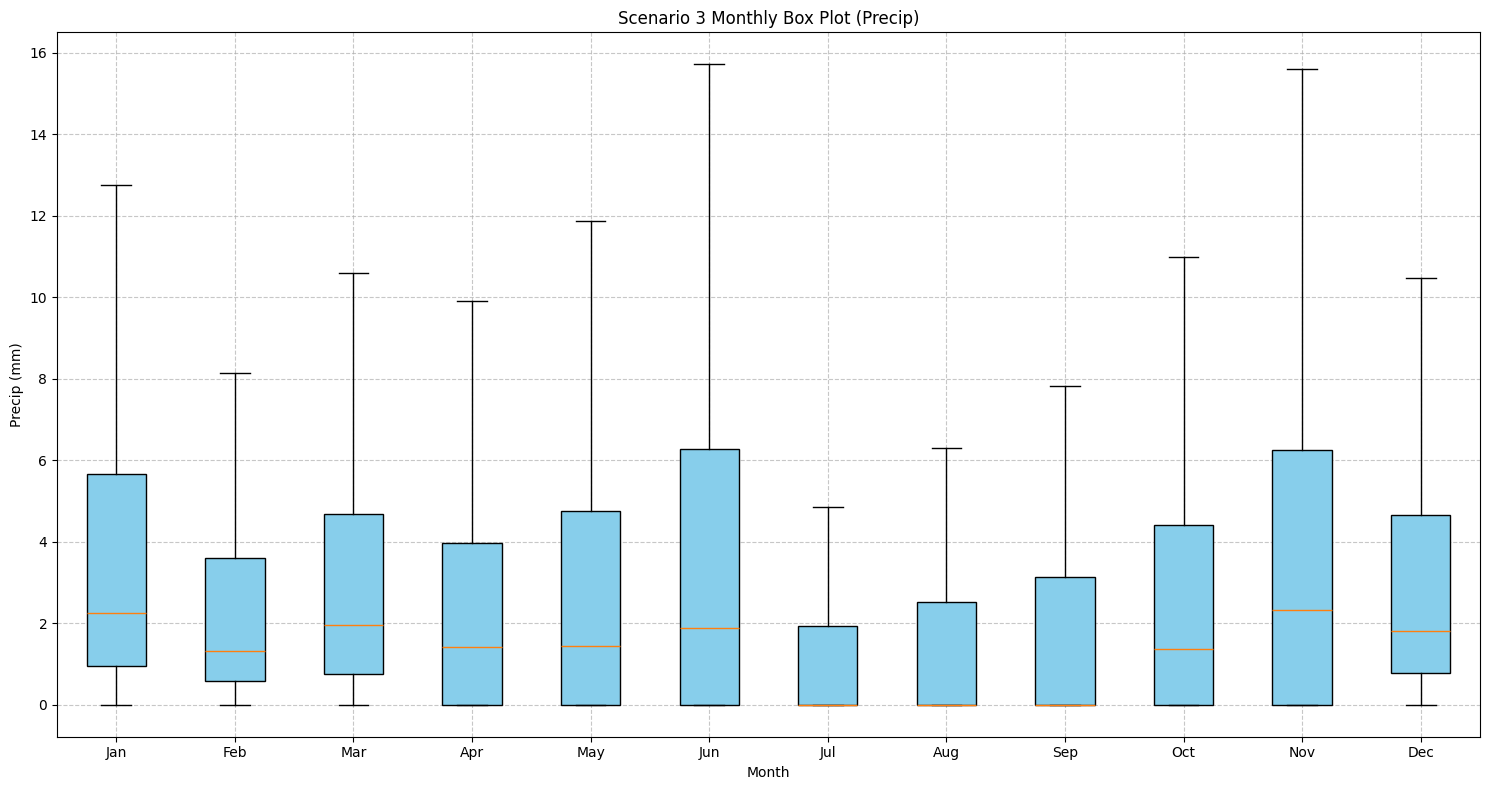

In [132]:
plot_monthly_boxplot(s3_dfs, 'precip', title_prefix='Scenario 3')


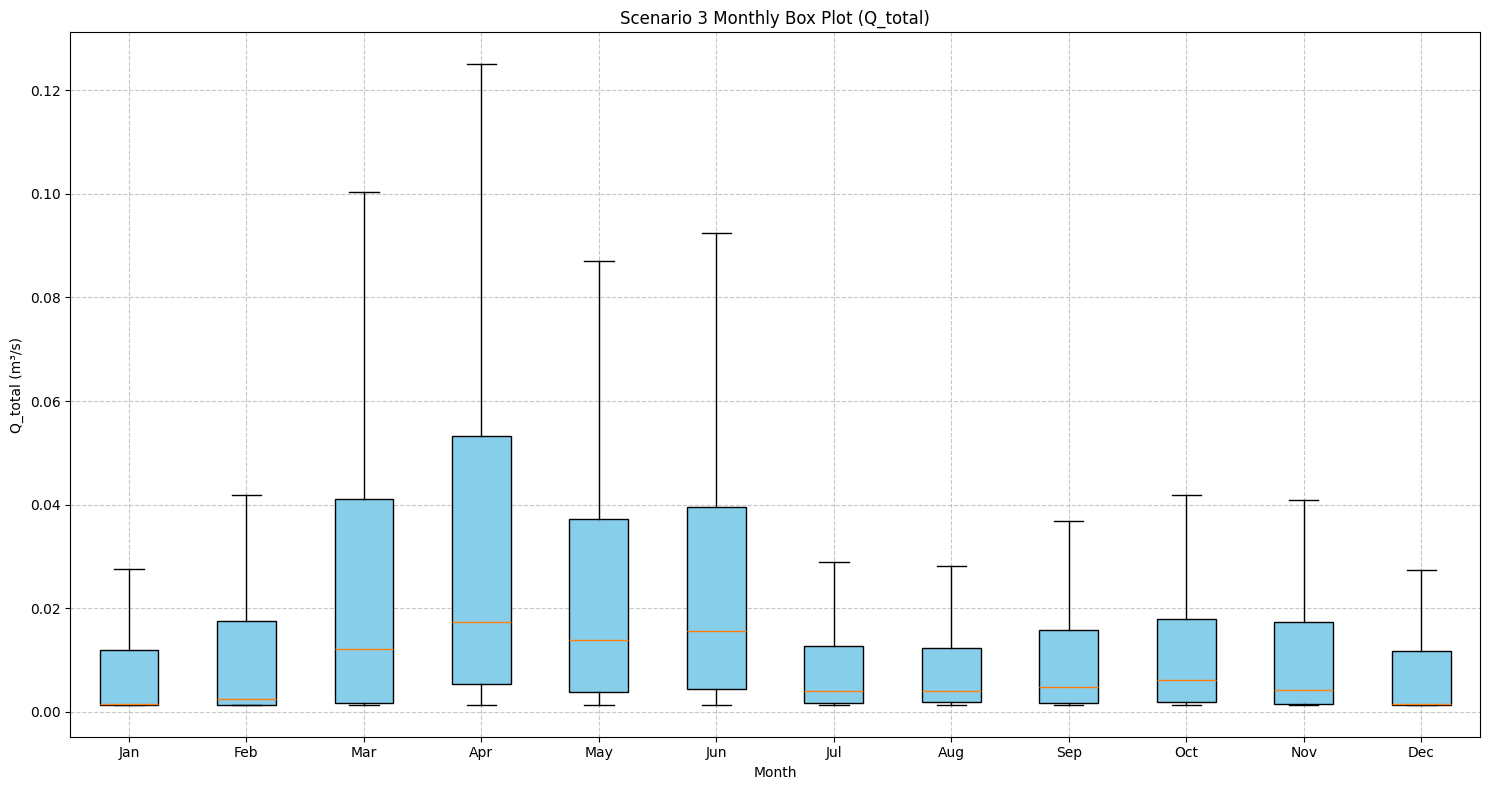

In [133]:
plot_monthly_boxplot(s3_dfs, 'q_total', title_prefix='Scenario 3')


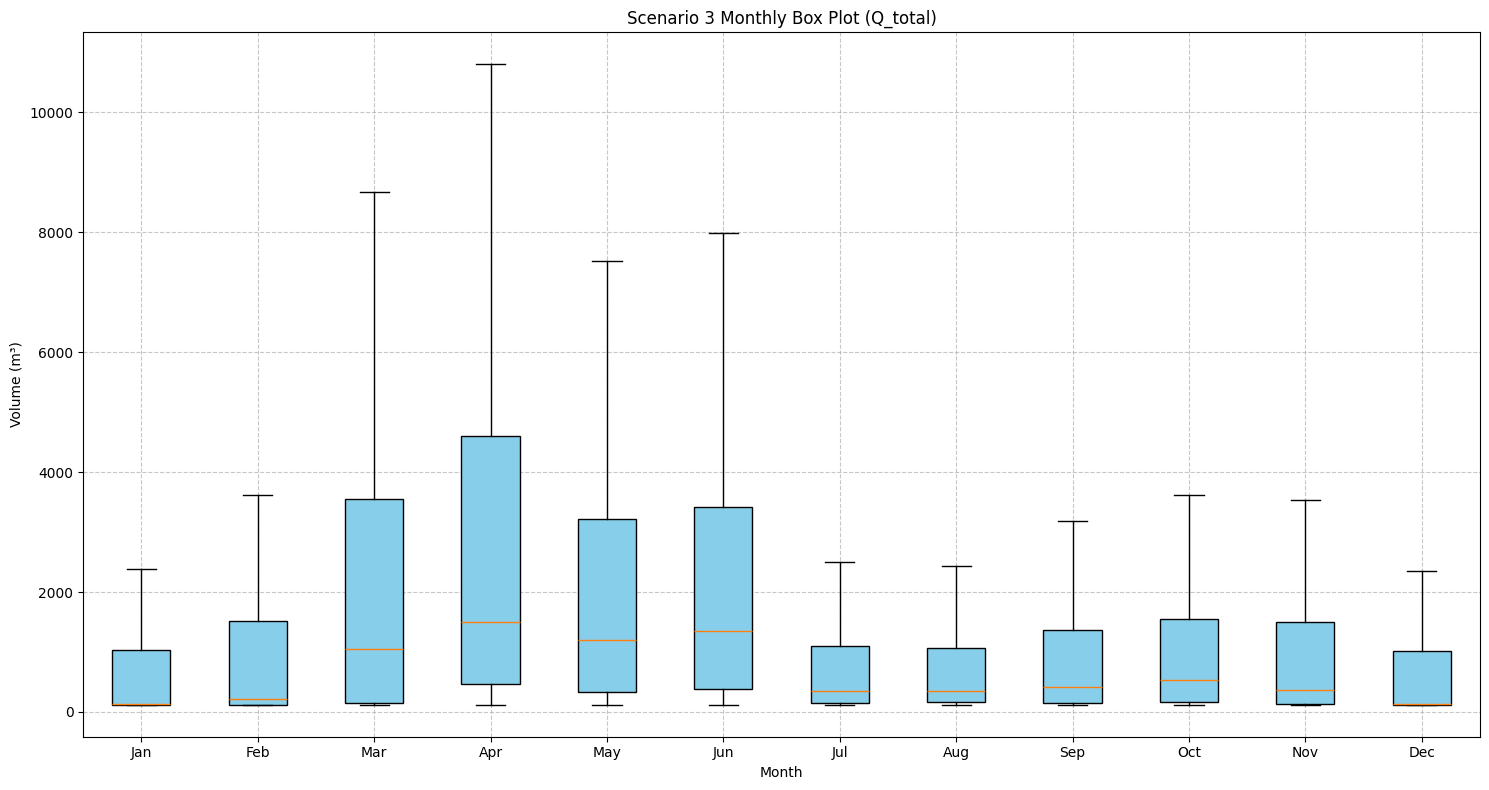

In [134]:
plot_monthly_volume_boxplot(s3_dfs, 'Scenario 3')

## **Scenario 4:** SSP5-8.5 = *optimal for economic development but with high emissions.*

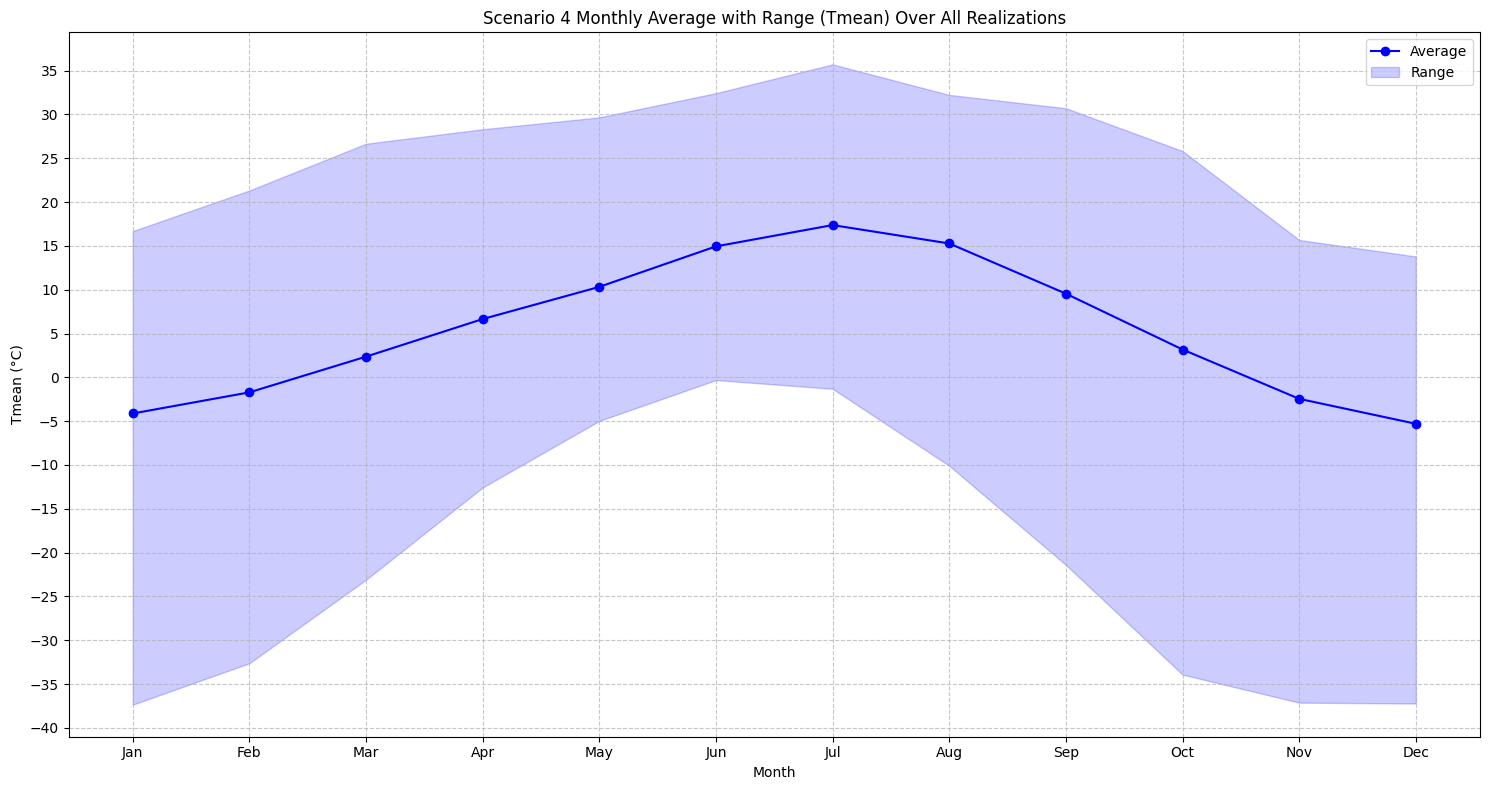

In [135]:
plot_monthly_average_with_range(s4_dfs, 'tmean', title_prefix="Scenario 4")


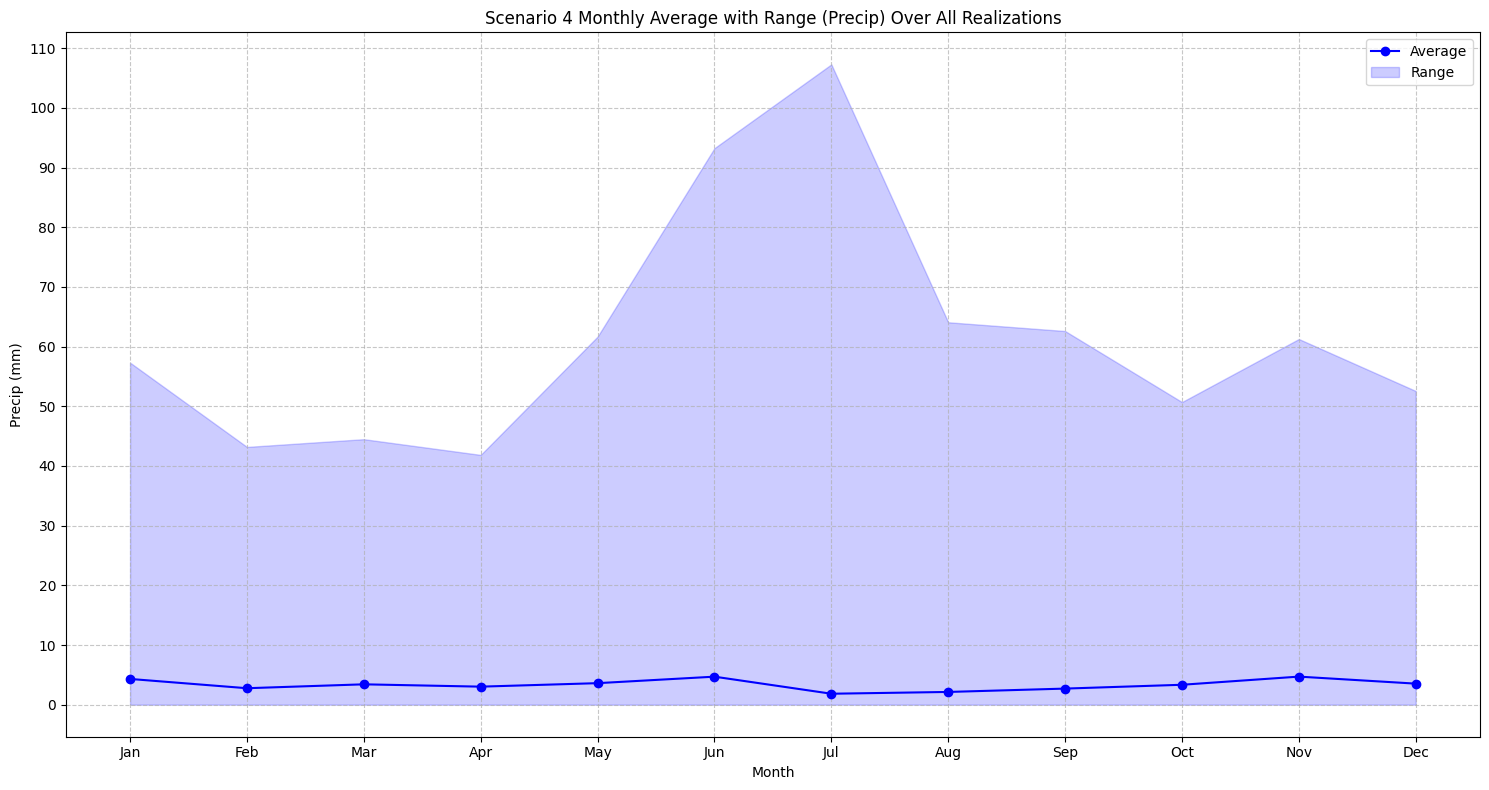

In [136]:
plot_monthly_average_with_range(s4_dfs, 'precip', title_prefix="Scenario 4")


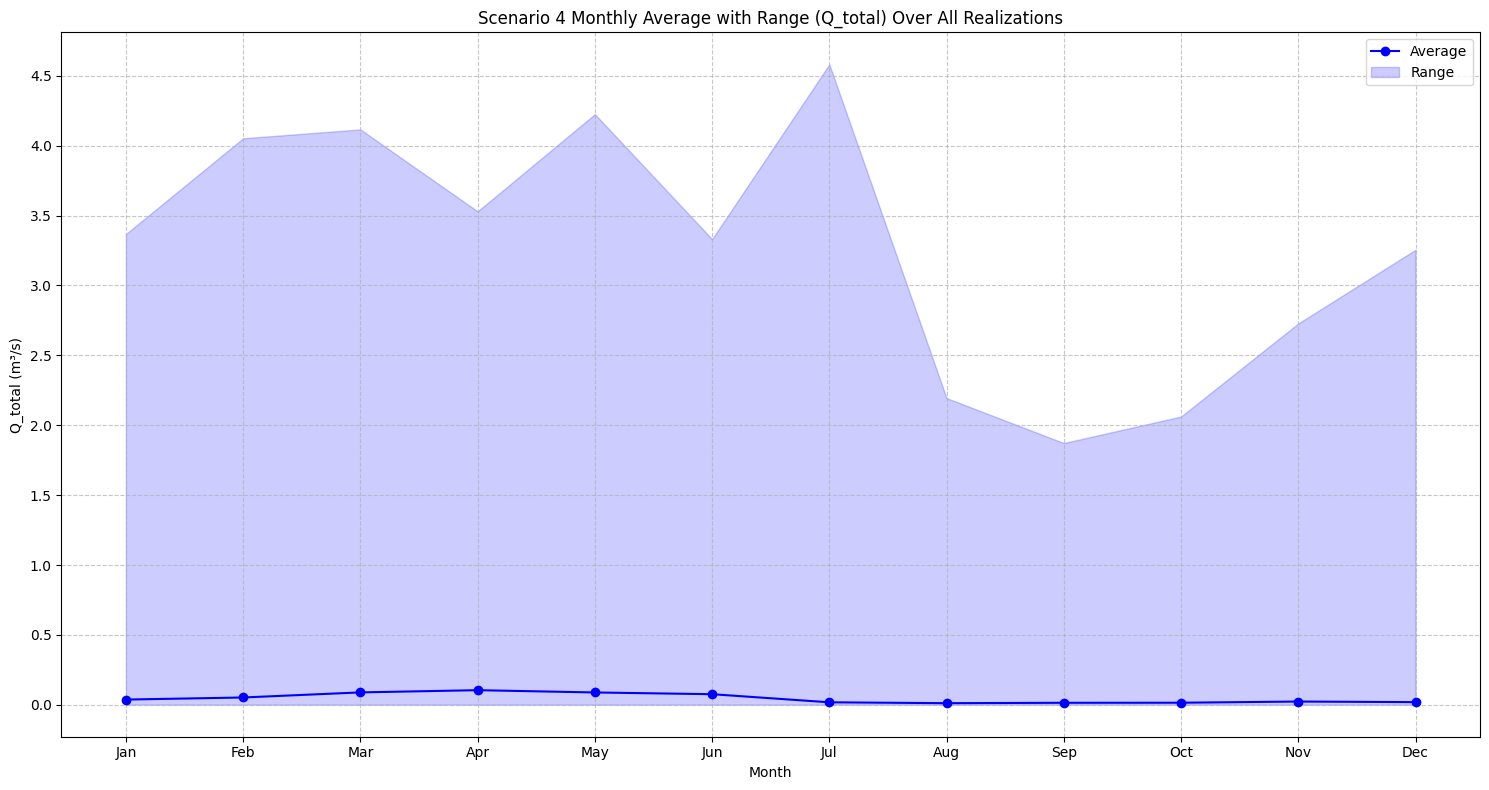

In [137]:
plot_monthly_average_with_range(s4_dfs, 'q_total', title_prefix="Scenario 4")


In [138]:
results_s4 = analyze_q_total_by_month(s4_dfs, 5) # may
print_combined_analysis_results(results_s4)

Combined DataFrame Analysis:
Mean 'q_total' for the month: 0.08899257645343538

Row with Maximum 'q_total':
      Date    precip     tmean    trange  evaporation  q_total
2031-05-16 15.708182 13.211199 12.812832     5.267099  4.22523

Top 5 highest 'q_total' values:
      Date    precip     tmean    trange  evaporation  q_total
2031-05-16 15.708182 13.211199 12.812832     5.267099  4.22523
2053-05-16 15.454644  9.718460  8.083323     3.656247  4.05001
2038-05-06 19.835987 12.076344 11.442331     4.830446  3.99128
2051-05-15 14.252158 13.577093 11.885731     5.272966  3.88298
2031-05-17  2.560031  8.882792  7.174850     3.346015  3.84323

--------------------------------------------------



In [139]:
results_s4 = analyze_q_total_by_month(s4_dfs, 7) # july
print_combined_analysis_results(results_s4)

Combined DataFrame Analysis:
Mean 'q_total' for the month: 0.018611844711177796

Row with Maximum 'q_total':
      Date    precip    tmean  trange  evaporation  q_total
2053-07-02 29.278116 8.920242 4.20062     3.264697  4.58119

Top 5 highest 'q_total' values:
      Date     precip     tmean    trange  evaporation  q_total
2053-07-02  29.278116  8.920242  4.200620     3.264697  4.58119
2080-07-05  72.670998 16.844110  8.610210     6.229503  3.12890
2053-07-01 107.283447 15.575300 11.482091     6.147243  3.04769
2070-07-04  93.076813 20.440470 16.449894     8.614696  3.02877
2098-07-11  37.230156 26.036293 11.484278    10.429554  2.83893

--------------------------------------------------



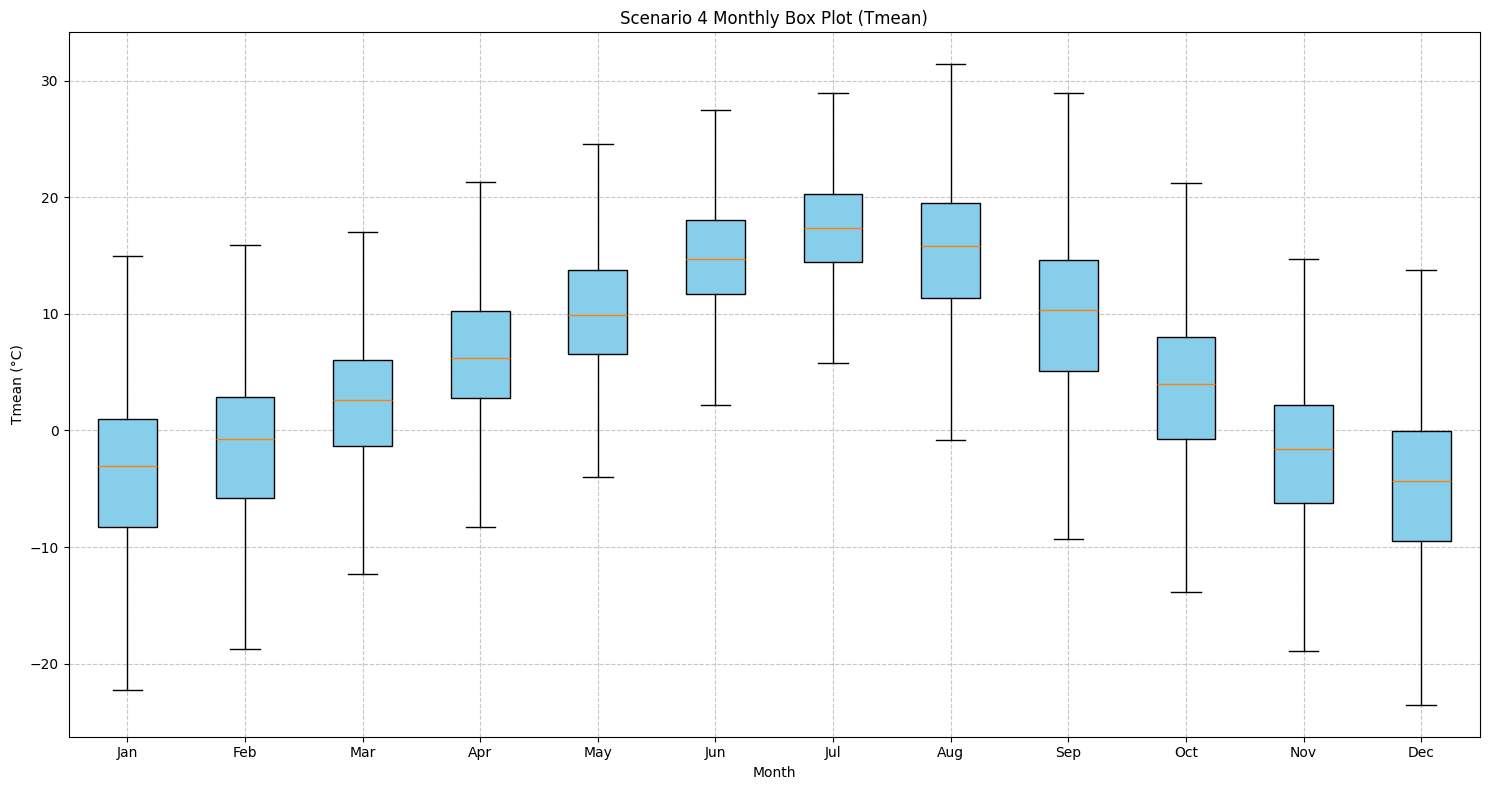

In [140]:
plot_monthly_boxplot(s4_dfs, 'tmean', title_prefix='Scenario 4')


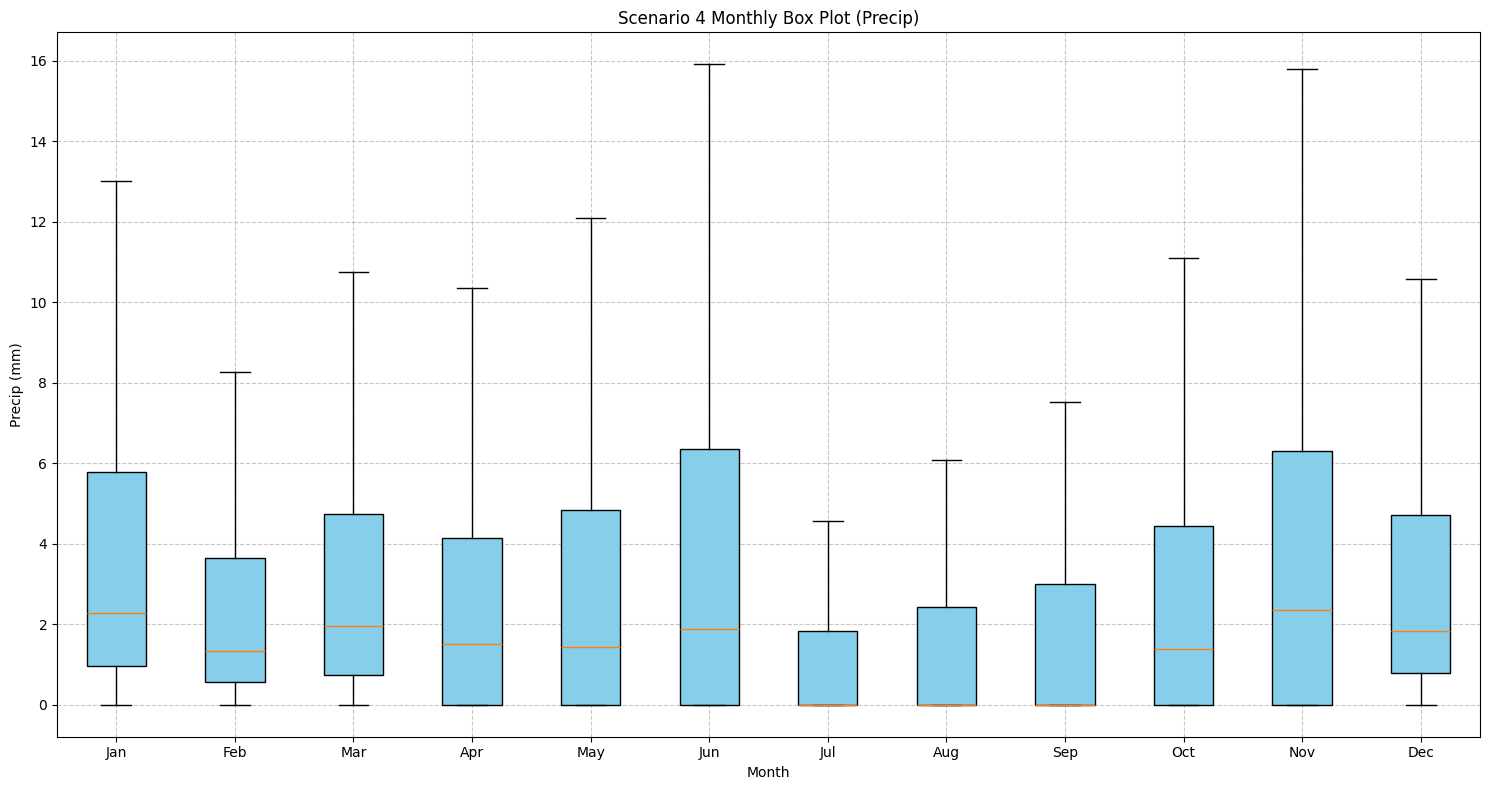

In [141]:
plot_monthly_boxplot(s4_dfs, 'precip', title_prefix='Scenario 4')


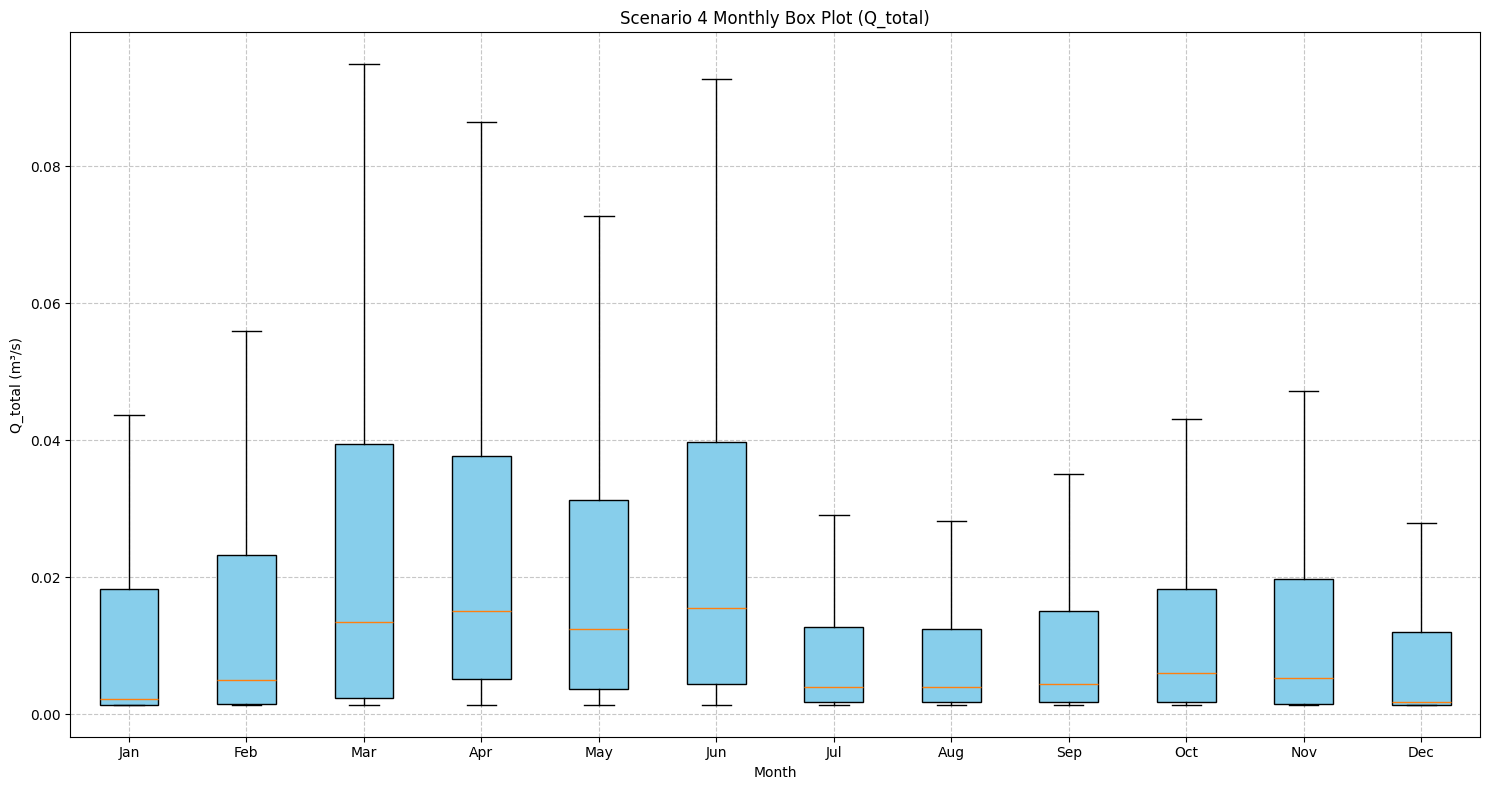

In [142]:
plot_monthly_boxplot(s4_dfs, 'q_total', title_prefix='Scenario 4')


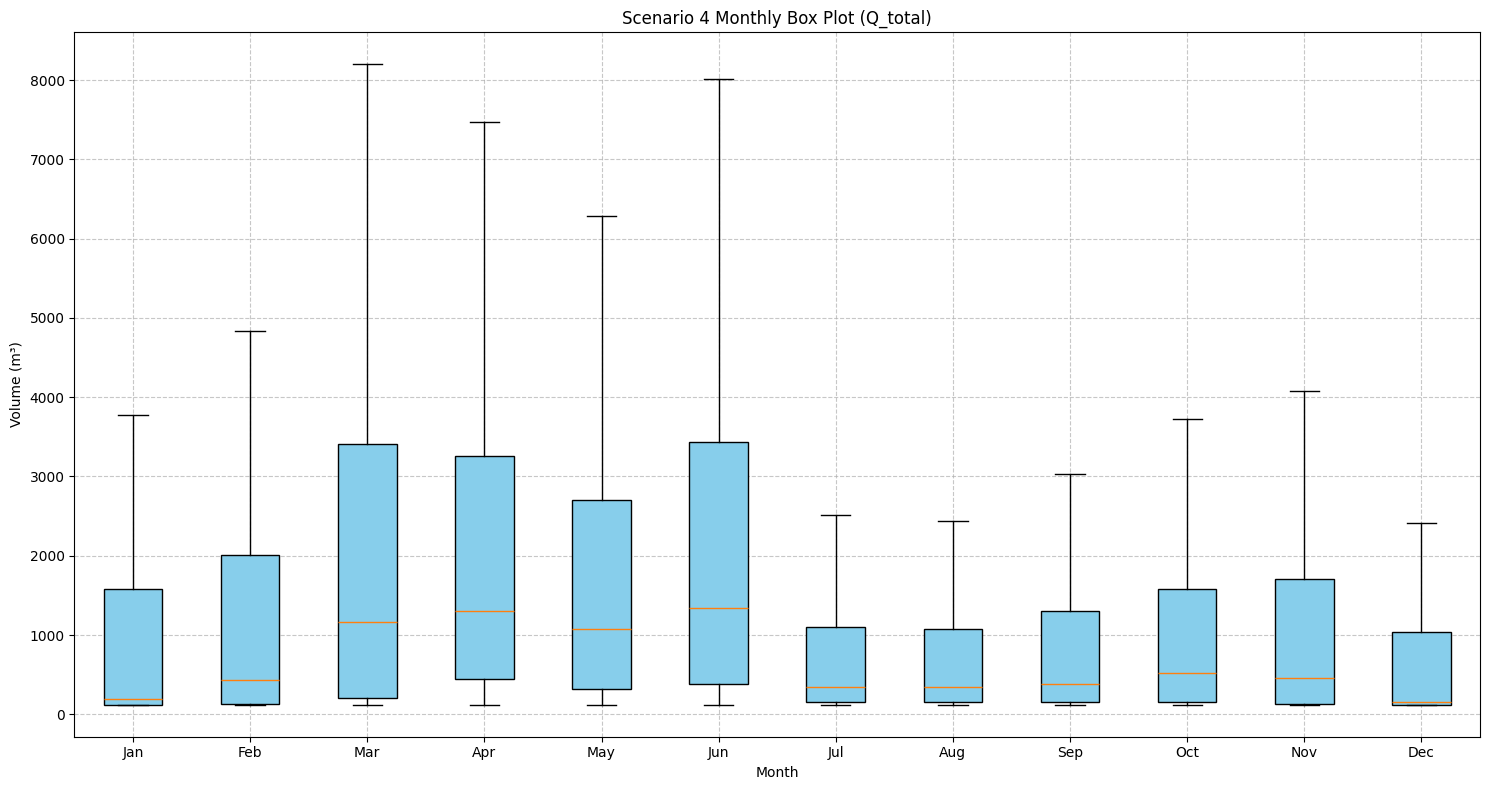

In [143]:
plot_monthly_volume_boxplot(s4_dfs, 'Scenario 4')

## Comparison

## All Realizations Over all Years

### Temperature

C:\Users\14037\AppData\Local\Temp\ipykernel_19948\1442284087.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black') for i in range(len(list_of_df_lists))]


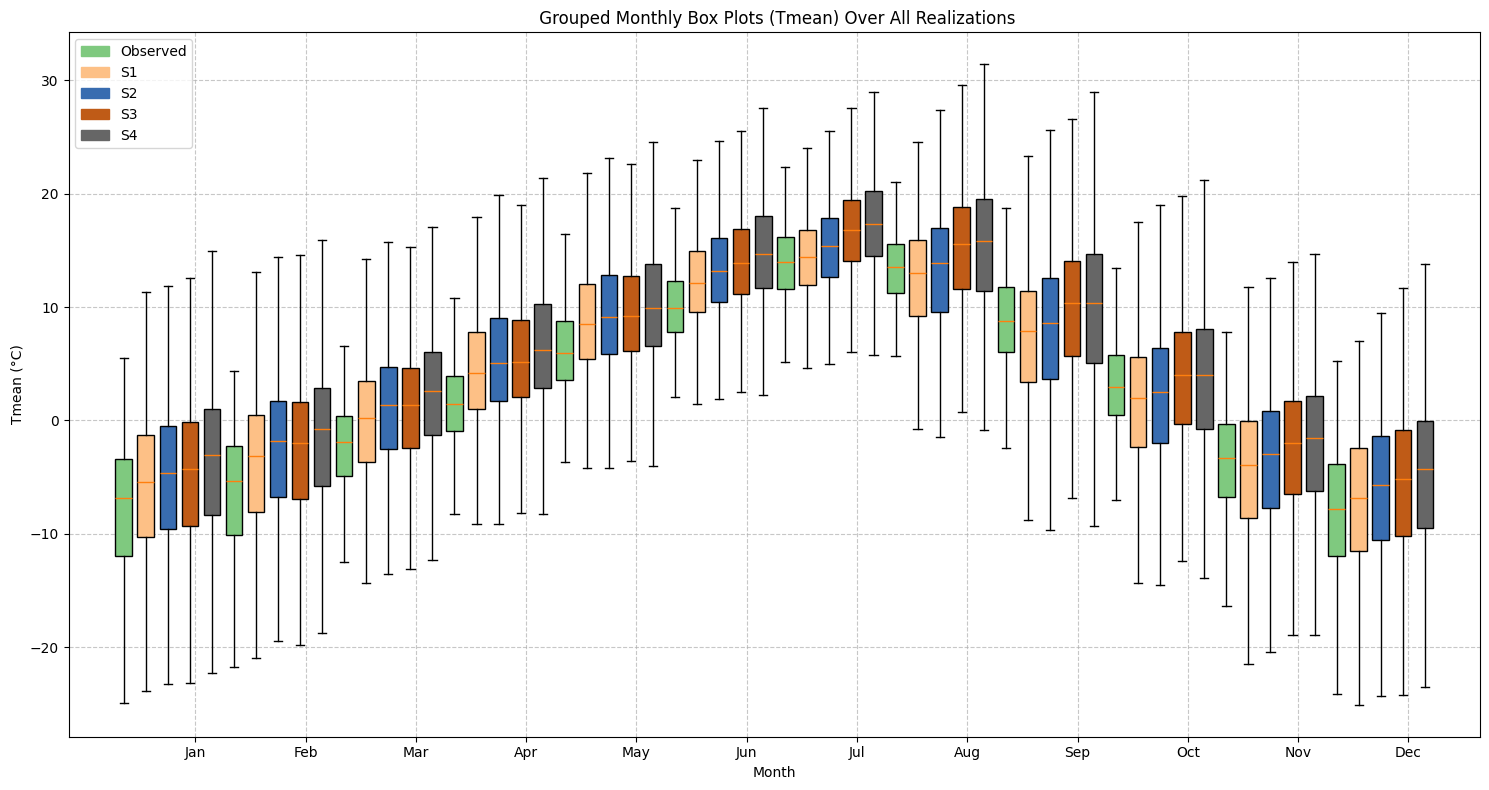

In [144]:
list_of_df_lists = [observed_dfs, s1_dfs, s2_dfs, s3_dfs, s4_dfs]
plot_monthly_grouped_boxplots(list_of_df_lists, 'tmean')

### Precipitation

C:\Users\14037\AppData\Local\Temp\ipykernel_19948\1442284087.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black') for i in range(len(list_of_df_lists))]


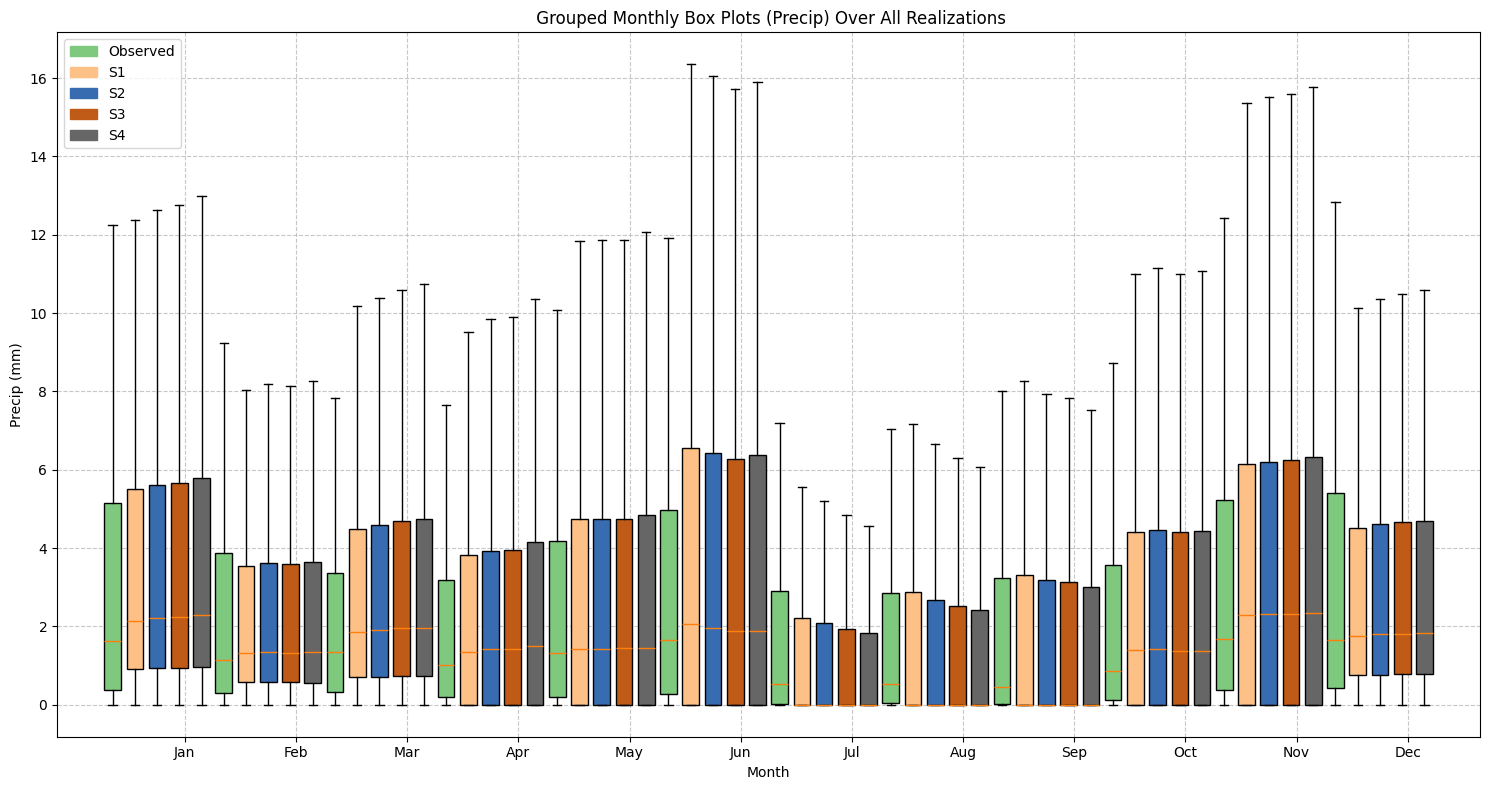

In [145]:
plot_monthly_grouped_boxplots(list_of_df_lists, 'precip')

### Flow

C:\Users\14037\AppData\Local\Temp\ipykernel_19948\1442284087.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black') for i in range(len(list_of_df_lists))]


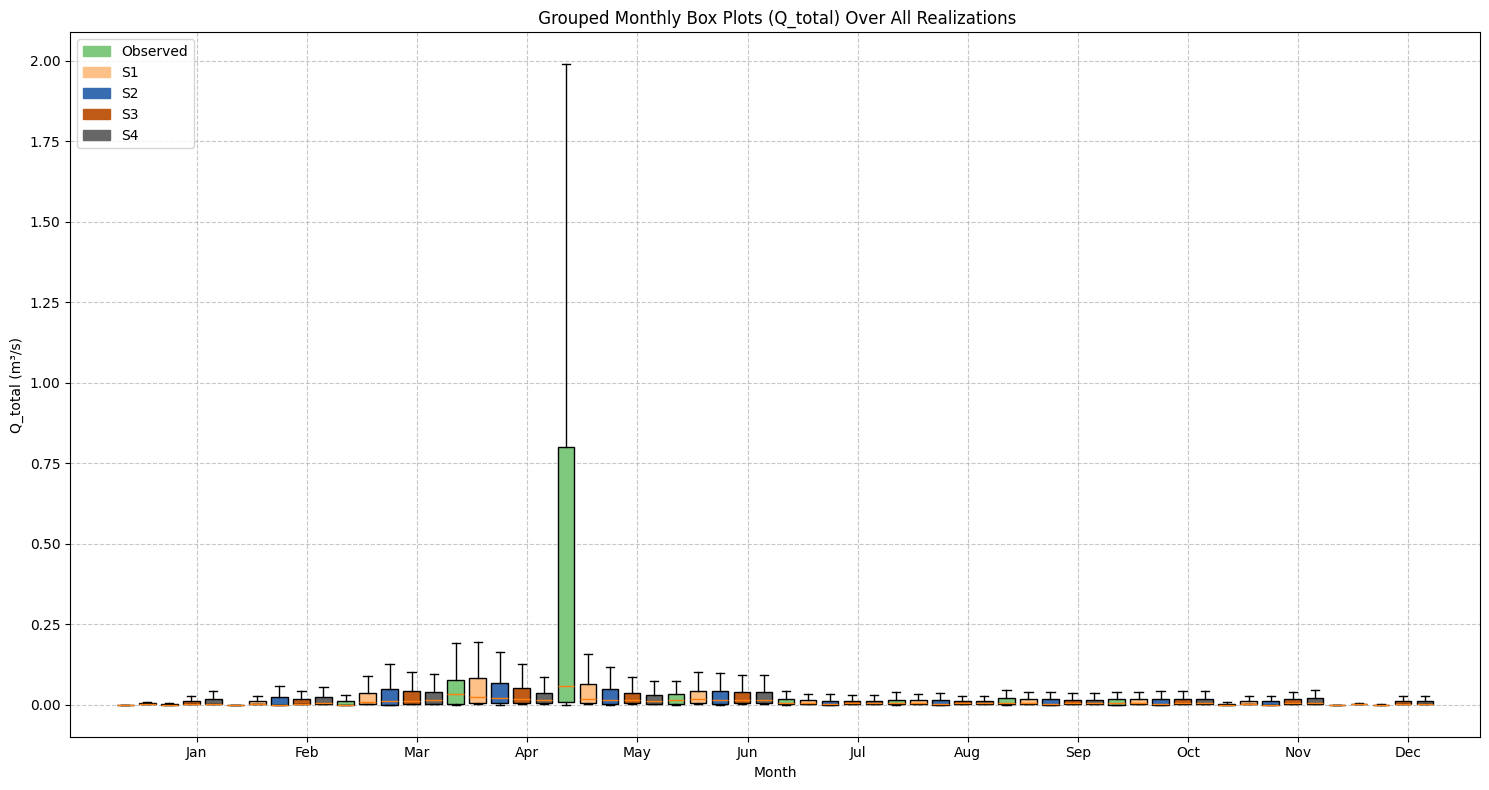

In [146]:
plot_monthly_grouped_boxplots(list_of_df_lists, 'q_total')

#### Flow in Volume

C:\Users\14037\AppData\Local\Temp\ipykernel_19948\3713482268.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black') for i in range(len(list_of_df_lists))]


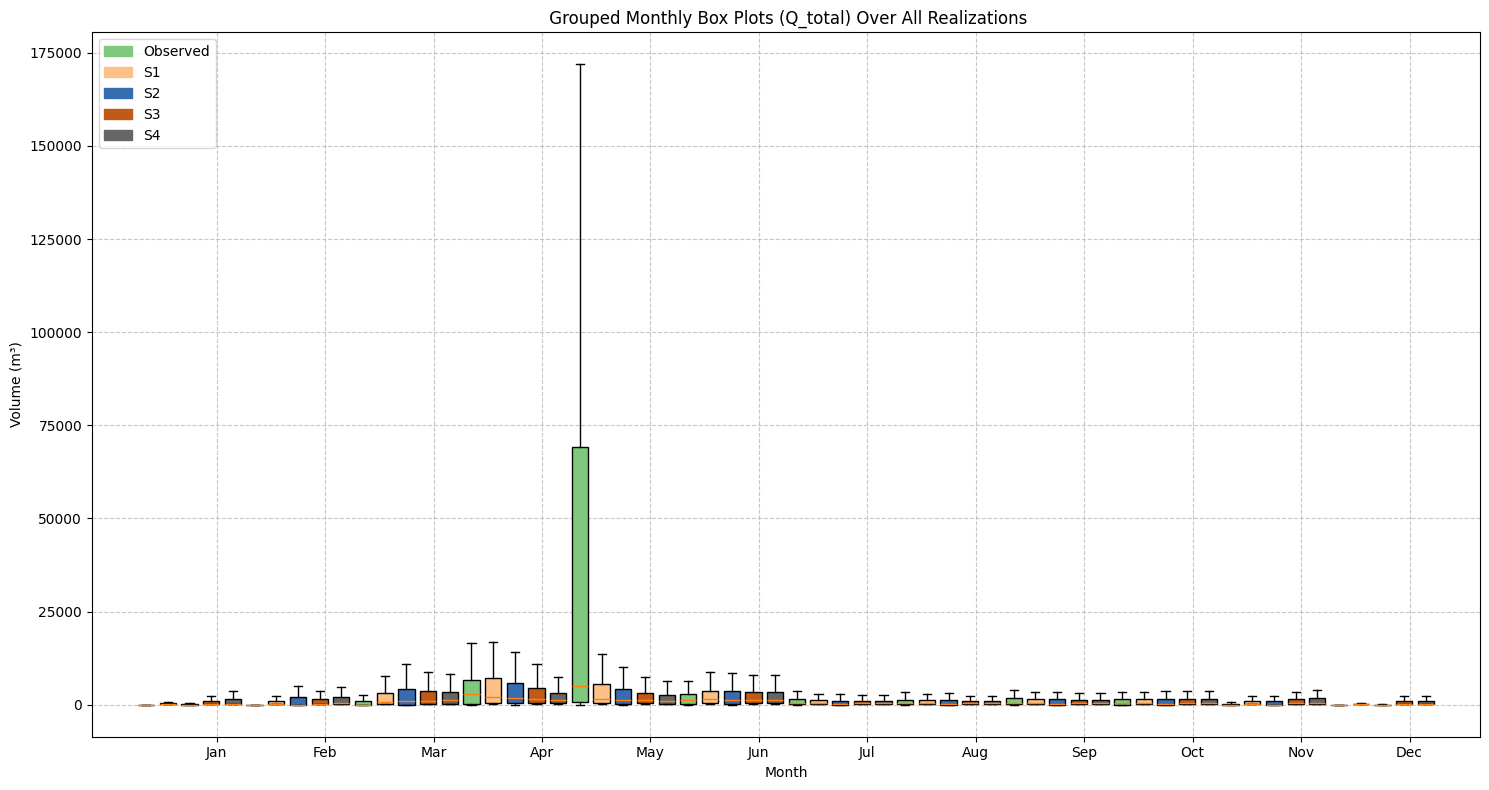

In [147]:
plot_monthly_volume_grouped_boxplots(list_of_df_lists)

#### Flow 30 Year Comparisons

C:\Users\14037\AppData\Local\Temp\ipykernel_19948\816169187.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.legend([plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in colors], legend_labels, title="Scenarios", loc='upper left')


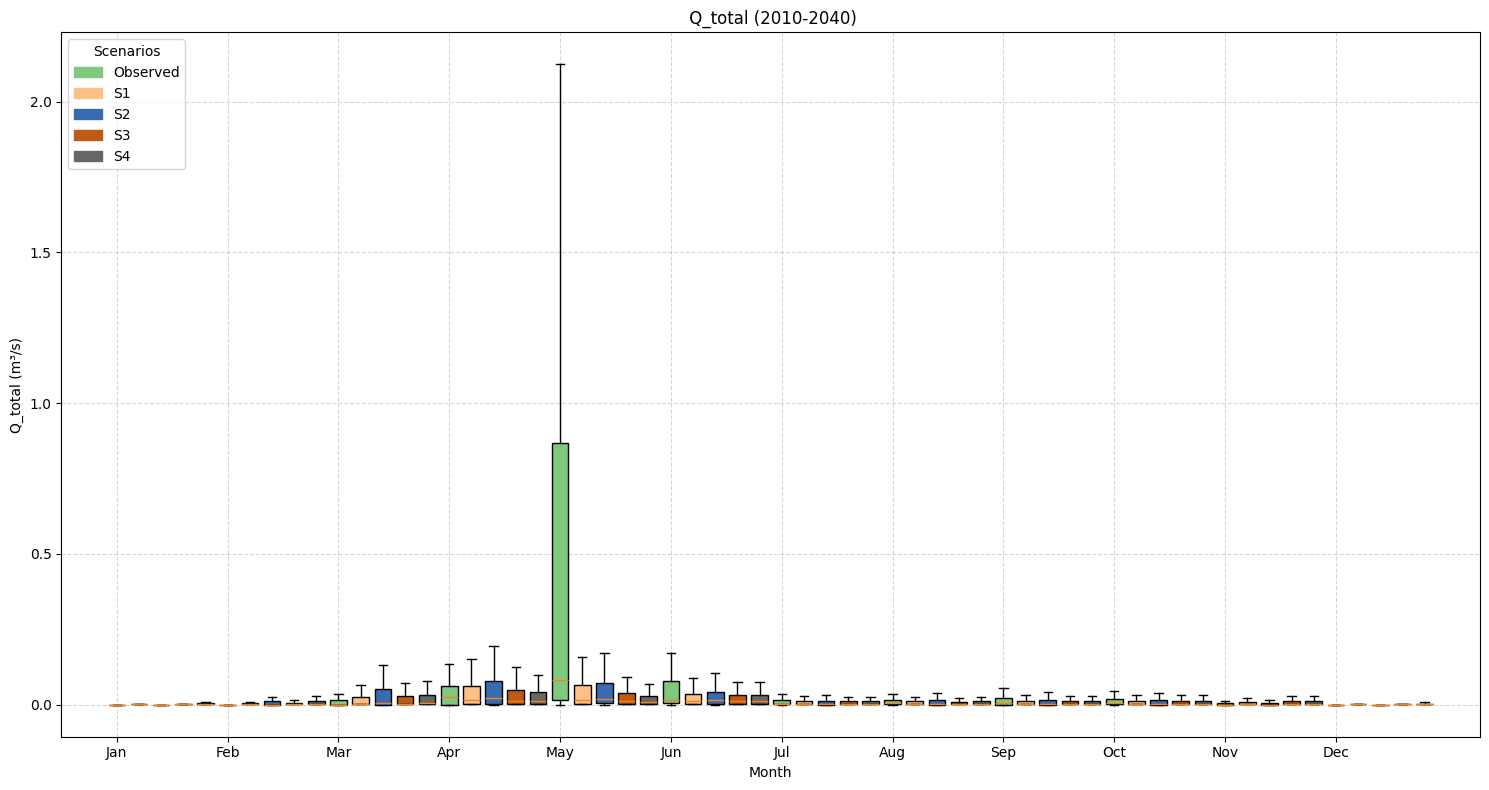

C:\Users\14037\AppData\Local\Temp\ipykernel_19948\816169187.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.legend([plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in colors], legend_labels, title="Scenarios", loc='upper left')


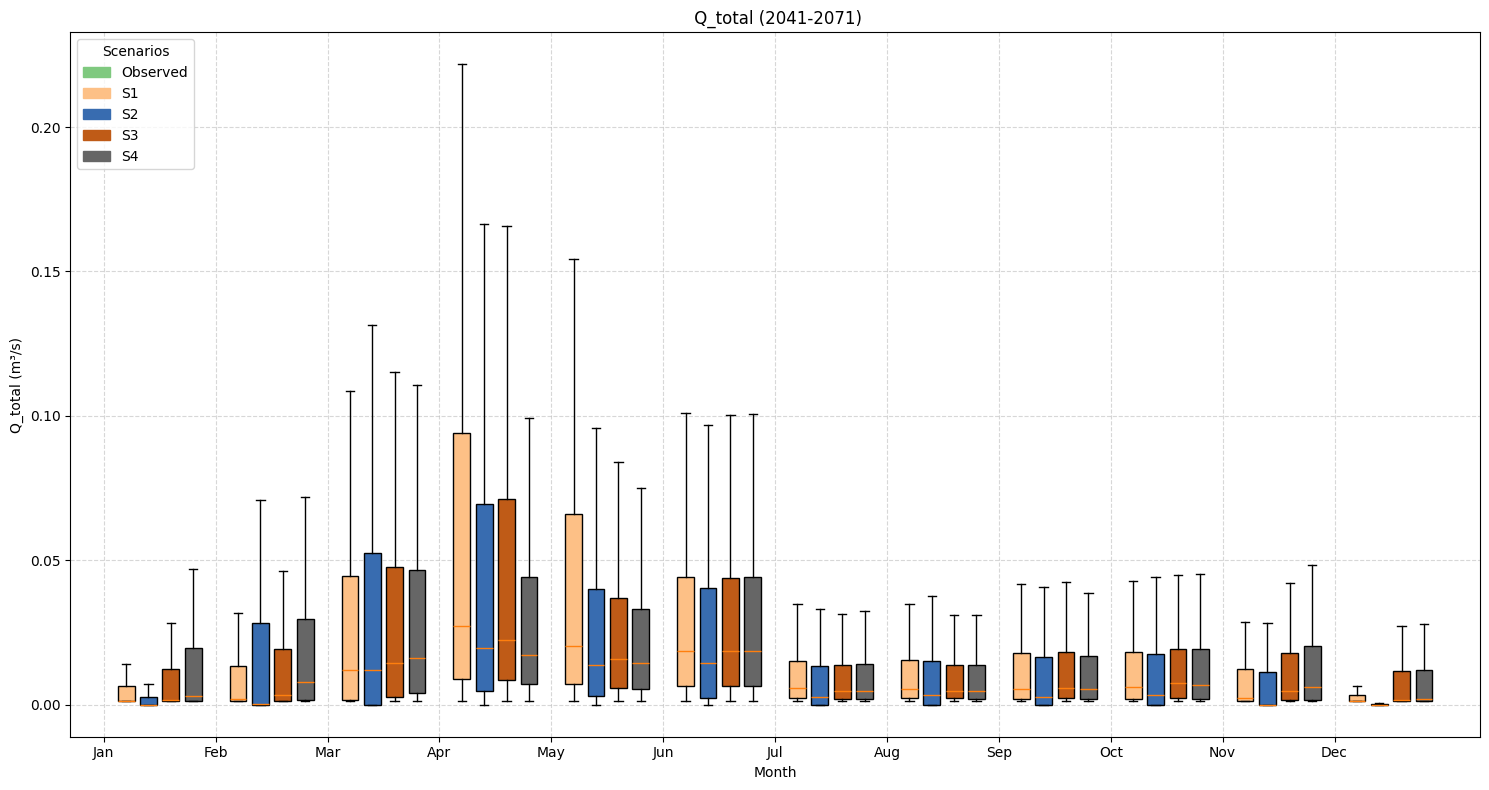

C:\Users\14037\AppData\Local\Temp\ipykernel_19948\816169187.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.legend([plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in colors], legend_labels, title="Scenarios", loc='upper left')


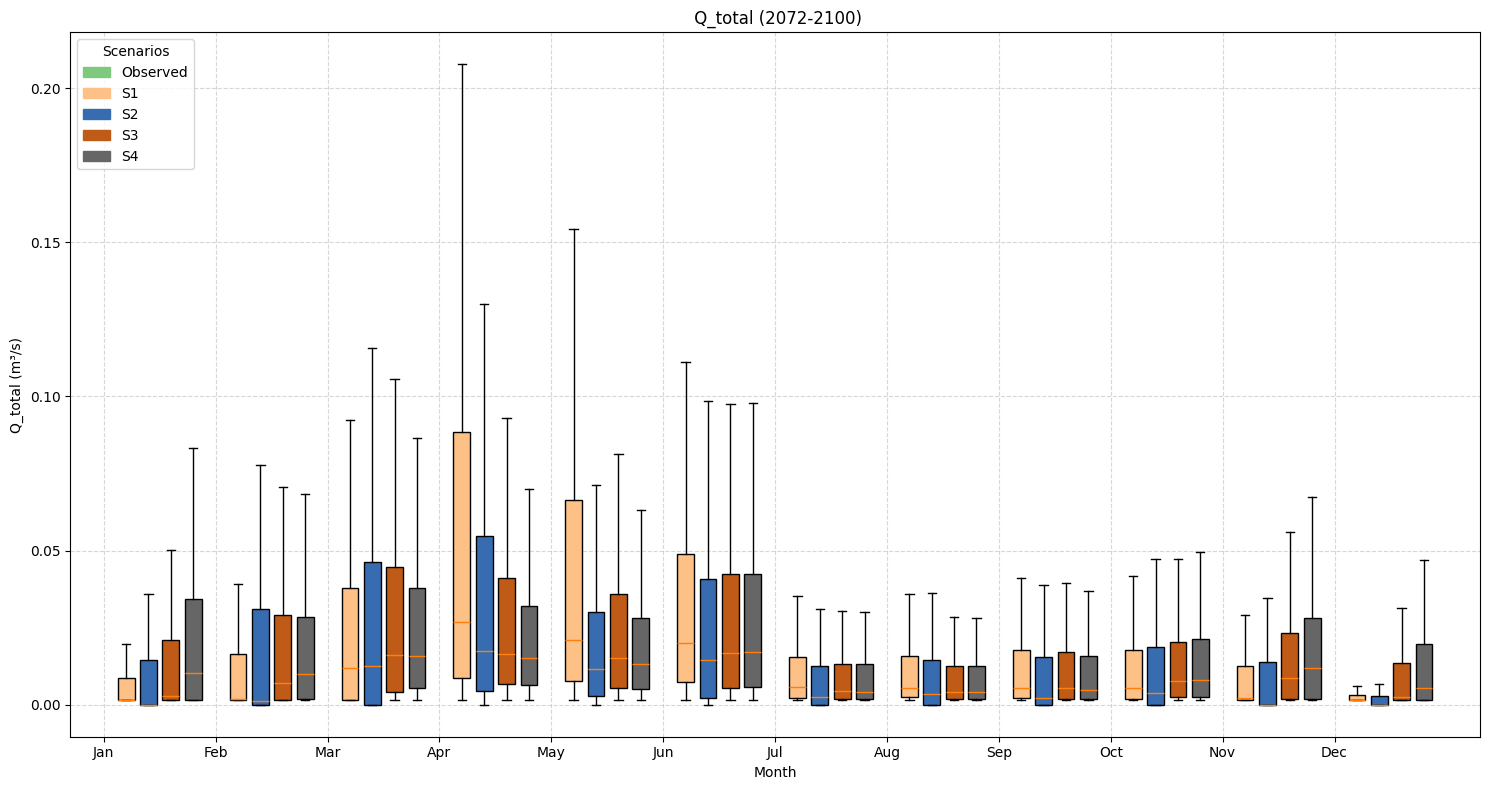

In [148]:
plot_monthly_boxplots_by_periods(list_of_df_lists, 'q_total', start_year=2010, end_year=2100, years_per_period=31)